# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


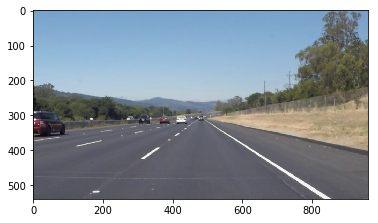

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

alpha = 0.5
consecutive_misses = 0

def draw_lane(image, lane_xy, xmin, xmax, color,  last_params=None):
    global consecutive_misses
    if len(lane_xy[0]) > 1 and len(lane_xy[1]) > 1:
        print("Found. Consecutive misses: {}".format(consecutive_misses))
        consecutive_misses = 0
        lane_params = np.polyfit(lane_xy[0], lane_xy[1], 1)
    else:
        print("No fit")
        lane_params = last_params
        consecutive_misses += 1
    if last_params is not None:
        print("Last params")
        print(last_params)
        lane_params = alpha * lane_params + (1-alpha) * last_params

    print(lane_params)
    x, y = lane_xy[0], lane_xy[1]
    f = np.poly1d(lane_params)
    #     print (x)
    #     print((min(x), max(x)))

    #     cv2.line(image,(min(x), int(f(min(x)))),(max(x), int(f(max(x)))),color,10)
    cv2.line(image, (xmin, int(f(xmin))), (xmax, int(f(xmax))), color, 10)
    return lane_params


left_temp_lane_params = None
right_temp_lane_params = None
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    global  left_temp_lane_params
    global  right_temp_lane_params
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    left_lane = []
    right_lane = []
    left_lane_xy = [[], []]
    right_lane_xy = [[], []]

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if slope < -0.5:
                left_lane.append([x1, y1, x2, y2])
                left_lane_xy[0].extend([x1, x2])
                left_lane_xy[1].extend([y1, y2])
            elif slope > 0.5:
                right_lane.append([x1, y1, x2, y2])
                right_lane_xy[0].extend([x1, x2])
                right_lane_xy[1].extend([y1, y2])

#     for line in left_lane:
#         x1,y1,x2,y2 = line
#         cv2.line(img, (x1, y1), (x2, y2), color, thickness)

#     for line in right_lane:
#         x1,y1,x2,y2 = line
#         cv2.line(img, (x1, y1), (x2, y2), (0,255, 0), thickness)

    # left_lane_params = np.polyfit(left_lane_xy[0], left_lane_xy[1], 1)
    # print(right_lane_xy)
    # right_lane_params = np.polyfit(right_lane_xy[0], right_lane_xy[1], 1)
    # print (left_lane_params)
    # print (right_lane_params)
    imshape = img.shape
    left_temp_lane_params = draw_lane(img, left_lane_xy, 0, int(imshape[1] / 2 - 5), color, left_temp_lane_params)
    right_temp_lane_params = draw_lane(img, right_lane_xy, int(imshape[1] / 2 + 5), imshape[1], color, right_temp_lane_params)


#     x = left_lane_xy[0]
#     y = left_lane_xy[1]
#     f = np.poly1d(left_lane_params)
#     cv2.line(image,(min(x), int(f(min(x)))),(max(x), int(f(max(x)))),(255,0,0),10)

#     x = left_lane_xy[0]
#     y = left_lane_xy[1]
#     f = np.poly1d(left_lane_params)
#     cv2.line(image,(min(x), int(f(min(x)))),(max(x), int(f(max(x)))),(255,0,0),10)



def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Found. Consecutive misses: 0
[  -0.67954296  636.73523514]
Found. Consecutive misses: 0
[ 0.64379721 -3.32830985]
solidWhiteRight.jpg
Found. Consecutive misses: 0
Last params
[  -0.67954296  636.73523514]
[  -0.7404078   663.89258086]
Found. Consecutive misses: 0
Last params
[ 0.64379721 -3.32830985]
[  0.60439721  15.80388332]
solidWhiteCurve.jpg
Found. Consecutive misses: 0
Last params
[  -0.7404078   663.89258086]
[  -0.72801281  660.20414168]
Found. Consecutive misses: 0
Last params
[  0.60439721  15.80388332]
[  0.58683332  30.68015391]
solidYellowCurve.jpg
Found. Consecutive misses: 0
Last params
[  -0.72801281  660.20414168]
[  -0.73104766  661.23785416]
Found. Consecutive misses: 0
Last params
[  0.58683332  30.68015391]
[  0.57809099  38.1107048 ]
solidYellowCurve2.jpg
Found. Consecutive misses: 0
Last params
[  -0.73104766  661.23785416]
[  -0.71389595  651.36356167]
Found. Consecutive misses: 0
Last params
[  0.57809099  38.1107048 ]
[  0.59382638  27.84335987]
solidYellowLe

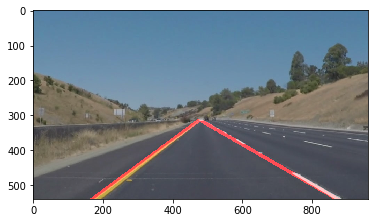

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

test_dir = 'test_images'
# test_dir = 'challenge_frames'
files = os.listdir(test_dir)
output_dir = 'lane_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


def mask_image(image, lower_range, upper_range):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Threshold the HSV image to get only selected range colors
    mask = cv2.inRange(hsv, lower_range, upper_range)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image, image, mask=mask)
    return mask


def mask_yellow_and_white(image):
    # define range of yellow color in HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    masked_yellow = mask_image(image, lower_yellow, upper_yellow)

    # define range of white color in HSV
    sensitivity = 30
    lower_white = np.array([0, 0, 255 - sensitivity])
    upper_white = np.array([255, sensitivity, 255])
    masked_white = mask_image(image, lower_white, upper_white)

    mask = cv2.bitwise_or(masked_yellow, masked_white)
    masked_img = cv2.bitwise_and(image, image, mask=mask)

    return masked_img


def lane_detector(image):
    masked_img = mask_yellow_and_white(image)
    # return masked_img

    gray = grayscale(masked_img)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    # return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    #     print(imshape)
    vertices = np.array([[(0, imshape[0]),
                          (imshape[1] / 2, imshape[0] / 2 + 20), (imshape[1] / 2 + 10, imshape[0] / 2 + 20),
                          (imshape[1], imshape[0])]],
                        dtype=np.int32)
    #     vertices = np.array([[(0,imshape[0]),(480,310), (490, 310), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    # return cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2RGB)
    # roi_img = region_of_interest(image, vertices)
    # return roi_img

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 10  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25  # minimum number of pixels making up a line
    max_line_gap = 10  # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the image
    line_detections = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return line_detections


if __name__ == "__main__":
    for file in files:
        image = mpimg.imread(os.path.join(test_dir, file))
        line_detections = lane_detector(image)
        print(file)
        basename = os.path.basename(file)
        fname = os.path.splitext(basename)[0]
        result = os.path.join(output_dir, "lane_{}.png".format(fname))
        mpimg.imsave(result, line_detections)
        plt.imshow(line_detections)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    result = lane_detector(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Found. Consecutive misses: 0
Last params
[  -0.73784305  665.86988922]
[  -0.72953588  658.65715545]
Found. Consecutive misses: 0
Last params
[  0.57512845  39.47971797]
[  0.60154286  20.55381454]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|▏         | 3/222 [00:00<00:07, 28.97it/s]

Found. Consecutive misses: 0
Last params
[  -0.72953588  658.65715545]
[  -0.72538229  655.05078857]
Found. Consecutive misses: 0
Last params
[  0.60154286  20.55381454]
[  0.61475006  11.09086282]
Found. Consecutive misses: 0
Last params
[  -0.72538229  655.05078857]
[  -0.72371309  654.52721644]
Found. Consecutive misses: 0
Last params
[  0.61475006  11.09086282]
[ 0.61745391  9.29670216]
Found. Consecutive misses: 0
Last params
[  -0.72371309  654.52721644]
[  -0.72734568  655.23534735]
Found. Consecutive misses: 0
Last params
[ 0.61745391  9.29670216]
[  0.61440187  11.06388474]
Found. Consecutive misses: 0
Last params
[  -0.72734568  655.23534735]
[  -0.69307971  647.72335947]
Found. Consecutive misses: 0
Last params
[  0.61440187  11.06388474]
[  0.61241531  12.74370112]
No fit
Last params
[  -0.69307971  647.72335947]
[  -0.69307971  647.72335947]
Found. Consecutive misses: 1
Last params
[  0.61241531  12.74370112]
[  0.60920392  14.48614262]


  3%|▎         | 7/222 [00:00<00:07, 30.18it/s]

Found. Consecutive misses: 0
Last params
[  -0.69307971  647.72335947]
[  -0.7077386   648.79661664]
Found. Consecutive misses: 0
Last params
[  0.60920392  14.48614262]
[ 0.61735128  8.84311748]
Found. Consecutive misses: 0
Last params
[  -0.7077386   648.79661664]
[  -0.70581852  646.1485648 ]
Found. Consecutive misses: 0
Last params
[ 0.61735128  8.84311748]
[ 0.61800259  7.47536825]


  5%|▍         | 10/222 [00:00<00:07, 30.06it/s]

Found. Consecutive misses: 0
Last params
[  -0.70581852  646.1485648 ]
[  -0.72133914  650.45562885]
Found. Consecutive misses: 0
Last params
[ 0.61800259  7.47536825]
[ 0.61640238  7.48835853]
Found. Consecutive misses: 0
Last params
[  -0.72133914  650.45562885]
[  -0.72269483  650.51498016]
Found. Consecutive misses: 0
Last params
[ 0.61640238  7.48835853]
[ 0.61994759  6.56359372]
Found. Consecutive misses: 0
Last params
[  -0.72269483  650.51498016]
[  -0.71598401  649.1321768 ]
Found. Consecutive misses: 0
Last params
[ 0.61994759  6.56359372]
[ 0.62344978  5.9397644 ]
Found. Consecutive misses: 0
Last params
[  -0.71598401  649.1321768 ]
[  -0.69616855  644.05141809]
Found. Consecutive misses: 0
Last params
[ 0.62344978  5.9397644 ]
[ 0.62213264  9.47217447]
Found. Consecutive misses: 0
Last params
[  -0.69616855  644.05141809]
[  -0.70241645  646.78359137]
Found. Consecutive misses: 0
Last params
[ 0.62213264  9.47217447]
[  0.62042289  11.61552328]


  6%|▋         | 14/222 [00:00<00:06, 30.43it/s]

Found. Consecutive misses: 0
Last params
[  -0.70241645  646.78359137]
[  -0.70681317  647.72115108]
Found. Consecutive misses: 0
Last params
[  0.62042289  11.61552328]
[ 0.62572283  8.37105979]
Found. Consecutive misses: 0
Last params
[  -0.70681317  647.72115108]
[  -0.72126756  650.3310964 ]
Found. Consecutive misses: 0
Last params
[ 0.62572283  8.37105979]
[ 0.62769465  7.04636237]


  8%|▊         | 18/222 [00:00<00:06, 31.36it/s]

Found. Consecutive misses: 0
Last params
[  -0.72126756  650.3310964 ]
[  -0.71592891  647.9088412 ]
Found. Consecutive misses: 0
Last params
[ 0.62769465  7.04636237]
[ 0.62910286  4.82086958]
Found. Consecutive misses: 0
Last params
[  -0.71592891  647.9088412 ]
[  -0.68980089  640.72040711]
Found. Consecutive misses: 0
Last params
[ 0.62910286  4.82086958]
[ 0.64437143 -6.08498146]
Found. Consecutive misses: 0
Last params
[  -0.68980089  640.72040711]
[  -0.67182352  630.37943432]
Found. Consecutive misses: 0
Last params
[ 0.64437143 -6.08498146]
[ 0.64679557 -8.19810288]
Found. Consecutive misses: 0
Last params
[  -0.67182352  630.37943432]
[  -0.67306095  629.12989441]
Found. Consecutive misses: 0
Last params
[ 0.64679557 -8.19810288]
[ 0.64620161 -8.35591947]
Found. Consecutive misses: 0
Last params
[  -0.67306095  629.12989441]
[  -0.67579887  630.72242261]
Found. Consecutive misses: 0
Last params
[ 0.64620161 -8.35591947]
[ 0.6431872  -5.12587503]
Found. Consecutive misses: 0
L

 12%|█▏        | 26/222 [00:00<00:05, 33.04it/s]


[ 0.63799836  0.7357259 ]
Found. Consecutive misses: 0
Last params
[  -0.69545229  642.09107735]
[  -0.69342327  642.21402149]
Found. Consecutive misses: 0
Last params
[ 0.63799836  0.7357259 ]
[ 0.63706122  1.46699485]
Found. Consecutive misses: 0
Last params
[  -0.69342327  642.21402149]
[  -0.70118358  644.85622511]
Found. Consecutive misses: 0
Last params
[ 0.63706122  1.46699485]
[ 0.64086708 -0.60543522]
Found. Consecutive misses: 0
Last params
[  -0.70118358  644.85622511]
[  -0.70739148  646.10536943]
Found. Consecutive misses: 0
Last params
[ 0.64086708 -0.60543522]
[ 0.64399497 -3.23335774]
Found. Consecutive misses: 0
Last params
[  -0.70739148  646.10536943]
[  -0.69674002  644.00208492]
Found. Consecutive misses: 0
Last params
[ 0.64399497 -3.23335774]
[ 0.64005702 -0.61726216]
Found. Consecutive misses: 0
Last params
[  -0.69674002  644.00208492]
[  -0.69947712  646.10146001]
Found. Consecutive misses: 0
Last params
[ 0.64005702 -0.61726216]
[ 0.64129799 -1.71218048]
Fou

 15%|█▌        | 34/222 [00:01<00:05, 34.13it/s]


[  -0.68757476  644.17744433]
[  -0.68757476  644.17744433]
Found. Consecutive misses: 1
Last params
[ 0.63858659 -0.14129906]
[ 0.63765107  0.24306557]
Found. Consecutive misses: 0
Last params
[  -0.68757476  644.17744433]
[  -0.72378738  655.24872216]
Found. Consecutive misses: 0
Last params
[ 0.63765107  0.24306557]
[ 0.63862565 -0.82365418]
Found. Consecutive misses: 0
Last params
[  -0.72378738  655.24872216]
[  -0.71080673  648.47001326]
Found. Consecutive misses: 0
Last params
[ 0.63862565 -0.82365418]
[ 0.64099275 -1.99468856]
Found. Consecutive misses: 0
Last params
[  -0.71080673  648.47001326]
[  -0.69964245  643.40209561]
Found. Consecutive misses: 0
Last params
[ 0.64099275 -1.99468856]
[ 0.63301486  1.55143789]
Found. Consecutive misses: 0
Last params
[  -0.69964245  643.40209561]
[  -0.70034685  643.17673769]
Found. Consecutive misses: 0
Last params
[ 0.63301486  1.55143789]
[ 0.63414489  0.39816894]
Found. Consecutive misses: 0
Last params
[  -0.70034685  643.17673769]

 17%|█▋        | 38/222 [00:01<00:05, 32.88it/s]

Found. Consecutive misses: 0
Last params
[  -0.68622953  640.64099252]
[  -0.68486048  641.17762331]
Found. Consecutive misses: 0
Last params
[ 0.63262217  3.26431667]
[ 0.63166282  3.49692045]
Found. Consecutive misses: 0
Last params
[  -0.68486048  641.17762331]
[  -0.6866764   643.35644932]
Found. Consecutive misses: 0
Last params
[ 0.63166282  3.49692045]
[ 0.63193356  3.32462624]
Found. Consecutive misses: 0
Last params
[  -0.6866764   643.35644932]
[  -0.6980689   645.72909592]
Found. Consecutive misses: 0
Last params
[ 0.63193356  3.32462624]
[ 0.63486993  2.47599621]
Found. Consecutive misses: 0
Last params
[  -0.6980689   645.72909592]
[  -0.69216625  644.8978308 ]
Found. Consecutive misses: 0
Last params
[ 0.63486993  2.47599621]
[ 0.63762558  0.0999778 ]
No fit
Last params
[  -0.69216625  644.8978308 ]
[  -0.69216625  644.8978308 ]
Found. Consecutive misses: 1
Last params
[ 0.63762558  0.0999778 ]
[ 0.64462543 -4.7340657 ]


 19%|█▉        | 42/222 [00:01<00:05, 33.71it/s]

Found. Consecutive misses: 0
Last params
[  -0.69216625  644.8978308 ]
[  -0.70828981  647.53428734]
Found. Consecutive misses: 0
Last params
[ 0.64462543 -4.7340657 ]
[  0.65335432 -10.84491865]
Found. Consecutive misses: 0
Last params
[  -0.70828981  647.53428734]
[  -0.70259837  643.93951312]
Found. Consecutive misses: 0
Last params
[  0.65335432 -10.84491865]
[ 0.64962521 -9.01877102]


 21%|██        | 46/222 [00:01<00:05, 32.89it/s]

Found. Consecutive misses: 0
Last params
[  -0.70259837  643.93951312]
[  -0.7162007   647.56881451]
Found. Consecutive misses: 0
Last params
[ 0.64962521 -9.01877102]
[ 0.6474667  -8.46961417]
Found. Consecutive misses: 0
Last params
[  -0.7162007   647.56881451]
[  -0.70822997  644.32847725]
Found. Consecutive misses: 0
Last params
[ 0.6474667  -8.46961417]
[  0.65022391 -10.28324056]
Found. Consecutive misses: 0
Last params
[  -0.70822997  644.32847725]
[  -0.70317069  642.82715354]
Found. Consecutive misses: 0
Last params
[  0.65022391 -10.28324056]
[ 0.64991105 -9.31392934]
Found. Consecutive misses: 0
Last params
[  -0.70317069  642.82715354]
[  -0.69539978  639.75601663]
Found. Consecutive misses: 0
Last params
[ 0.64991105 -9.31392934]
[  0.65242298 -11.26457292]
Found. Consecutive misses: 0
Last params
[  -0.69539978  639.75601663]
[  -0.71047962  643.95238836]
Found. Consecutive misses: 0
Last params
[  0.65242298 -11.26457292]
[  0.65219367 -10.95029674]
Found. Consecutive m

 23%|██▎       | 50/222 [00:01<00:05, 31.73it/s]

Found. Consecutive misses: 0
Last params
[  -0.70660328  644.58837304]
[  -0.69438961  640.75870123]
Found. Consecutive misses: 0
Last params
[ 0.6477787  -8.11672681]
[ 0.6440257  -6.15639481]
Found. Consecutive misses: 0
Last params
[  -0.69438961  640.75870123]
[  -0.68765485  638.50738101]
Found. Consecutive misses: 0
Last params
[ 0.6440257  -6.15639481]
[  0.65200948 -11.16490127]
Found. Consecutive misses: 0
Last params
[  -0.68765485  638.50738101]
[  -0.62943406  628.15327603]
Found. Consecutive misses: 0
Last params
[  0.65200948 -11.16490127]
[ 0.64973293 -9.77948466]
Found. Consecutive misses: 0


 24%|██▍       | 54/222 [00:01<00:05, 30.88it/s]

Last params
[  -0.62943406  628.15327603]
[  -0.63868963  622.37766541]
Found. Consecutive misses: 0
Last params
[ 0.64973293 -9.77948466]
[ 0.64478994 -6.08903947]
Found. Consecutive misses: 0
Last params
[  -0.63868963  622.37766541]
[  -0.65749714  625.48290887]
Found. Consecutive misses: 0
Last params
[ 0.64478994 -6.08903947]
[ 0.6369576  -0.90660286]
Found. Consecutive misses: 0
Last params
[  -0.65749714  625.48290887]
[  -0.67254772  629.84440883]
Found. Consecutive misses: 0
Last params
[ 0.6369576  -0.90660286]
[ 0.64061994 -2.07197718]
Found. Consecutive misses: 0
Last params
[  -0.67254772  629.84440883]
[  -0.67876897  632.01152654]
Found. Consecutive misses: 0
Last params
[ 0.64061994 -2.07197718]
[ 0.63888628 -0.69489709]


 26%|██▌       | 58/222 [00:01<00:05, 30.22it/s]

Found. Consecutive misses: 0
Last params
[  -0.67876897  632.01152654]
[  -0.68337559  634.48359771]
Found. Consecutive misses: 0
Last params
[ 0.63888628 -0.69489709]
[ 0.64373642 -2.42835891]
Found. Consecutive misses: 0
Last params
[  -0.68337559  634.48359771]
[  -0.68373988  634.55196949]
Found. Consecutive misses: 0
Last params
[ 0.64373642 -2.42835891]
[ 0.65271277 -7.36108692]
Found. Consecutive misses: 0
Last params
[  -0.68373988  634.55196949]

 28%|██▊       | 62/222 [00:01<00:05, 30.10it/s]


[  -0.68445245  634.16125682]
Found. Consecutive misses: 0
Last params
[ 0.65271277 -7.36108692]
[  0.65913091 -11.36511103]
Found. Consecutive misses: 0
Last params
[  -0.68445245  634.16125682]
[  -0.68501474  633.78915792]
Found. Consecutive misses: 0
Last params
[  0.65913091 -11.36511103]
[  0.65848276 -11.06504513]
Found. Consecutive misses: 0
Last params
[  -0.68501474  633.78915792]
[  -0.69198007  636.05762459]
Found. Consecutive misses: 0
Last params
[  0.65848276 -11.06504513]
[  0.65610312 -10.17976848]
Found. Consecutive misses: 0
Last params
[  -0.69198007  636.05762459]
[  -0.6883184   636.79633468]
Found. Consecutive misses: 0
Last params
[  0.65610312 -10.17976848]
[ 0.65165958 -6.66210507]
Found. Consecutive misses: 0
Last params
[  -0.6883184   636.79633468]
[  -0.69302865  636.97079959]
Found. Consecutive misses: 0
Last params
[ 0.65165958 -6.66210507]
[ 0.64766122 -3.96159314]
No fit
Last params
[  -0.69302865  636.97079959]
[  -0.69302865  636.97079959]
Found. Co

 31%|███       | 69/222 [00:02<00:05, 29.49it/s]


Last params
[  -0.69302865  636.97079959]
[  -0.67984766  630.81873313]
Found. Consecutive misses: 0
Last params
[ 0.64817088 -3.68874093]
[ 0.64798163 -3.68598328]
Found. Consecutive misses: 0
Last params
[  -0.67984766  630.81873313]
[  -0.66687375  625.34580872]
Found. Consecutive misses: 0
Last params
[ 0.64798163 -3.68598328]
[ 0.64803427 -3.49909591]
Found. Consecutive misses: 0
Last params
[  -0.66687375  625.34580872]
[  -0.65298791  620.37618525]
Found. Consecutive misses: 0
Last params
[ 0.64803427 -3.49909591]
[ 0.6545353 -7.4517848]
Found. Consecutive misses: 0
Last params
[  -0.65298791  620.37618525]
[  -0.66531614  625.15019605]
Found. Consecutive misses: 0
Last params
[ 0.6545353 -7.4517848]
[ 0.6518716  -6.54020535]
Found. Consecutive misses: 0
Last params
[  -0.66531614  625.15019605]
[  -0.67065444  626.5896062 ]
Found. Consecutive misses: 0
Last params
[ 0.6518716  -6.54020535]
[ 0.64978513 -5.22028727]
Found. Consecutive misses: 0
Last params
[  -0.67065444  626.5

 34%|███▍      | 75/222 [00:02<00:05, 28.47it/s]

Found. Consecutive misses: 0
Last params
[  -0.68342135  630.73964897]
[  -0.6732406   627.23406168]
Found. Consecutive misses: 0
Last params
[ 0.65220525 -6.97223887]
[ 0.65052126 -6.29460577]
Found. Consecutive misses: 0
Last params
[  -0.6732406   627.23406168]
[  -0.66783328  625.92230494]
Found. Consecutive misses: 0
Last params
[ 0.65052126 -6.29460577]
[ 0.6518613  -5.75313737]
Found. Consecutive misses: 0
Last params
[  -0.66783328  625.92230494]
[  -0.67149374  626.90379412]
Found. Consecutive misses: 0
Last params
[ 0.6518613  -5.75313737]
[ 0.65041135 -4.87981724]
Found. Consecutive misses: 0
Last params
[  -0.67149374  626.90379412]
[  -0.65761805  624.07998703]
Found. Consecutive misses: 0
Last params
[ 0.65041135 -4.87981724]
[ 0.65636857 -8.0770728 ]
Found. Consecutive misses: 0
Last params
[  -0.65761805  624.07998703]
[  -0.65201458  622.92139348]
Found. Consecutive misses: 0
Last params
[ 0.65636857 -8.0770728 ]
[ 0.65327202 -4.93681313]
Found. Consecutive misses: 0
L

 36%|███▋      | 81/222 [00:02<00:04, 28.67it/s]

Found. Consecutive misses: 0
Last params
[ -6.07567928e-01   6.15896830e+02]
[  -0.62248625  614.06864398]
Found. Consecutive misses: 0
Last params
[ 0.65129184 -3.95872638]
[ 0.66058836 -9.33622987]
Found. Consecutive misses: 0
Last params
[  -0.62248625  614.06864398]
[  -0.64937262  620.54691192]
Found. Consecutive misses: 0
Last params
[ 0.66058836 -9.33622987]
[  0.66839433 -13.60682726]
Found. Consecutive misses: 0
Last params
[  -0.64937262  620.54691192]
[  -0.65067435  619.30211284]
Found. Consecutive misses: 0
Last params
[  0.66839433 -13.60682726]
[  0.67079375 -14.57686327]
Found. Consecutive misses: 0
Last params
[  -0.65067435  619.30211284]
[  -0.65628493  620.26621088]
Found. Consecutive misses: 0
Last params
[  0.67079375 -14.57686327]
[  0.67120642 -15.50180705]
Found. Consecutive misses: 0
Last params
[  -0.65628493  620.26621088]
[  -0.6455976   616.46017001]
Found. Consecutive misses: 0
Last params
[  0.67120642 -15.50180705]
[  0.66805668 -13.69281304]
Found. Con

 39%|███▉      | 87/222 [00:02<00:04, 28.30it/s]

Found. Consecutive misses: 0
Last params
[  -0.64427504  616.01213438]
[  -0.65250758  618.6765024 ]
Found. Consecutive misses: 0
Last params
[  0.67067002 -16.0590218 ]
[  0.67432345 -18.2809653 ]
Found. Consecutive misses: 0
Last params
[  -0.65250758  618.6765024 ]
[  -0.64144583  615.88093508]
Found. Consecutive misses: 0
Last params
[  0.67432345 -18.2809653 ]
[  0.6770273  -19.75639725]
Found. Consecutive misses: 0
Last params
[  -0.64144583  615.88093508]
[  -0.659956   620.6176532]
Found. Consecutive misses: 0
Last params
[  0.6770273  -19.75639725]
[  0.67174393 -16.36020396]
Found. Consecutive misses: 0
Last params
[  -0.659956   620.6176532]
[  -0.64043794  617.9648355 ]
Found. Consecutive misses: 0
Last params
[  0.67174393 -16.36020396]
[  0.68029888 -21.21268115]
Found. Consecutive misses: 0
Last params
[  -0.64043794  617.9648355 ]
[  -0.63584807  618.27813238]
Found. Consecutive misses: 0
Last params
[  0.68029888 -21.21268115]
[  0.67840922 -19.72095123]
Found. Consecu

 42%|████▏     | 93/222 [00:03<00:04, 28.03it/s]

Found. Consecutive misses: 0
Last params
[ -5.91171068e-01   6.12356542e+02]
[ -5.93031053e-01   6.05006529e+02]
Found. Consecutive misses: 0
Last params
[  0.68103767 -21.43553869]
[  0.68476864 -23.86480951]
Found. Consecutive misses: 0
Last params
[ -5.93031053e-01   6.05006529e+02]
[  -0.63014542  615.49703674]
Found. Consecutive misses: 0
Last params
[  0.68476864 -23.86480951]
[  0.68801191 -25.46176881]
Found. Consecutive misses: 0
Last params
[  -0.63014542  615.49703674]
[  -0.63682159  617.13304752]
Found. Consecutive misses: 0
Last params
[  0.68801191 -25.46176881]
[  0.68815788 -25.63877754]
Found. Consecutive misses: 0
Last params
[  -0.63682159  617.13304752]
[  -0.65041696  620.9190651 ]
Found. Consecutive misses: 0
Last params
[  0.68815788 -25.63877754]
[  0.6899811  -26.34417615]
Found. Consecutive misses: 0
Last params
[  -0.65041696  620.9190651 ]
[  -0.64330382  618.74480279]
Found. Consecutive misses: 0
Last params
[  0.6899811  -26.34417615]
[  0.69161893 -27.58

 45%|████▌     | 100/222 [00:03<00:04, 29.37it/s]

Found. Consecutive misses: 0
Last params
[  -0.64334596  618.40819952]
[  -0.64898574  619.59480055]
Found. Consecutive misses: 0
Last params
[  0.68625897 -24.87929998]
[  0.6932293  -30.22374746]
Found. Consecutive misses: 0
Last params
[  -0.64898574  619.59480055]
[  -0.64793221  619.69369892]
Found. Consecutive misses: 0
Last params
[  0.6932293  -30.22374746]
[  0.68847593 -27.42814296]
Found. Consecutive misses: 0
Last params
[  -0.64793221  619.69369892]
[  -0.6585859   622.00797529]
Found. Consecutive misses: 0
Last params
[  0.68847593 -27.42814296]
[  0.69422415 -32.00723048]
Found. Consecutive misses: 0
Last params
[  -0.6585859   622.00797529]
[  -0.65631667  622.08013117]
Found. Consecutive misses: 0
Last params
[  0.69422415 -32.00723048]
[  0.6940211  -32.66379565]
Found. Consecutive misses: 0
Last params
[  -0.65631667  622.08013117]
[  -0.64971002  619.77505892]
Found. Consecutive misses: 0
Last params
[  0.6940211  -32.66379565]
[  0.69878794 -36.32005791]
Found. Con

 48%|████▊     | 106/222 [00:03<00:03, 29.01it/s]


[  -0.65263268  620.25084202]
[  -0.65456062  621.71606986]
Found. Consecutive misses: 0
Last params
[  0.69956465 -37.06629738]
[  0.70090029 -36.89067086]
Found. Consecutive misses: 0
Last params
[  -0.65456062  621.71606986]
[  -0.64711271  619.85803493]
Found. Consecutive misses: 0
Last params
[  0.70090029 -36.89067086]
[  0.68993387 -30.18350164]
Found. Consecutive misses: 0
Last params
[  -0.64711271  619.85803493]
[  -0.64917364  622.15818413]
Found. Consecutive misses: 0
Last params
[  0.68993387 -30.18350164]
[  0.68649061 -27.15435814]
Found. Consecutive misses: 0
Last params
[  -0.64917364  622.15818413]
[  -0.64894367  622.61715435]
Found. Consecutive misses: 0
Last params
[  0.68649061 -27.15435814]
[  0.6822872  -25.37194919]
Found. Consecutive misses: 0
Last params
[  -0.64894367  622.61715435]
[  -0.65846797  625.83681772]
Found. Consecutive misses: 0
Last params
[  0.6822872  -25.37194919]
[  0.68236108 -26.08547872]
Found. Consecutive misses: 0
Last params
[  -0.658

 50%|█████     | 112/222 [00:03<00:03, 28.08it/s]

Found. Consecutive misses: 0
Last params
[  -0.66754493  628.48592815]
[  -0.67051288  629.4682184 ]
Found. Consecutive misses: 0
Last params
[  0.68143267 -25.76710641]
[  0.68371091 -28.18227821]
Found. Consecutive misses: 0
Last params
[  -0.67051288  629.4682184 ]
[  -0.67283716  630.9491016 ]
Found. Consecutive misses: 0
Last params
[  0.68371091 -28.18227821]
[  0.68091751 -26.6822388 ]
Found. Consecutive misses: 0
Last params
[  -0.67283716  630.9491016 ]
[  -0.67614352  632.11943012]
Found. Consecutive misses: 0
Last params
[  0.68091751 -26.6822388 ]
[  0.68170624 -27.7379978 ]
Found. Consecutive misses: 0
Last params
[  -0.67614352  632.11943012]
[  -0.67843814  633.55652796]
Found. Consecutive misses: 0
Last params
[  0.68170624 -27.7379978 ]
[  0.68458116 -27.9825918 ]
Found. Consecutive misses: 0
Last params
[  -0.67843814  633.55652796]
[  -0.67524719  633.31390601]
Found. Consecutive misses: 0
Last params
[  0.68458116 -27.9825918 ]
[  0.680141   -25.96378776]
Found. Con

 53%|█████▎    | 118/222 [00:03<00:03, 27.49it/s]

Found. Consecutive misses: 0
Last params
[  -0.6476236  630.771953 ]
[  -0.6838118  638.1859765]
Found. Consecutive misses: 0
Last params
[  0.67800783 -25.68343435]
[  0.67266427 -21.86399947]
Found. Consecutive misses: 0
Last params
[  -0.6838118  638.1859765]
[  -0.68513332  636.24808859]
Found. Consecutive misses: 0
Last params
[  0.67266427 -21.86399947]
[  0.67197544 -21.75742685]
Found. Consecutive misses: 0
Last params
[  -0.68513332  636.24808859]
[  -0.68814117  636.45380901]
Found. Consecutive misses: 0
Last params
[  0.67197544 -21.75742685]
[  0.67022366 -21.40413657]
Found. Consecutive misses: 0
Last params
[  -0.68814117  636.45380901]
[  -0.6820291   633.25897672]
Found. Consecutive misses: 0
Last params
[  0.67022366 -21.40413657]
[  0.67162962 -22.77330971]
Found. Consecutive misses: 0
Last params
[  -0.6820291   633.25897672]
[  -0.6728008   630.06752147]
Found. Consecutive misses: 0
Last params
[  0.67162962 -22.77330971]
[  0.67212997 -22.20052979]
Found. Consecuti

 55%|█████▍    | 121/222 [00:04<00:03, 27.14it/s]

Found. Consecutive misses: 0
Last params
[  -0.68210093  632.6542029 ]
[  -0.68552953  633.57719515]
Found. Consecutive misses: 0
Last params
[  0.67046174 -21.61445924]
[  0.66145624 -16.39427125]
Found. Consecutive misses: 0
Last params
[  -0.68552953  633.57719515]
[  -0.69353763  635.86325408]
Found. Consecutive misses: 0
Last params
[  0.66145624 -16.39427125]
[  0.66275848 -16.24949189]
Found. Consecutive misses: 0
Last params
[  -0.69353763  635.86325408]
[  -0.68250327  633.98160163]
Found. Consecutive misses: 0
Last params
[  0.66275848 -16.24949189]
[ 0.65043612 -8.60640406]
Found. Consecutive misses: 0
Last params
[  -0.68250327  633.98160163]
[  -0.68012603  633.84805388]
Found. Consecutive misses: 0
Last params
[ 0.65043612 -8.60640406]
[ 0.64712287 -6.92983215]
Found. Consecutive misses: 0
Last params
[  -0.68012603  633.84805388]
[  -0.67059964  632.13685097]
Found. Consecutive misses: 0
Last params
[ 0.64712287 -6.92983215]
[ 0.64603963 -6.16595224]


 56%|█████▋    | 125/222 [00:04<00:03, 28.00it/s]

Found. Consecutive misses: 0
Last params
[  -0.67059964  632.13685097]
[  -0.64023828  627.01135773]
Found. Consecutive misses: 0
Last params
[ 0.64603963 -6.16595224]
[ 0.64379199 -5.49798381]


 58%|█████▊    | 129/222 [00:04<00:03, 28.85it/s]

Found. Consecutive misses: 0
Last params
[  -0.64023828  627.01135773]
[  -0.65377863  628.87733575]
Found. Consecutive misses: 0
Last params
[ 0.64379199 -5.49798381]
[ 0.64161618 -4.28263913]
Found. Consecutive misses: 0
Last params
[  -0.65377863  628.87733575]
[  -0.66286315  630.79663272]
Found. Consecutive misses: 0
Last params
[ 0.64161618 -4.28263913]
[ 0.63878342 -2.13118236]
Found. Consecutive misses: 0
Last params
[  -0.66286315  630.79663272]
[  -0.67490793  634.87916137]
Found. Consecutive misses: 0
Last params
[ 0.63878342 -2.13118236]
[ 0.64193622 -4.65757141]
Found. Consecutive misses: 0
Last params
[  -0.67490793  634.87916137]
[  -0.68158083  637.51735787]
Found. Consecutive misses: 0
Last params
[ 0.64193622 -4.65757141]
[ 0.6377266  -2.41413812]
Found. Consecutive misses: 0
Last params
[  -0.68158083  637.51735787]
[  -0.67792539  637.10463284]
Found. Consecutive misses: 0
Last params
[ 0.6377266  -2.41413812]
[ 0.63329329  0.63196074]


 59%|█████▉    | 132/222 [00:04<00:03, 28.65it/s]

Found. Consecutive misses: 0
Last params
[  -0.67792539  637.10463284]
[  -0.67935172  638.47558942]
Found. Consecutive misses: 0
Last params
[ 0.63329329  0.63196074]
[ 0.6319588   2.11819498]
Found. Consecutive misses: 0
Last params
[  -0.67935172  638.47558942]
[  -0.70294739  646.56157672]
Found. Consecutive misses: 0
Last params
[ 0.6319588   2.11819498]
[ 0.62872592  3.4711278 ]


 61%|██████    | 135/222 [00:04<00:03, 28.51it/s]

Found. Consecutive misses: 0
Last params
[  -0.70294739  646.56157672]
[  -0.69928451  645.44787288]
Found. Consecutive misses: 0
Last params
[ 0.62872592  3.4711278 ]
[ 0.62961548  2.97291998]
Found. Consecutive misses: 0
Last params
[  -0.69928451  645.44787288]
[  -0.6994598   645.81063766]
Found. Consecutive misses: 0
Last params
[ 0.62961548  2.97291998]
[ 0.62969315  2.89176681]
Found. Consecutive misses: 0
Last params
[  -0.6994598   645.81063766]
[  -0.70521888  646.31586567]
Found. Consecutive misses: 0
Last params
[ 0.62969315  2.89176681]
[ 0.63240682 -0.49942882]
Found. Consecutive misses: 0
Last params
[  -0.70521888  646.31586567]
[  -0.68077766  640.22594373]
Found. Consecutive misses: 0
Last params
[ 0.63240682 -0.49942882]
[ 0.63424161 -2.55694015]


 62%|██████▏   | 138/222 [00:04<00:03, 27.59it/s]

Found. Consecutive misses: 0
Last params
[  -0.68077766  640.22594373]
[  -0.6675017   637.32497617]
Found. Consecutive misses: 0
Last params
[ 0.63424161 -2.55694015]
[ 0.63287951 -1.84133111]
No fit
Last params
[  -0.6675017   637.32497617]
[  -0.6675017   637.32497617]
Found. Consecutive misses: 1
Last params
[ 0.63287951 -1.84133111]
[ 0.63331831 -2.19113333]


 64%|██████▎   | 141/222 [00:04<00:02, 27.46it/s]

Found. Consecutive misses: 0
Last params
[  -0.6675017   637.32497617]
[  -0.68282777  640.32248809]
Found. Consecutive misses: 0
Last params
[ 0.63331831 -2.19113333]
[ 0.6320176  -0.37554426]
Found. Consecutive misses: 0
Last params
[  -0.68282777  640.32248809]
[  -0.70521432  647.87163466]
Found. Consecutive misses: 0
Last params
[ 0.6320176  -0.37554426]
[ 0.63489483 -2.21047262]
Found. Consecutive misses: 0
Last params
[  -0.70521432  647.87163466]
[  -0.7109611   650.17910592]
Found. Consecutive misses: 0
Last params
[ 0.63489483 -2.21047262]
[ 0.63755608 -3.56907562]
Found. Consecutive misses: 0
Last params
[  -0.7109611   650.17910592]
[  -0.71864898  653.35992757]
Found. Consecutive misses: 0
Last params
[ 0.63755608 -3.56907562]
[ 0.6324179   0.68679148]


 65%|██████▍   | 144/222 [00:04<00:02, 26.91it/s]

Found. Consecutive misses: 0
Last params
[  -0.71864898  653.35992757]
[  -0.71704835  653.04540099]
Found. Consecutive misses: 0
Last params
[ 0.6324179   0.68679148]
[ 0.6339115   0.64161635]
Found. Consecutive misses: 0
Last params
[  -0.71704835  653.04540099]
[  -0.70677778  650.48808248]
Found. Consecutive misses: 0
Last params
[ 0.6339115   0.64161635]
[ 0.63779157 -1.66605405]


 66%|██████▌   | 147/222 [00:04<00:02, 26.33it/s]

Found. Consecutive misses: 0
Last params
[  -0.70677778  650.48808248]
[  -0.71253856  652.7295042 ]
Found. Consecutive misses: 0
Last params
[ 0.63779157 -1.66605405]
[ 0.64167963 -3.95830825]
Found. Consecutive misses: 0
Last params
[  -0.71253856  652.7295042 ]
[  -0.71584617  653.19363957]
Found. Consecutive misses: 0
Last params
[ 0.64167963 -3.95830825]
[ 0.63472114 -1.42914856]
Found. Consecutive misses: 0
Last params
[  -0.71584617  653.19363957]
[  -0.71663718  653.5541913 ]
Found. Consecutive misses: 0
Last params
[ 0.63472114 -1.42914856]
[ 0.63415418 -2.81279177]


 68%|██████▊   | 150/222 [00:05<00:02, 26.59it/s]

Found. Consecutive misses: 0
Last params
[  -0.71663718  653.5541913 ]
[  -0.71608509  652.70381637]
Found. Consecutive misses: 0
Last params
[ 0.63415418 -2.81279177]
[ 0.63141588 -2.14051783]
Found. Consecutive misses: 0
Last params
[  -0.71608509  652.70381637]
[  -0.70893737  651.44401686]
Found. Consecutive misses: 0
Last params
[ 0.63141588 -2.14051783]
[ 0.62794816 -0.6251504 ]
No fit
Last params
[  -0.70893737  651.44401686]
[  -0.70893737  651.44401686]
Found. Consecutive misses: 1
Last params
[ 0.62794816 -0.6251504 ]
[ 0.62480625  1.32347418]


 69%|██████▉   | 153/222 [00:05<00:02, 26.92it/s]

Found. Consecutive misses: 0
Last params
[  -0.70893737  651.44401686]
[  -0.70867429  650.69474986]
Found. Consecutive misses: 0
Last params
[ 0.62480625  1.32347418]
[ 0.62230081  2.84990761]
Found. Consecutive misses: 0
Last params
[  -0.70867429  650.69474986]
[  -0.69927905  647.70566923]
Found. Consecutive misses: 0
Last params
[ 0.62230081  2.84990761]
[ 0.6214758   3.43153085]
Found. Consecutive misses: 0
Last params
[  -0.69927905  647.70566923]
[  -0.71141913  652.29140333]
Found. Consecutive misses: 0
Last params
[ 0.6214758   3.43153085]
[ 0.62286073  2.64100201]


 70%|███████   | 156/222 [00:05<00:02, 27.57it/s]

Found. Consecutive misses: 0
Last params
[  -0.71141913  652.29140333]
[  -0.70963277  651.84380962]
Found. Consecutive misses: 0
Last params
[ 0.62286073  2.64100201]
[ 0.625581    0.07605464]
Found. Consecutive misses: 0
Last params
[  -0.70963277  651.84380962]
[  -0.72044584  654.84426235]
Found. Consecutive misses: 0
Last params
[ 0.625581    0.07605464]
[ 0.62412416  0.73947093]
Found. Consecutive misses: 0
Last params
[  -0.72044584  654.84426235]
[  -0.71643465  653.65363556]
Found. Consecutive misses: 0
Last params
[ 0.62412416  0.73947093]
[ 0.62428311  0.10528023]


 72%|███████▏  | 159/222 [00:05<00:02, 27.32it/s]

Found. Consecutive misses: 0
Last params
[  -0.71643465  653.65363556]
[  -0.72181847  654.9273376 ]
Found. Consecutive misses: 0
Last params
[ 0.62428311  0.10528023]
[ 0.62520455 -0.27379646]
Found. Consecutive misses: 0
Last params
[  -0.72181847  654.9273376 ]
[  -0.73275454  658.26923786]
Found. Consecutive misses: 0
Last params
[ 0.62520455 -0.27379646]
[ 0.6292957  -2.73828965]
Found. Consecutive misses: 0
Last params
[  -0.73275454  658.26923786]
[  -0.72845776  657.50788231]
Found. Consecutive misses: 0
Last params
[ 0.6292957  -2.73828965]
[ 0.62336227  0.88423772]


 73%|███████▎  | 162/222 [00:05<00:02, 27.47it/s]

Found. Consecutive misses: 0
Last params
[  -0.72845776  657.50788231]
[  -0.72385195  657.6796307 ]
Found. Consecutive misses: 0
Last params
[ 0.62336227  0.88423772]
[ 0.61895884  3.34536524]
Found. Consecutive misses: 0
Last params
[  -0.72385195  657.6796307 ]
[  -0.69683102  653.8054997 ]
Found. Consecutive misses: 0
Last params
[ 0.61895884  3.34536524]
[ 0.61419005  6.20918702]
No fit
Last params
[  -0.69683102  653.8054997 ]
[  -0.69683102  653.8054997 ]
Found. Consecutive misses: 1
Last params
[ 0.61419005  6.20918702]
[ 0.60900351  9.07935294]


 74%|███████▍  | 165/222 [00:05<00:02, 27.25it/s]

Found. Consecutive misses: 0
Last params
[  -0.69683102  653.8054997 ]
[  -0.7101439   656.73978689]
Found. Consecutive misses: 0
Last params
[ 0.60900351  9.07935294]
[  0.60517338  10.81547849]
Found. Consecutive misses: 0
Last params
[  -0.7101439   656.73978689]
[  -0.73449056  664.83221902]
Found. Consecutive misses: 0
Last params
[  0.60517338  10.81547849]
[  0.59492734  17.90753535]
Found. Consecutive misses: 0
Last params
[  -0.73449056  664.83221902]
[  -0.7165794  658.9460592]
Found. Consecutive misses: 0
Last params
[  0.59492734  17.90753535]
[  0.59620805  17.99010725]
Found. Consecutive misses: 0
Last params
[  -0.7165794  658.9460592]
[  -0.7298093   664.11169147]
Found. Consecutive misses: 0
Last params
[  0.59620805  17.99010725]
[  0.59288271  20.44550421]
Found. Consecutive misses: 0
Last params
[  -0.7298093   664.11169147]
[  -0.7321603   665.71038226]
Found. Consecutive misses: 0
Last params
[  0.59288271  20.44550421]
[  0.59155269  21.5093697 ]
Found. Consecuti

 76%|███████▌  | 169/222 [00:05<00:01, 28.41it/s]

Found. Consecutive misses: 0
Last params
[  -0.74348053  671.0978121 ]
[  -0.76124911  676.31604337]
Found. Consecutive misses: 0
Last params
[  0.5937984   20.28935268]
[  0.59233825  21.48854902]
Found. Consecutive misses: 0
Last params
[  -0.76124911  676.31604337]
[  -0.76799837  679.00050245]
Found. Consecutive misses: 0
Last params
[  0.59233825  21.48854902]
[  0.59120098  22.92589207]


 79%|███████▉  | 175/222 [00:05<00:01, 27.93it/s]

Found. Consecutive misses: 0
Last params
[  -0.76799837  679.00050245]
[  -0.76650937  679.38371609]
Found. Consecutive misses: 0
Last params
[  0.59120098  22.92589207]
[  0.58824674  25.24397492]
Found. Consecutive misses: 0
Last params
[  -0.76650937  679.38371609]
[  -0.73392969  672.19449223]
Found. Consecutive misses: 0
Last params
[  0.58824674  25.24397492]
[  0.59348317  21.68583309]
No fit
Last params
[  -0.73392969  672.19449223]
[  -0.73392969  672.19449223]
Found. Consecutive misses: 1
Last params
[  0.59348317  21.68583309]
[  0.5936574  20.2880198]
Found. Consecutive misses: 0
Last params
[  -0.73392969  672.19449223]
[  -0.74405485  671.73153996]
Found. Consecutive misses: 0
Last params
[  0.5936574  20.2880198]
[  0.58998439  21.88527792]
Found. Consecutive misses: 0
Last params
[  -0.74405485  671.73153996]
[  -0.75241764  673.63008498]
Found. Consecutive misses: 0
Last params
[  0.58998439  21.88527792]
[  0.58682583  24.22213751]
Found. Consecutive misses: 0
Last pa

 82%|████████▏ | 181/222 [00:06<00:01, 28.08it/s]

Found. Consecutive misses: 0
Last params
[  -0.75852031  675.88093396]
[  -0.76924151  679.96144511]
Found. Consecutive misses: 0
Last params
[  0.58774478  23.55309275]
[  0.59105437  22.44276704]
Found. Consecutive misses: 0
Last params
[  -0.76924151  679.96144511]
[  -0.76392074  678.34105754]
Found. Consecutive misses: 0
Last params
[  0.59105437  22.44276704]
[  0.59162509  21.05786213]
Found. Consecutive misses: 0
Last params
[  -0.76392074  678.34105754]
[  -0.77885998  683.84390476]
Found. Consecutive misses: 0
Last params
[  0.59162509  21.05786213]
[  0.59427081  18.99776708]
Found. Consecutive misses: 0
Last params
[  -0.77885998  683.84390476]
[  -0.79048886  687.41579974]
Found. Consecutive misses: 0
Last params
[  0.59427081  18.99776708]
[  0.58527313  24.1223749 ]
Found. Consecutive misses: 0
Last params
[  -0.79048886  687.41579974]
[  -0.77944787  684.17485086]
Found. Consecutive misses: 0
Last params
[  0.58527313  24.1223749 ]
[  0.58582871  23.37349923]
Found. Con

 85%|████████▍ | 188/222 [00:06<00:01, 29.44it/s]

Found. Consecutive misses: 0
Last params
[  -0.77271632  683.2449425 ]
[  -0.76213712  680.85038547]
Found. Consecutive misses: 0
Last params
[  0.58528689  22.61097589]
[  0.59177042  18.31834962]
Found. Consecutive misses: 0
Last params
[  -0.76213712  680.85038547]
[  -0.74024382  676.47797624]
Found. Consecutive misses: 0
Last params
[  0.59177042  18.31834962]
[  0.5893205   19.76197958]
No fit
Last params
[  -0.74024382  676.47797624]
[  -0.74024382  676.47797624]
Found. Consecutive misses: 1
Last params
[  0.5893205   19.76197958]
[  0.59817629  14.42115299]
Found. Consecutive misses: 0
Last params
[  -0.74024382  676.47797624]
[  -0.75012191  674.31898812]
Found. Consecutive misses: 0
Last params
[  0.59817629  14.42115299]
[  0.59732062  15.48091489]
Found. Consecutive misses: 0
Last params
[  -0.75012191  674.31898812]
[  -0.74385625  669.78987831]
Found. Consecutive misses: 0
Last params
[  0.59732062  15.48091489]
[  0.59022269  18.88897835]
Found. Consecutive misses: 0
Las

 86%|████████▌ | 191/222 [00:06<00:01, 27.72it/s]

Found. Consecutive misses: 0
Last params
[  -0.74836368  670.29009015]
[  -0.77319662  677.02373966]
Found. Consecutive misses: 0
Last params
[  0.58717867  19.73211355]
[  0.58084283  21.62166674]
Found. Consecutive misses: 0
Last params
[  -0.77319662  677.02373966]
[  -0.76433981  673.38442451]
Found. Consecutive misses: 0
Last params
[  0.58084283  21.62166674]
[  0.57463549  24.92637376]
Found. Consecutive misses: 0
Last params
[  -0.76433981  673.38442451]
[  -0.76809405  676.64102053]
Found. Consecutive misses: 0
Last params
[  0.57463549  24.92637376]
[  0.57544961  24.5091085 ]
Found. Consecutive misses: 0
Last params
[  -0.76809405  676.64102053]
[  -0.76230256  676.53545005]
Found. Consecutive misses: 0
Last params
[  0.57544961  24.5091085 ]
[  0.57076878  29.22761939]
Found. Consecutive misses: 0
Last params
[  -0.76230256  676.53545005]
[  -0.78189993  683.70324376]
Found. Consecutive misses: 0
Last params
[  0.57076878  29.22761939]
[  0.57814994  25.96032526]
Found. Con

 88%|████████▊ | 195/222 [00:06<00:00, 28.36it/s]


[  0.57814994  25.96032526]
[  0.58232563  24.34562555]


 89%|████████▉ | 198/222 [00:06<00:00, 27.52it/s]

Found. Consecutive misses: 0
Last params
[  -0.78291244  685.17110212]
[  -0.76504279  680.89175975]
Found. Consecutive misses: 0
Last params
[  0.58232563  24.34562555]
[  0.58304395  25.56427944]
Found. Consecutive misses: 0
Last params
[  -0.76504279  680.89175975]
[  -0.75345254  678.56714976]
Found. Consecutive misses: 0
Last params
[  0.58304395  25.56427944]
[  0.58190628  26.2212374 ]
No fit
Last params
[  -0.75345254  678.56714976]
[  -0.75345254  678.56714976]
Found. Consecutive misses: 1
Last params
[  0.58190628  26.2212374 ]
[  0.58113036  26.07070891]
Found. Consecutive misses: 0
Last params
[  -0.75345254  678.56714976]
[  -0.76134166  677.16819027]
Found. Consecutive misses: 0
Last params
[  0.58113036  26.07070891]
[  0.57724765  28.65952473]
No fit
Last params
[  -0.76134166  677.16819027]
[  -0.76134166  677.16819027]
Found. Consecutive misses: 1
Last params
[  0.57724765  28.65952473]
[  0.57876351  27.90996648]


 91%|█████████ | 201/222 [00:06<00:00, 26.75it/s]

Found. Consecutive misses: 0
Last params
[  -0.76134166  677.16819027]
[  -0.75452708  673.93696949]
Found. Consecutive misses: 0
Last params
[  0.57876351  27.90996648]
[  0.57878939  27.06541338]


 92%|█████████▏| 204/222 [00:07<00:00, 26.87it/s]

Found. Consecutive misses: 0
Last params
[  -0.75452708  673.93696949]
[  -0.75759141  674.53139458]
Found. Consecutive misses: 0
Last params
[  0.57878939  27.06541338]
[  0.57988969  26.14333583]
Found. Consecutive misses: 0
Last params
[  -0.75759141  674.53139458]
[  -0.74884761  671.22792138]
Found. Consecutive misses: 0
Last params
[  0.57988969  26.14333583]
[  0.57480328  29.37228862]
Found. Consecutive misses: 0
Last params
[  -0.74884761  671.22792138]
[  -0.78496302  683.5312401 ]
Found. Consecutive misses: 0
Last params
[  0.57480328  29.37228862]
[  0.57344014  29.67847512]
Found. Consecutive misses: 0
Last params
[  -0.78496302  683.5312401 ]
[  -0.77718366  681.14830426]
Found. Consecutive misses: 0
Last params
[  0.57344014  29.67847512]
[  0.57245339  29.3090565 ]
Found. Consecutive misses: 0
Last params
[  -0.77718366  681.14830426]
[  -0.79362606  686.15436093]
Found. Consecutive misses: 0
Last params
[  0.57245339  29.3090565 ]
[  0.5735986   28.26684611]


 93%|█████████▎| 207/222 [00:07<00:00, 27.32it/s]

Found. Consecutive misses: 0
Last params
[  -0.79362606  686.15436093]
[  -0.77170432  680.40364452]
Found. Consecutive misses: 0
Last params
[  0.5735986   28.26684611]
[  0.57019715  29.84230719]


 95%|█████████▍| 210/222 [00:07<00:00, 27.46it/s]

Found. Consecutive misses: 0
Last params
[  -0.77170432  680.40364452]
[  -0.77201747  680.63686865]
Found. Consecutive misses: 0
Last params
[  0.57019715  29.84230719]
[  0.56982303  29.01836871]
Found. Consecutive misses: 0
Last params
[  -0.77201747  680.63686865]
[  -0.72808317  672.81962384]
Found. Consecutive misses: 0
Last params
[  0.56982303  29.01836871]
[  0.5685169   29.42464977]
No fit
Last params
[  -0.72808317  672.81962384]
[  -0.72808317  672.81962384]
Found. Consecutive misses: 1
Last params
[  0.5685169   29.42464977]
[  0.56536523  32.13479772]
No fit
Last params
[  -0.72808317  672.81962384]
[  -0.72808317  672.81962384]
Found. Consecutive misses: 1
Last params
[  0.56536523  32.13479772]
[  0.56659586  31.23068387]
Found. Consecutive misses: 0
Last params
[  -0.72808317  672.81962384]
[  -0.74259048  672.68268258]
Found. Consecutive misses: 0
Last params
[  0.56659586  31.23068387]
[  0.56352742  34.69554432]


 96%|█████████▌| 213/222 [00:07<00:00, 27.59it/s]

Found. Consecutive misses: 0
Last params
[  -0.74259048  672.68268258]
[  -0.76322874  677.16266723]
Found. Consecutive misses: 0
Last params
[  0.56352742  34.69554432]
[  0.56175152  35.88772073]


 97%|█████████▋| 216/222 [00:07<00:00, 28.03it/s]

Found. Consecutive misses: 0
Last params
[  -0.76322874  677.16266723]
[  -0.76825031  678.49147187]
Found. Consecutive misses: 0
Last params
[  0.56175152  35.88772073]
[  0.56543668  34.45181756]
Found. Consecutive misses: 0
Last params
[  -0.76825031  678.49147187]
[  -0.78209992  683.2369651 ]
Found. Consecutive misses: 0
Last params
[  0.56543668  34.45181756]
[  0.56275714  37.51388137]
Found. Consecutive misses: 0
Last params
[  -0.78209992  683.2369651 ]
[  -0.7855154   685.00508206]
Found. Consecutive misses: 0
Last params
[  0.56275714  37.51388137]
[  0.56680857  35.77921885]
Found. Consecutive misses: 0
Last params
[  -0.7855154   685.00508206]
[  -0.77627978  682.09695114]
Found. Consecutive misses: 0
Last params
[  0.56680857  35.77921885]
[  0.5694393   34.02488986]
Found. Consecutive misses: 0
Last params
[  -0.77627978  682.09695114]
[  -0.77030477  680.53129776]
Found. Consecutive misses: 0
Last params
[  0.5694393   34.02488986]
[  0.56431316  37.44458577]


 99%|█████████▊| 219/222 [00:07<00:00, 28.25it/s]

Found. Consecutive misses: 0
Last params
[  -0.77030477  680.53129776]
[  -0.78240014  683.25712902]
Found. Consecutive misses: 0
Last params
[  0.56431316  37.44458577]
[  0.56655251  36.35923583]


100%|█████████▉| 221/222 [00:07<00:00, 28.94it/s]


Found. Consecutive misses: 0
Last params
[  -0.78240014  683.25712902]
[  -0.79003257  685.03416268]
Found. Consecutive misses: 0
Last params
[  0.56655251  36.35923583]
[  0.57340824  31.62009071]
Found. Consecutive misses: 0
Last params
[  -0.79003257  685.03416268]
[  -0.74501099  675.25347337]
Found. Consecutive misses: 0
Last params
[  0.57340824  31.62009071]
[  0.575761    30.15165099]
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.12 s, sys: 372 ms, total: 9.49 s
Wall time: 8.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Found. Consecutive misses: 0
Last params
[  -0.74501099  675.25347337]
[  -0.6803244  642.8846017]
Found. Consecutive misses: 0
Last params
[  0.575761    30.15165099]
[ 0.63500282 -2.35534135]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 4/682 [00:00<00:20, 33.53it/s]

Found. Consecutive misses: 0
Last params
[  -0.6803244  642.8846017]
[  -0.64798111  626.70016586]
Found. Consecutive misses: 0
Last params
[ 0.63500282 -2.35534135]
[  0.66462373 -18.60883752]
Found. Consecutive misses: 0
Last params
[  -0.64798111  626.70016586]
[  -0.64106145  621.67777968]
Found. Consecutive misses: 0
Last params
[  0.66462373 -18.60883752]
[  0.66839165 -18.57167114]
Found. Consecutive misses: 0
Last params
[  -0.64106145  621.67777968]
[  -0.6355132   618.84829651]
Found. Consecutive misses: 0
Last params
[  0.66839165 -18.57167114]
[  0.66042772 -11.4900067 ]
Found. Consecutive misses: 0
Last params
[  -0.6355132   618.84829651]
[  -0.63298731  618.69918562]
Found. Consecutive misses: 0
Last params
[  0.66042772 -11.4900067 ]
[  0.62428637  16.96103924]
Found. Consecutive misses: 0
Last params
[  -0.63298731  618.69918562]
[  -0.63011433  618.25226681]
Found. Consecutive misses: 0
Last params
[  0.62428637  16.96103924]
[  0.59996804  37.37097776]


  1%|          | 7/682 [00:00<00:20, 32.24it/s]

Found. Consecutive misses: 0
Last params
[  -0.63011433  618.25226681]
[  -0.63152587  619.53219294]
Found. Consecutive misses: 0
Last params
[  0.59996804  37.37097776]
[  0.61721091  19.08674939]
Found. Consecutive misses: 0
Last params
[  -0.63152587  619.53219294]
[  -0.62745412  618.35973988]
Found. Consecutive misses: 0
Last params
[  0.61721091  19.08674939]
[  0.61749072  14.90263309]


  2%|▏         | 11/682 [00:00<00:20, 32.43it/s]

Found. Consecutive misses: 0
Last params
[  -0.62745412  618.35973988]
[  -0.63676645  621.88399622]
Found. Consecutive misses: 0
Last params
[  0.61749072  14.90263309]
[ 0.64137793 -1.92574652]
Found. Consecutive misses: 0
Last params
[  -0.63676645  621.88399622]
[  -0.64180898  623.548862  ]
Found. Consecutive misses: 0
Last params
[ 0.64137793 -1.92574652]
[ 0.63525288  0.64292744]
Found. Consecutive misses: 0
Last params
[  -0.64180898  623.548862  ]
[  -0.64744855  626.27589282]
Found. Consecutive misses: 0
Last params
[ 0.63525288  0.64292744]
[ 0.63359483  1.287818  ]
Found. Consecutive misses: 0
Last params
[  -0.64744855  626.27589282]
[  -0.6446949   625.36108031]
Found. Consecutive misses: 0
Last params
[ 0.63359483  1.287818  ]
[ 0.63274214  1.17981656]
Found. Consecutive misses: 0
Last params
[  -0.6446949   625.36108031]
[  -0.63936715  622.53745569]
Found. Consecutive misses: 0
Last params
[ 0.63274214  1.17981656]
[ 0.62790342  4.5302616 ]
Found. Consecutive misses: 0

  3%|▎         | 19/682 [00:00<00:19, 33.22it/s]

Found. Consecutive misses: 0
Last params
[  -0.64690904  626.55744945]
[  -0.6625622   631.89471622]
Found. Consecutive misses: 0
Last params
[  0.61838066  11.93818951]
[ 0.62522294  6.72115925]
Found. Consecutive misses: 0
Last params
[  -0.6625622   631.89471622]
[  -0.65906789  631.06422696]
Found. Consecutive misses: 0
Last params
[ 0.62522294  6.72115925]
[ 0.6222695   8.93209295]
Found. Consecutive misses: 0
Last params
[  -0.65906789  631.06422696]
[  -0.66105156  630.68089813]
Found. Consecutive misses: 0
Last params
[ 0.6222695   8.93209295]
[ 0.62566928  5.7800938 ]
Found. Consecutive misses: 0
Last params
[  -0.66105156  630.68089813]
[  -0.6685135   634.44648953]
Found. Consecutive misses: 0
Last params
[ 0.62566928  5.7800938 ]
[  0.6075937   15.72402509]
Found. Consecutive misses: 0
Last params
[  -0.6685135   634.44648953]
[  -0.66624854  633.42911538]
Found. Consecutive misses: 0
Last params
[  0.6075937   15.72402509]
[  0.60766102  15.25486969]
Found. Consecutive mis

  3%|▎         | 23/682 [00:00<00:19, 33.28it/s]

Found. Consecutive misses: 0
Last params
[  -0.67386866  635.31304968]
[  -0.67769983  636.48184734]
Found. Consecutive misses: 0
Last params
[  0.61009466  12.89696947]
[ 0.62038568  5.8330958 ]
Found. Consecutive misses: 0
Last params
[  -0.67769983  636.48184734]
[  -0.68059638  636.46647191]
Found. Consecutive misses: 0
Last params
[ 0.62038568  5.8330958 ]
[ 0.63041985 -0.49460676]
Found. Consecutive misses: 0
Last params
[  -0.68059638  636.46647191]
[  -0.68024622  636.6656743 ]
Found. Consecutive misses: 0
Last params
[ 0.63041985 -0.49460676]
[ 0.63252481 -2.1282105 ]
Found. Consecutive misses: 0
Last params
[  -0.68024622  636.6656743 ]
[  -0.67085195  634.28933078]
Found. Consecutive misses: 0
Last params
[ 0.63252481 -2.1282105 ]
[ 0.62157712  5.8809259 ]
Found. Consecutive misses: 0
Last params
[  -0.67085195  634.28933078]
[  -0.67632182  636.92647854]
Found. Consecutive misses: 0
Last params
[ 0.62157712  5.8809259 ]
[ 0.62620747  2.66830939]
Found. Consecutive misses: 0

  4%|▍         | 27/682 [00:00<00:19, 33.57it/s]


Last params
[  -0.67632182  636.92647854]
[  -0.67803371  637.88462977]
Found. Consecutive misses: 0
Last params
[ 0.62620747  2.66830939]
[ 0.61930929  7.33236945]
Found. Consecutive misses: 0
Last params
[  -0.67803371  637.88462977]
[  -0.68065534  638.63094813]
Found. Consecutive misses: 0
Last params
[ 0.61930929  7.33236945]
[  0.60695348  16.18138944]


  5%|▍         | 31/682 [00:00<00:19, 33.56it/s]

Found. Consecutive misses: 0
Last params
[  -0.68065534  638.63094813]
[  -0.69151145  642.77007196]
Found. Consecutive misses: 0
Last params
[  0.60695348  16.18138944]
[  0.59214083  26.26500756]
Found. Consecutive misses: 0
Last params
[  -0.69151145  642.77007196]
[  -0.69764995  644.78238231]
Found. Consecutive misses: 0
Last params
[  0.59214083  26.26500756]
[  0.59756429  19.94374084]
Found. Consecutive misses: 0
Last params
[  -0.69764995  644.78238231]
[  -0.70371033  646.18675347]
Found. Consecutive misses: 0
Last params
[  0.59756429  19.94374084]
[  0.59214778  21.33802771]
Found. Consecutive misses: 0
Last params
[  -0.70371033  646.18675347]
[  -0.711629    649.25305766]
Found. Consecutive misses: 0
Last params
[  0.59214778  21.33802771]
[  0.58840932  22.95280078]
Found. Consecutive misses: 0
Last params
[  -0.711629    649.25305766]
[  -0.70566766  647.46208136]
Found. Consecutive misses: 0
Last params
[  0.58840932  22.95280078]
[  0.60349067  12.95612353]
Found. Con

  5%|▌         | 35/682 [00:01<00:19, 33.71it/s]


[  -0.70566766  647.46208136]
[  -0.71555743  650.86926756]
Found. Consecutive misses: 0
Last params
[  0.60349067  12.95612353]
[  0.60731466  10.4414492 ]
Found. Consecutive misses: 0
Last params
[  -0.71555743  650.86926756]
[  -0.71618666  651.43469732]
Found. Consecutive misses: 0
Last params
[  0.60731466  10.4414492 ]
[  0.59846563  16.30855561]
Found. Consecutive misses: 0

  6%|▌         | 39/682 [00:01<00:19, 33.62it/s]


Last params
[  -0.71618666  651.43469732]
[  -0.71468065  650.31544391]
Found. Consecutive misses: 0
Last params
[  0.59846563  16.30855561]
[  0.60622572  11.08642698]
Found. Consecutive misses: 0
Last params
[  -0.71468065  650.31544391]
[  -0.7299609   655.42928644]
Found. Consecutive misses: 0
Last params
[  0.60622572  11.08642698]
[  0.5997453   15.85478011]
Found. Consecutive misses: 0
Last params
[  -0.7299609   655.42928644]
[  -0.73021406  654.84911343]
Found. Consecutive misses: 0
Last params
[  0.5997453   15.85478011]
[  0.59655932  17.64762722]
Found. Consecutive misses: 0
Last params
[  -0.73021406  654.84911343]
[  -0.72998887  654.67183085]
Found. Consecutive misses: 0
Last params
[  0.59655932  17.64762722]
[  0.59737092  16.95794209]
Found. Consecutive misses: 0
Last params
[  -0.72998887  654.67183085]
[  -0.7299776   653.16697673]
Found. Consecutive misses: 0
Last params
[  0.59737092  16.95794209]
[  0.5999997  14.8384546]
Found. Consecutive misses: 0
Last params

  7%|▋         | 47/682 [00:01<00:19, 32.67it/s]

Found. Consecutive misses: 0
Last params
[  -0.72467849  650.12451358]
[  -0.72704431  650.97734702]
Found. Consecutive misses: 0
Last params
[  0.60047339  14.57641176]
[  0.59552977  16.38589682]
Found. Consecutive misses: 0
Last params
[  -0.72704431  650.97734702]
[  -0.72422859  650.38028513]
Found. Consecutive misses: 0
Last params
[  0.59552977  16.38589682]
[  0.59911    14.5317358]
Found. Consecutive misses: 0
Last params
[  -0.72422859  650.38028513]
[  -0.72698428  651.36957856]
Found. Consecutive misses: 0
Last params
[  0.59911    14.5317358]
[  0.59200342  19.49502321]
Found. Consecutive misses: 0
Last params
[  -0.72698428  651.36957856]
[  -0.71842934  648.96322613]
Found. Consecutive misses: 0
Last params
[  0.59200342  19.49502321]
[  0.59763965  16.87012375]
Found. Consecutive misses: 0
Last params
[  -0.71842934  648.96322613]
[  -0.72440117  651.43120288]
Found. Consecutive misses: 0
Last params
[  0.59763965  16.87012375]
[  0.60167933  15.04696729]
Found. Consecu

  7%|▋         | 51/682 [00:01<00:20, 30.30it/s]

Found. Consecutive misses: 0
Last params
[  -0.71734829  648.86964985]
[  -0.71981993  649.44901416]
Found. Consecutive misses: 0
Last params
[ 0.61175114  8.75008312]
[ 0.61717578  5.57107131]
Found. Consecutive misses: 0
Last params
[  -0.71981993  649.44901416]
[  -0.72295152  651.09974327]
Found. Consecutive misses: 0
Last params
[ 0.61717578  5.57107131]
[ 0.61716381  4.61687219]
Found. Consecutive misses: 0
Last params
[  -0.72295152  651.09974327]
[  -0.72563999  651.36558251]
Found. Consecutive misses: 0
Last params
[ 0.61716381  4.61687219]
[  0.6018826   15.39974672]
Found. Consecutive misses: 0
Last params
[  -0.72563999  651.36558251]
[  -0.72982009  653.92323661]
Found. Consecutive misses: 0
Last params
[  0.6018826   15.39974672]
[  0.60381788  14.00146569]
Found. Consecutive misses: 0
Last params
[  -0.72982009  653.92323661]
[  -0.7341634   654.75532394]
Found. Consecutive misses: 0
Last params
[  0.60381788  14.00146569]
[  0.60323679  14.2607211 ]
Found. Consecutive m

  9%|▊         | 59/682 [00:01<00:20, 29.86it/s]

Found. Consecutive misses: 0
Last params
[  -0.71684274  648.30070588]
[  -0.72228899  650.85557093]
Found. Consecutive misses: 0
Last params
[  0.59548638  21.85248141]
[  0.60250971  16.20408028]
Found. Consecutive misses: 0
Last params
[  -0.72228899  650.85557093]
[  -0.71127501  646.70974946]
Found. Consecutive misses: 0
Last params
[  0.60250971  16.20408028]
[  0.59265357  21.88915161]
Found. Consecutive misses: 0
Last params
[  -0.71127501  646.70974946]
[  -0.71085384  646.61429538]
Found. Consecutive misses: 0
Last params
[  0.59265357  21.88915161]
[  0.59920885  18.1907301 ]
Found. Consecutive misses: 0
Last params
[  -0.71085384  646.61429538]
[  -0.71940374  649.14032246]
Found. Consecutive misses: 0
Last params
[  0.59920885  18.1907301 ]
[  0.58837448  25.75846666]
Found. Consecutive misses: 0
Last params
[  -0.71940374  649.14032246]
[  -0.72083075  649.33981012]
Found. Consecutive misses: 0
Last params
[  0.58837448  25.75846666]
[  0.59957878  19.2307522 ]
Found. Con

 10%|▉         | 65/682 [00:02<00:21, 28.74it/s]

Found. Consecutive misses: 0
Last params
[  -0.72082011  648.85316487]
[  -0.71389084  646.5666871 ]
Found. Consecutive misses: 0
Last params
[  0.5995287   19.58358916]
[  0.58892021  27.3066108 ]
Found. Consecutive misses: 0
Last params
[  -0.71389084  646.5666871 ]
[  -0.70418257  642.39376514]
Found. Consecutive misses: 0
Last params
[  0.58892021  27.3066108 ]
[  0.60043197  19.82749066]
Found. Consecutive misses: 0
Last params
[  -0.70418257  642.39376514]
[  -0.70417565  642.51546756]
Found. Consecutive misses: 0
Last params
[  0.60043197  19.82749066]
[  0.60518094  16.22816641]
Found. Consecutive misses: 0
Last params
[  -0.70417565  642.51546756]
[  -0.71243539  645.92683342]
Found. Consecutive misses: 0
Last params
[  0.60518094  16.22816641]
[  0.60408428  17.1110654 ]
Found. Consecutive misses: 0
Last params
[  -0.71243539  645.92683342]
[  -0.70863361  644.78903141]
Found. Consecutive misses: 0
Last params
[  0.60408428  17.1110654 ]
[  0.61047355  13.71738539]
Found. Con

 10%|▉         | 68/682 [00:02<00:22, 27.62it/s]

Found. Consecutive misses: 0
Last params
[  -0.70272819  642.29061532]
[  -0.70298528  643.16371083]
Found. Consecutive misses: 0
Last params
[  0.61100003  13.56385597]
[  0.5989244   23.72146899]
Found. Consecutive misses: 0
Last params
[  -0.70298528  643.16371083]
[  -0.70192258  643.1102036 ]
Found. Consecutive misses: 0
Last params
[  0.5989244   23.72146899]
[  0.59511437  24.09116928]
Found. Consecutive misses: 0
Last params
[  -0.70192258  643.1102036 ]
[  -0.69991433  642.51852435]
Found. Consecutive misses: 0
Last params
[  0.59511437  24.09116928]
[  0.59483918  23.69450876]
Found. Consecutive misses: 0
Last params
[  -0.69991433  642.51852435]
[  -0.7039641   645.01241212]
Found. Consecutive misses: 0
Last params
[  0.59483918  23.69450876]
[  0.61164988  13.68653892]
Found. Consecutive misses: 0
Last params
[  -0.7039641   645.01241212]
[  -0.70825474  647.10035597]
Found. Consecutive misses: 0
Last params
[  0.61164988  13.68653892]
[  0.61396151  12.39308261]


 11%|█         | 72/682 [00:02<00:21, 27.96it/s]

Found. Consecutive misses: 0
Last params
[  -0.70825474  647.10035597]
[  -0.7004931   644.49478038]
Found. Consecutive misses: 0
Last params
[  0.61396151  12.39308261]
[  0.61014201  15.130054  ]


 11%|█         | 75/682 [00:02<00:21, 28.41it/s]

Found. Consecutive misses: 0
Last params
[  -0.7004931   644.49478038]
[  -0.70424621  645.14029113]
Found. Consecutive misses: 0
Last params
[  0.61014201  15.130054  ]
[  0.61237974  13.94329275]
Found. Consecutive misses: 0
Last params
[  -0.70424621  645.14029113]
[  -0.70404629  645.05190677]
Found. Consecutive misses: 0
Last params
[  0.61237974  13.94329275]
[  0.60758997  17.65683156]
Found. Consecutive misses: 0
Last params
[  -0.70404629  645.05190677]
[  -0.70881771  646.61487504]
Found. Consecutive misses: 0
Last params
[  0.60758997  17.65683156]
[  0.60024876  23.51729239]
Found. Consecutive misses: 0
Last params
[  -0.70881771  646.61487504]
[  -0.69972983  644.09925989]
Found. Consecutive misses: 0
Last params
[  0.60024876  23.51729239]
[  0.61220196  15.99230177]
Found. Consecutive misses: 0
Last params
[  -0.69972983  644.09925989]
[  -0.69475303  642.41695275]
Found. Consecutive misses: 0
Last params
[  0.61220196  15.99230177]
[  0.60592265  20.89978547]
Found. Con

 11%|█▏        | 78/682 [00:02<00:20, 28.80it/s]


Last params
[  -0.69475303  642.41695275]
[  -0.69513628  641.25581852]
Found. Consecutive misses: 0
Last params
[  0.60592265  20.89978547]
[  0.60234678  24.45614289]
Found. Consecutive misses: 0
Last params
[  -0.69513628  641.25581852]
[  -0.6952293   640.69390102]


 12%|█▏        | 81/682 [00:02<00:21, 27.62it/s]

Found. Consecutive misses: 0
Last params
[  0.60234678  24.45614289]
[  0.60257216  25.28822119]
Found. Consecutive misses: 0
Last params
[  -0.6952293   640.69390102]
[  -0.69953144  643.21518916]
Found. Consecutive misses: 0
Last params
[  0.60257216  25.28822119]
[  0.61201499  17.69559673]
Found. Consecutive misses: 0
Last params
[  -0.69953144  643.21518916]
[  -0.69793842  643.26493464]
Found. Consecutive misses: 0
Last params
[  0.61201499  17.69559673]
[  0.60692353  19.25069913]
Found. Consecutive misses: 0
Last params
[  -0.69793842  643.26493464]
[  -0.69847176  642.70328648]
Found. Consecutive misses: 0
Last params
[  0.60692353  19.25069913]
[ 0.62082139  9.66918828]
Found. Consecutive misses: 0
Last params
[  -0.69847176  642.70328648]
[  -0.69118667  639.54444789]
Found. Consecutive misses: 0
Last params
[ 0.62082139  9.66918828]
[  0.62010531  10.00952753]


 12%|█▏        | 84/682 [00:02<00:21, 27.39it/s]

Found. Consecutive misses: 0
Last params
[  -0.69118667  639.54444789]
[  -0.68776862  637.67126767]
Found. Consecutive misses: 0
Last params
[  0.62010531  10.00952753]
[ 0.62163858  8.61742373]


 13%|█▎        | 87/682 [00:02<00:21, 27.78it/s]

Found. Consecutive misses: 0
Last params
[  -0.68776862  637.67126767]
[  -0.69625342  641.88493662]
Found. Consecutive misses: 0
Last params
[ 0.62163858  8.61742373]
[ 0.63128586  3.01127319]
Found. Consecutive misses: 0
Last params
[  -0.69625342  641.88493662]
[  -0.69704103  640.79046795]
Found. Consecutive misses: 0
Last params
[ 0.63128586  3.01127319]
[ 0.62124293  9.6620366 ]
Found. Consecutive misses: 0
Last params
[  -0.69704103  640.79046795]
[  -0.70230352  642.0716372 ]
Found. Consecutive misses: 0
Last params
[ 0.62124293  9.6620366 ]
[  0.62069563  10.03987622]
Found. Consecutive misses: 0
Last params
[  -0.70230352  642.0716372 ]
[  -0.68607596  635.73145725]
Found. Consecutive misses: 0
Last params
[  0.62069563  10.03987622]
[  0.61639663  13.30734177]
Found. Consecutive misses: 0
Last params
[  -0.68607596  635.73145725]
[  -0.69453397  638.27745161]
Found. Consecutive misses: 0
Last params
[  0.61639663  13.30734177]
[  0.62022513  10.60288915]


 13%|█▎        | 90/682 [00:02<00:21, 27.50it/s]

Found. Consecutive misses: 0
Last params
[  -0.69453397  638.27745161]
[  -0.68183634  634.3389855 ]
Found. Consecutive misses: 0
Last params
[  0.62022513  10.60288915]
[ 0.62745675  6.43812144]


 14%|█▍        | 94/682 [00:03<00:20, 28.46it/s]

Found. Consecutive misses: 0
Last params
[  -0.68183634  634.3389855 ]
[  -0.67169893  631.07123976]
Found. Consecutive misses: 0
Last params
[ 0.62745675  6.43812144]
[  0.6135281  17.4342541]
Found. Consecutive misses: 0
Last params
[  -0.67169893  631.07123976]
[  -0.68361121  635.87845044]
Found. Consecutive misses: 0
Last params
[  0.6135281  17.4342541]
[  0.60434899  25.21806204]
Found. Consecutive misses: 0
Last params
[  -0.68361121  635.87845044]
[  -0.68131605  635.7313082 ]
Found. Consecutive misses: 0
Last params
[  0.60434899  25.21806204]
[  0.61834097  15.4138509 ]
Found. Consecutive misses: 0
Last params
[  -0.68131605  635.7313082 ]
[  -0.690245    640.45982329]
Found. Consecutive misses: 0
Last params
[  0.61834097  15.4138509 ]
[  0.6010207   24.99326906]
Found. Consecutive misses: 0
Last params
[  -0.690245    640.45982329]
[  -0.68870614  640.6989071 ]
Found. Consecutive misses: 0
Last params
[  0.6010207   24.99326906]
[  0.62203097  12.03916031]
Found. Consecuti

 15%|█▍        | 101/682 [00:03<00:19, 29.09it/s]

Found. Consecutive misses: 0
Last params
[  -0.68975844  642.27597288]
[  -0.68847697  640.45583571]
Found. Consecutive misses: 0
Last params
[  0.62079093  12.40556489]
[ 0.63306753  4.20500917]
Found. Consecutive misses: 0
Last params
[  -0.68847697  640.45583571]
[  -0.68492137  638.53721053]
Found. Consecutive misses: 0
Last params
[ 0.63306753  4.20500917]
[ 0.63223199  4.7382477 ]
Found. Consecutive misses: 0
Last params
[  -0.68492137  638.53721053]
[  -0.68795655  639.98917796]
Found. Consecutive misses: 0
Last params
[ 0.63223199  4.7382477 ]
[ 0.63509413  2.98461673]
Found. Consecutive misses: 0
Last params
[  -0.68795655  639.98917796]
[  -0.68970493  640.77369299]
Found. Consecutive misses: 0
Last params
[ 0.63509413  2.98461673]
[ 0.63762411  1.2070044 ]
Found. Consecutive misses: 0
Last params
[  -0.68970493  640.77369299]
[  -0.69323905  641.62367819]
Found. Consecutive misses: 0
Last params
[ 0.63762411  1.2070044 ]
[ 0.63802012  0.5717265 ]
Found. Consecutive misses: 0

 16%|█▌        | 107/682 [00:03<00:19, 29.11it/s]

Found. Consecutive misses: 0
Last params
[  -0.69086101  641.04256447]
[  -0.68758282  639.28405381]
Found. Consecutive misses: 0
Last params
[ 0.63045755  6.10073633]
[  0.62162897  12.70685314]
Found. Consecutive misses: 0
Last params
[  -0.68758282  639.28405381]
[  -0.68059456  637.5246066 ]
Found. Consecutive misses: 0
Last params
[  0.62162897  12.70685314]
[  0.61841483  15.93395113]
Found. Consecutive misses: 0
Last params
[  -0.68059456  637.5246066 ]
[  -0.68504337  638.5448475 ]
Found. Consecutive misses: 0
Last params
[  0.61841483  15.93395113]
[  0.57646934  50.08921089]
Found. Consecutive misses: 0
Last params
[  -0.68504337  638.5448475 ]
[  -0.68803455  639.87616127]
Found. Consecutive misses: 0
Last params
[  0.57646934  50.08921089]
[  0.58406766  38.45679168]
Found. Consecutive misses: 0
Last params
[  -0.68803455  639.87616127]
[  -0.68604978  639.60790589]
Found. Consecutive misses: 0
Last params
[  0.58406766  38.45679168]
[  0.58537591  34.78417677]
Found. Conse

 17%|█▋        | 113/682 [00:03<00:19, 28.85it/s]

Found. Consecutive misses: 0
Last params
[  -0.69006633  640.96096505]
[  -0.68528256  639.67482144]
Found. Consecutive misses: 0
Last params
[  0.611874    18.03763102]
[  0.61284162  17.1633079 ]
Found. Consecutive misses: 0
Last params
[  -0.68528256  639.67482144]
[  -0.68419306  639.81684295]
Found. Consecutive misses: 0
Last params
[  0.61284162  17.1633079 ]
[  0.61249558  17.51272872]
Found. Consecutive misses: 0
Last params
[  -0.68419306  639.81684295]
[  -0.69913079  644.61158582]
Found. Consecutive misses: 0
Last params
[  0.61249558  17.51272872]
[ 0.62558765  8.73748334]
Found. Consecutive misses: 0
Last params
[  -0.69913079  644.61158582]
[  -0.69642838  644.10405078]
Found. Consecutive misses: 0
Last params
[ 0.62558765  8.73748334]
[  0.623032    10.09301476]
Found. Consecutive misses: 0
Last params
[  -0.69642838  644.10405078]
[  -0.68634241  640.96583972]
Found. Consecutive misses: 0
Last params
[  0.623032    10.09301476]
[ 0.62508302  9.17246088]
Found. Consecuti

 18%|█▊        | 120/682 [00:03<00:19, 29.26it/s]

Found. Consecutive misses: 0
Last params
[  -0.68956833  641.77168386]
[  -0.69573521  643.45216738]
Found. Consecutive misses: 0
Last params
[ 0.62989567  5.1534951 ]
[ 0.62838421  5.46706404]
Found. Consecutive misses: 0
Last params
[  -0.69573521  643.45216738]
[  -0.68901696  640.92926999]
Found. Consecutive misses: 0
Last params
[ 0.62838421  5.46706404]
[  0.61964518  12.11451033]
Found. Consecutive misses: 0
Last params
[  -0.68901696  640.92926999]
[  -0.68883258  641.03135134]
Found. Consecutive misses: 0
Last params
[  0.61964518  12.11451033]
[  0.60923616  20.46015237]
Found. Consecutive misses: 0
Last params
[  -0.68883258  641.03135134]
[  -0.6905858   642.01538777]
Found. Consecutive misses: 0
Last params
[  0.60923616  20.46015237]
[  0.61889814  12.65881993]
Found. Consecutive misses: 0
Last params
[  -0.6905858   642.01538777]
[  -0.70755327  647.59185813]
Found. Consecutive misses: 0
Last params
[  0.61889814  12.65881993]
[ 0.62809176  5.79973577]
Found. Consecutive

 18%|█▊        | 123/682 [00:04<00:19, 28.56it/s]

Found. Consecutive misses: 0
Last params
[  -0.69804832  644.80518994]
[  -0.70427408  647.30634642]
Found. Consecutive misses: 0
Last params
[ 0.62165905  9.54004278]
[ 0.63191161  2.99688706]
Found. Consecutive misses: 0
Last params
[  -0.70427408  647.30634642]
[  -0.70170106  646.22732324]
Found. Consecutive misses: 0
Last params
[ 0.63191161  2.99688706]
[  0.61739649  12.3769482 ]
Found. Consecutive misses: 0
Last params
[  -0.70170106  646.22732324]
[  -0.70130681  646.65712132]
Found. Consecutive misses: 0
Last params
[  0.61739649  12.3769482 ]
[  0.61000951  17.23395707]
Found. Consecutive misses: 0
Last params
[  -0.70130681  646.65712132]
[  -0.70099385  646.61266271]
Found. Consecutive misses: 0
Last params
[  0.61000951  17.23395707]
[  0.62164163  10.15646705]
Found. Consecutive misses: 0
Last params
[  -0.70099385  646.61266271]
[  -0.69647468  644.50231188]
Found. Consecutive misses: 0
Last params
[  0.62164163  10.15646705]
[  0.61624517  13.90987307]
Found. Consecuti

 19%|█▉        | 130/682 [00:04<00:19, 28.13it/s]

Found. Consecutive misses: 0
Last params
[  -0.69748322  643.6818193 ]
[  -0.6979666   644.72354197]
Found. Consecutive misses: 0
Last params
[  0.61309086  17.21917824]
[  0.61799502  13.60209855]
Found. Consecutive misses: 0
Last params
[  -0.6979666   644.72354197]
[  -0.70840719  649.059904  ]
Found. Consecutive misses: 0
Last params
[  0.61799502  13.60209855]
[ 0.6221475   9.87362589]
Found. Consecutive misses: 0
Last params
[  -0.70840719  649.059904  ]
[  -0.70199319  647.4160191 ]
Found. Consecutive misses: 0
Last params
[ 0.6221475   9.87362589]
[  0.59827173  28.85251997]
Found. Consecutive misses: 0
Last params
[  -0.70199319  647.4160191 ]
[  -0.69740425  646.86736412]
Found. Consecutive misses: 0
Last params
[  0.59827173  28.85251997]
[  0.56115708  60.52510357]
Found. Consecutive misses: 0
Last params
[  -0.69740425  646.86736412]
[  -0.69363802  645.01967334]
Found. Consecutive misses: 0
Last params
[  0.56115708  60.52510357]
[  0.59342678  33.9118471 ]
Found. Consecu

 20%|██        | 137/682 [00:04<00:18, 29.14it/s]

Last params
[  -0.69056067  643.86684771]
[  -0.69737217  646.2851441 ]
Found. Consecutive misses: 0
Last params
[  0.58466349  35.18247493]
[  0.59553741  26.87122213]
Found. Consecutive misses: 0
Last params
[  -0.69737217  646.2851441 ]
[  -0.69737241  646.87568617]
Found. Consecutive misses: 0
Last params
[  0.59553741  26.87122213]
[  0.5959165   24.95573959]
Found. Consecutive misses: 0
Last params
[  -0.69737241  646.87568617]
[  -0.69423393  646.21486566]
Found. Consecutive misses: 0
Last params
[  0.5959165   24.95573959]
[  0.60278941  21.08141921]
Found. Consecutive misses: 0
Last params
[  -0.69423393  646.21486566]
[  -0.69959391  647.51954217]
Found. Consecutive misses: 0
Last params
[  0.60278941  21.08141921]
[  0.60644558  19.56723577]
Found. Consecutive misses: 0
Last params
[  -0.69959391  647.51954217]
[  -0.69858373  648.46382984]
Found. Consecutive misses: 0
Last params
[  0.60644558  19.56723577]
[  0.6068301   19.95088495]
Found. Consecutive misses: 0
Last param

 21%|██        | 144/682 [00:04<00:18, 28.92it/s]

Found. Consecutive misses: 0
Last params
[  -0.69142759  644.48431308]
[  -0.69493167  646.07783085]
Found. Consecutive misses: 0
Last params
[  0.5979841   25.93332858]
[  0.60647142  21.09805007]
Found. Consecutive misses: 0
Last params
[  -0.69493167  646.07783085]
[  -0.69531781  645.42723903]
Found. Consecutive misses: 0
Last params
[  0.60647142  21.09805007]
[  0.61673744  13.61559641]
Found. Consecutive misses: 0
Last params
[  -0.69531781  645.42723903]
[  -0.68569937  641.99116176]
Found. Consecutive misses: 0
Last params
[  0.61673744  13.61559641]
[  0.60399357  24.49903524]
Found. Consecutive misses: 0
Last params
[  -0.68569937  641.99116176]
[  -0.69139047  642.97149353]
Found. Consecutive misses: 0
Last params
[  0.60399357  24.49903524]
[  0.58786961  37.04892945]
Found. Consecutive misses: 0
Last params
[  -0.69139047  642.97149353]
[  -0.69001857  642.59616171]
Found. Consecutive misses: 0
Last params
[  0.58786961  37.04892945]
[  0.5939348   30.82446473]
Found. Con

 22%|██▏       | 150/682 [00:05<00:18, 29.02it/s]


[  -0.69583473  645.34784744]
Found. Consecutive misses: 0
Last params
[  0.58801218  32.28909803]
[  0.59603166  26.81717547]
Found. Consecutive misses: 0
Last params
[  -0.69583473  645.34784744]
[  -0.70256396  648.06012587]
Found. Consecutive misses: 0
Last params
[  0.59603166  26.81717547]
[  0.58942008  30.26520938]
Found. Consecutive misses: 0
Last params
[  -0.70256396  648.06012587]
[  -0.70402201  648.73792131]
Found. Consecutive misses: 0
Last params
[  0.58942008  30.26520938]
[  0.61626414  12.97645394]
Found. Consecutive misses: 0
Last params
[  -0.70402201  648.73792131]
[  -0.70452151  648.0244378 ]
Found. Consecutive misses: 0
Last params
[  0.61626414  12.97645394]
[  0.61685782  12.7376272 ]
Found. Consecutive misses: 0
Last params
[  -0.70452151  648.0244378 ]
[  -0.69941543  645.85353806]
Found. Consecutive misses: 0
Last params
[  0.61685782  12.7376272 ]
[  0.6153981   13.23485257]
Found. Consecutive misses: 0
Last params
[  -0.69941543  645.85353806]
[  -0.691

 23%|██▎       | 157/682 [00:05<00:18, 29.07it/s]

Found. Consecutive misses: 0
Last params
[  -0.69185443  643.78881969]
[  -0.69466008  645.25953041]
Found. Consecutive misses: 0
Last params
[  0.61264004  15.49732227]
[  0.6159968  12.9187939]
Found. Consecutive misses: 0
Last params
[  -0.69466008  645.25953041]
[  -0.6977872   647.06399624]
Found. Consecutive misses: 0
Last params
[  0.6159968  12.9187939]
[  0.61595689  13.41458004]
Found. Consecutive misses: 0
Last params
[  -0.6977872   647.06399624]
[  -0.69162877  644.75144405]
Found. Consecutive misses: 0
Last params
[  0.61595689  13.41458004]
[  0.61371061  13.71629541]
Found. Consecutive misses: 0
Last params
[  -0.69162877  644.75144405]
[  -0.69463817  645.5159586 ]
Found. Consecutive misses: 0
Last params
[  0.61371061  13.71629541]
[  0.6044783   22.02995803]
Found. Consecutive misses: 0
Last params
[  -0.69463817  645.5159586 ]
[  -0.69227141  646.04499436]
Found. Consecutive misses: 0
Last params
[  0.6044783   22.02995803]
[  0.56595265  54.29073883]
Found. Consecu

 24%|██▍       | 163/682 [00:05<00:18, 28.83it/s]

Found. Consecutive misses: 0
Last params
[  -0.69914378  650.19707695]
[  -0.6958573   648.49750589]
Found. Consecutive misses: 0
Last params
[  0.57141215  44.96873171]
[  0.58217454  36.45935081]
Found. Consecutive misses: 0
Last params
[  -0.6958573   648.49750589]
[  -0.68722073  646.46071856]
Found. Consecutive misses: 0
Last params
[  0.58217454  36.45935081]
[  0.5853561   33.90932074]
Found. Consecutive misses: 0
Last params
[  -0.68722073  646.46071856]
[  -0.68592382  647.09307258]
Found. Consecutive misses: 0
Last params
[  0.5853561   33.90932074]
[  0.57832011  37.70314369]
Found. Consecutive misses: 0
Last params
[  -0.68592382  647.09307258]
[  -0.68852502  649.32105949]
Found. Consecutive misses: 0
Last params
[  0.57832011  37.70314369]
[  0.57658607  38.559085  ]
Found. Consecutive misses: 0
Last params
[  -0.68852502  649.32105949]
[  -0.68203652  647.32177672]
Found. Consecutive misses: 0
Last params
[  0.57658607  38.559085  ]
[  0.58339911  33.53783908]
Found. Con

 25%|██▍       | 169/682 [00:05<00:17, 28.62it/s]

Found. Consecutive misses: 0
Last params
[  -0.69417012  651.64962893]
[  -0.68965684  649.75104644]
Found. Consecutive misses: 0
Last params
[  0.58966201  28.79094997]
[  0.58499605  31.89509063]
Found. Consecutive misses: 0
Last params
[  -0.68965684  649.75104644]
[  -0.70159675  655.12033592]
Found. Consecutive misses: 0
Last params
[  0.58499605  31.89509063]
[  0.59021265  28.45432279]
Found. Consecutive misses: 0
Last params
[  -0.70159675  655.12033592]
[  -0.70608472  656.22887905]
Found. Consecutive misses: 0
Last params
[  0.59021265  28.45432279]
[  0.58872348  30.13663164]
Found. Consecutive misses: 0
Last params
[  -0.70608472  656.22887905]
[  -0.70304499  655.11269088]
Found. Consecutive misses: 0
Last params
[  0.58872348  30.13663164]
[  0.58302364  33.52150477]
Found. Consecutive misses: 0
Last params
[  -0.70304499  655.11269088]
[  -0.69634382  652.1297563 ]
Found. Consecutive misses: 0
Last params
[  0.58302364  33.52150477]
[  0.59219583  25.70633946]
Found. Con

 26%|██▌       | 175/682 [00:05<00:17, 29.17it/s]

Found. Consecutive misses: 0
Last params
[  -0.70365198  655.71390432]
[  -0.70052842  655.06817546]
Found. Consecutive misses: 0
Last params
[  0.5919122   25.02622636]
[  0.57982361  31.99750494]
Found. Consecutive misses: 0
Last params
[  -0.70052842  655.06817546]
[  -0.70448143  657.30587093]
Found. Consecutive misses: 0
Last params
[  0.57982361  31.99750494]
[  0.57560448  34.07482627]
Found. Consecutive misses: 0
Last params
[  -0.70448143  657.30587093]
[  -0.70850954  658.13341176]
Found. Consecutive misses: 0
Last params
[  0.57560448  34.07482627]
[  0.56634134  39.5651979 ]
Found. Consecutive misses: 0
Last params
[  -0.70850954  658.13341176]
[  -0.71283896  660.07229648]
Found. Consecutive misses: 0
Last params
[  0.56634134  39.5651979 ]
[  0.575193    33.59095417]
Found. Consecutive misses: 0
Last params
[  -0.71283896  660.07229648]
[  -0.7162983   660.65356768]
Found. Consecutive misses: 0
Last params
[  0.575193    33.59095417]
[  0.58290961  27.94741213]
Found. Con

 26%|██▌       | 178/682 [00:05<00:17, 28.92it/s]


Last params
[  -0.72418159  664.14310963]
[  -0.73249824  668.01992874]
Found. Consecutive misses: 0
Last params
[  0.5741662  33.7772519]
[  0.57949882  29.47270324]
Found. Consecutive misses: 0
Last params
[  -0.73249824  668.01992874]
[  -0.73483372  669.1057166 ]
Found. Consecutive misses: 0
Last params
[  0.57949882  29.47270324]
[  0.58004929  29.18718768]
Found. Consecutive misses: 0
Last params
[  -0.73483372  669.1057166 ]
[  -0.73350981  667.65342543]
Found. Consecutive misses: 0
Last params
[  0.58004929  29.18718768]
[  0.5885936   21.66284453]
Found. Consecutive misses: 0
Last params
[  -0.73350981  667.65342543]
[  -0.74287675  672.16200726]
Found. Consecutive misses: 0
Last params
[  0.5885936   21.66284453]
[  0.59180122  18.94640974]
Found. Consecutive misses: 0
Last params
[  -0.74287675  672.16200726]
[  -0.75849922  679.04952284]
Found. Consecutive misses: 0
Last params
[  0.59180122  18.94640974]
[  0.56963054  37.02531069]
Found. Consecutive misses: 0
Last params

 27%|██▋       | 185/682 [00:06<00:17, 29.11it/s]


Last params
[  -0.75892153  679.31345385]
[  -0.76921036  683.14314856]
Found. Consecutive misses: 0
Last params
[  0.56935496  36.07076413]
[  0.55239593  46.44824614]
Found. Consecutive misses: 0
Last params
[  -0.76921036  683.14314856]
[  -0.77047345  683.92957979]
Found. Consecutive misses: 0
Last params
[  0.55239593  46.44824614]
[  0.54405062  51.0751486 ]
Found. Consecutive misses: 0
Last params
[  -0.77047345  683.92957979]
[  -0.7587978   678.36898273]
Found. Consecutive misses: 0
Last params
[  0.54405062  51.0751486 ]
[  0.54800603  49.00921768]
Found. Consecutive misses: 0
Last params
[  -0.7587978   678.36898273]
[  -0.75861911  678.78325042]
Found. Consecutive misses: 0
Last params
[  0.54800603  49.00921768]
[  0.5474665   49.89695192]
Found. Consecutive misses: 0
Last params
[  -0.75861911  678.78325042]
[  -0.76330328  681.3047812 ]
Found. Consecutive misses: 0
Last params
[  0.5474665   49.89695192]
[  0.54680679  50.92283869]
Found. Consecutive misses: 0
Last para

 28%|██▊       | 191/682 [00:06<00:17, 28.62it/s]

Found. Consecutive misses: 0
Last params
[  -0.76540556  681.62136807]
[  -0.75559051  677.44068205]
Found. Consecutive misses: 0
Last params
[  0.54756824  51.05964125]
[  0.55661193  44.78217556]
Found. Consecutive misses: 0
Last params
[  -0.75559051  677.44068205]
[  -0.76645603  681.19669274]
Found. Consecutive misses: 0
Last params
[  0.55661193  44.78217556]
[  0.55635959  45.55146514]
Found. Consecutive misses: 0
Last params
[  -0.76645603  681.19669274]
[  -0.76452034  679.57246558]
Found. Consecutive misses: 0
Last params
[  0.55635959  45.55146514]
[  0.54736022  52.62508228]
Found. Consecutive misses: 0
Last params
[  -0.76452034  679.57246558]
[  -0.75600741  675.74642958]
Found. Consecutive misses: 0
Last params
[  0.54736022  52.62508228]
[  0.5453839   54.57273737]
Found. Consecutive misses: 0
Last params
[  -0.75600741  675.74642958]
[  -0.77471972  681.7378624 ]
Found. Consecutive misses: 0
Last params
[  0.5453839   54.57273737]
[  0.53926038  60.08942821]
Found. Con

 29%|██▉       | 197/682 [00:06<00:17, 28.46it/s]

Found. Consecutive misses: 0
Last params
[  -0.77180969  680.2607638 ]
[  -0.76860722  679.31845878]
Found. Consecutive misses: 0
Last params
[  0.55063846  50.82163051]
[  0.54532949  53.75791633]
Found. Consecutive misses: 0
Last params
[  -0.76860722  679.31845878]
[  -0.76680389  677.86501521]
Found. Consecutive misses: 0
Last params
[  0.54532949  53.75791633]
[  0.53963057  56.66528716]
Found. Consecutive misses: 0
Last params
[  -0.76680389  677.86501521]
[  -0.76512217  677.60353353]
Found. Consecutive misses: 0
Last params
[  0.53963057  56.66528716]
[  0.53824594  57.05426767]
Found. Consecutive misses: 0
Last params
[  -0.76512217  677.60353353]
[  -0.77230904  680.2804041 ]
Found. Consecutive misses: 0
Last params
[  0.53824594  57.05426767]
[  0.53867581  57.00097964]
Found. Consecutive misses: 0
Last params
[  -0.77230904  680.2804041 ]
[  -0.76403143  677.70700967]
Found. Consecutive misses: 0
Last params
[  0.53867581  57.00097964]
[  0.54148677  56.37033861]
Found. Con

 30%|███       | 205/682 [00:06<00:16, 29.69it/s]

Found. Consecutive misses: 0
Last params
[  -0.75089499  671.99868775]
[  -0.76122122  675.07803404]
Found. Consecutive misses: 0
Last params
[  0.55887431  46.86177897]
[  0.55921555  47.12156354]
Found. Consecutive misses: 0
Last params
[  -0.76122122  675.07803404]
[  -0.75875025  673.95604456]
Found. Consecutive misses: 0
Last params
[  0.55921555  47.12156354]
[  0.56317094  44.35252411]
Found. Consecutive misses: 0
Last params
[  -0.75875025  673.95604456]
[  -0.76671889  675.69405086]
Found. Consecutive misses: 0
Last params
[  0.56317094  44.35252411]
[  0.55829013  48.94065758]
Found. Consecutive misses: 0
Last params
[  -0.76671889  675.69405086]
[  -0.76388691  675.21177098]
Found. Consecutive misses: 0
Last params
[  0.55829013  48.94065758]
[  0.55916437  49.83765973]
Found. Consecutive misses: 0
Last params
[  -0.76388691  675.21177098]
[  -0.7601923   673.51943661]
Found. Consecutive misses: 0
Last params
[  0.55916437  49.83765973]
[  0.56559935  44.96209019]
Found. Con

 31%|███       | 211/682 [00:07<00:16, 28.75it/s]

Found. Consecutive misses: 0
Last params
[  -0.75309886  671.27162161]
[  -0.75914452  673.97597132]
Found. Consecutive misses: 0
Last params
[  0.56314945  45.81574216]
[  0.55652049  49.40805184]
Found. Consecutive misses: 0
Last params
[  -0.75914452  673.97597132]
[  -0.75597396  672.30734574]
Found. Consecutive misses: 0
Last params
[  0.55652049  49.40805184]
[  0.55312863  51.59453335]
Found. Consecutive misses: 0
Last params
[  -0.75597396  672.30734574]
[  -0.75158749  670.56539217]
Found. Consecutive misses: 0
Last params
[  0.55312863  51.59453335]
[  0.55076374  53.76609633]
Found. Consecutive misses: 0
Last params
[  -0.75158749  670.56539217]
[  -0.74649173  668.11299821]
Found. Consecutive misses: 0
Last params
[  0.55076374  53.76609633]
[  0.55619457  50.36739513]
Found. Consecutive misses: 0
Last params
[  -0.74649173  668.11299821]
[  -0.73669813  663.59727999]
Found. Consecutive misses: 0
Last params
[  0.55619457  50.36739513]
[  0.55617322  51.20917281]
Found. Con

 32%|███▏      | 217/682 [00:07<00:15, 29.09it/s]

Found. Consecutive misses: 0
Last params
[  -0.73453247  663.2293063 ]
[  -0.72836212  660.72339478]
Found. Consecutive misses: 0
Last params
[  0.56708736  44.672863  ]
[  0.58105966  35.80504938]
Found. Consecutive misses: 0
Last params
[  -0.72836212  660.72339478]
[  -0.73449429  662.64629196]
Found. Consecutive misses: 0
Last params
[  0.58105966  35.80504938]
[  0.57239605  42.69175495]
Found. Consecutive misses: 0
Last params
[  -0.73449429  662.64629196]
[  -0.72955921  661.73931285]
Found. Consecutive misses: 0
Last params
[  0.57239605  42.69175495]
[  0.57615572  40.6301153 ]
Found. Consecutive misses: 0
Last params
[  -0.72955921  661.73931285]
[  -0.72703406  660.42917974]
Found. Consecutive misses: 0
Last params
[  0.57615572  40.6301153 ]
[  0.57586953  41.8745838 ]
Found. Consecutive misses: 0
Last params
[  -0.72703406  660.42917974]
[  -0.72757496  659.60028515]
Found. Consecutive misses: 0
Last params
[  0.57586953  41.8745838 ]
[  0.58250861  36.84162141]
Found. Con

 33%|███▎      | 223/682 [00:07<00:15, 28.83it/s]

Found. Consecutive misses: 0
Last params
[  -0.72179436  656.73712256]
[  -0.71436825  654.61026752]
Found. Consecutive misses: 0
Last params
[  0.57239134  41.44989385]
[  0.56423508  46.37986079]
Found. Consecutive misses: 0
Last params
[  -0.71436825  654.61026752]
[  -0.71403876  655.21397769]
Found. Consecutive misses: 0
Last params
[  0.56423508  46.37986079]
[  0.56964617  43.28159186]
Found. Consecutive misses: 0
Last params
[  -0.71403876  655.21397769]
[  -0.70413195  651.81818681]
Found. Consecutive misses: 0
Last params
[  0.56964617  43.28159186]
[  0.56131321  48.81811647]
Found. Consecutive misses: 0
Last params
[  -0.70413195  651.81818681]
[  -0.70885068  653.01183549]
Found. Consecutive misses: 0
Last params
[  0.56131321  48.81811647]
[  0.57158011  42.32701305]
Found. Consecutive misses: 0
Last params
[  -0.70885068  653.01183549]
[  -0.71445342  655.62739628]
Found. Consecutive misses: 0
Last params
[  0.57158011  42.32701305]
[  0.56660879  45.6553377 ]
Found. Con

 34%|███▎      | 229/682 [00:07<00:16, 27.83it/s]

Found. Consecutive misses: 0
Last params
[  -0.71960131  658.14102927]
[  -0.71736586  655.83268626]
Found. Consecutive misses: 0
Last params
[  0.57561209  40.02547105]
[  0.57811792  39.59140641]
Found. Consecutive misses: 0
Last params
[  -0.71736586  655.83268626]
[  -0.71813608  656.36363569]
Found. Consecutive misses: 0
Last params
[  0.57811792  39.59140641]
[  0.58972047  31.04310509]
Found. Consecutive misses: 0
Last params
[  -0.71813608  656.36363569]
[  -0.72629354  658.87317873]
Found. Consecutive misses: 0
Last params
[  0.58972047  31.04310509]
[  0.59259319  28.86138708]
Found. Consecutive misses: 0
Last params
[  -0.72629354  658.87317873]
[  -0.72324336  657.7705936 ]
Found. Consecutive misses: 0
Last params
[  0.59259319  28.86138708]
[  0.58491757  35.2418701 ]
Found. Consecutive misses: 0
Last params
[  -0.72324336  657.7705936 ]
[  -0.73241804  660.66266569]
Found. Consecutive misses: 0
Last params
[  0.58491757  35.2418701 ]
[  0.60004406  24.0151058 ]
Found. Con

 35%|███▍      | 236/682 [00:08<00:16, 27.87it/s]

Found. Consecutive misses: 0
Last params
[  -0.72531726  657.29085466]
[  -0.70954333  651.59027153]
Found. Consecutive misses: 0
Last params
[  0.58548891  31.22771454]
[  0.5769006   36.16494797]
Found. Consecutive misses: 0
Last params
[  -0.70954333  651.59027153]
[  -0.71170423  652.27920484]
Found. Consecutive misses: 0
Last params
[  0.5769006   36.16494797]
[  0.58363102  32.32042579]
Found. Consecutive misses: 0
Last params
[  -0.71170423  652.27920484]
[  -0.70797294  652.30675693]
Found. Consecutive misses: 0
Last params
[  0.58363102  32.32042579]
[  0.59709283  24.88088095]
Found. Consecutive misses: 0
Last params
[  -0.70797294  652.30675693]
[  -0.71587107  654.46603824]
Found. Consecutive misses: 0
Last params
[  0.59709283  24.88088095]
[  0.59555383  25.82934407]
Found. Consecutive misses: 0
Last params
[  -0.71587107  654.46603824]
[  -0.7093937   651.02621926]
Found. Consecutive misses: 0
Last params
[  0.59555383  25.82934407]
[  0.58470172  32.79515115]
Found. Con

 36%|███▌      | 243/682 [00:08<00:15, 28.82it/s]

Found. Consecutive misses: 0
Last params
[  -0.70368106  648.55156954]
[  -0.71528452  652.46525213]
Found. Consecutive misses: 0
Last params
[  0.59864906  22.74849415]
[  0.60683084  16.41966339]
Found. Consecutive misses: 0
Last params
[  -0.71528452  652.46525213]
[  -0.70924423  650.38982482]
Found. Consecutive misses: 0
Last params
[  0.60683084  16.41966339]
[  0.60988416  14.39979454]
Found. Consecutive misses: 0
Last params
[  -0.70924423  650.38982482]
[  -0.70872714  649.70652165]
Found. Consecutive misses: 0
Last params
[  0.60988416  14.39979454]
[  0.60670714  17.68016108]
Found. Consecutive misses: 0
Last params
[  -0.70872714  649.70652165]
[  -0.70438491  648.74491138]
Found. Consecutive misses: 0
Last params
[  0.60670714  17.68016108]
[  0.5935998   27.75708964]
Found. Consecutive misses: 0
Last params
[  -0.70438491  648.74491138]
[  -0.70753486  650.77133891]
Found. Consecutive misses: 0
Last params
[  0.5935998   27.75708964]
[  0.57145171  47.10678298]
Found. Con

 37%|███▋      | 250/682 [00:08<00:14, 29.55it/s]

Found. Consecutive misses: 0
Last params
[  -0.71200281  653.45140326]
[  -0.7051652   650.00878597]
Found. Consecutive misses: 0
Last params
[  0.56049191  50.06315271]
[  0.56262819  48.04168865]
Found. Consecutive misses: 0
Last params
[  -0.7051652   650.00878597]
[  -0.70060935  648.11334153]
Found. Consecutive misses: 0
Last params
[  0.56262819  48.04168865]
[  0.56741253  44.42680913]
Found. Consecutive misses: 0
Last params
[  -0.70060935  648.11334153]
[  -0.70158208  649.26681947]
Found. Consecutive misses: 0
Last params
[  0.56741253  44.42680913]
[  0.576202    38.48358648]
Found. Consecutive misses: 0
Last params
[  -0.70158208  649.26681947]
[  -0.69759649  648.10264697]
Found. Consecutive misses: 0
Last params
[  0.576202    38.48358648]
[  0.58430184  33.72895437]
Found. Consecutive misses: 0
Last params
[  -0.69759649  648.10264697]
[  -0.69248174  645.66072444]
Found. Consecutive misses: 0
Last params
[  0.58430184  33.72895437]
[  0.58660835  32.744864  ]
Found. Con

 38%|███▊      | 257/682 [00:08<00:14, 29.27it/s]

Found. Consecutive misses: 0
Last params
[  -0.68721819  643.14990828]
[  -0.68930258  644.55757807]
Found. Consecutive misses: 0
Last params
[  0.5896653   30.64777816]
[  0.59050472  30.92615708]
Found. Consecutive misses: 0
Last params
[  -0.68930258  644.55757807]
[  -0.6980517   648.40507454]
Found. Consecutive misses: 0
Last params
[  0.59050472  30.92615708]
[  0.60005301  25.26220703]
Found. Consecutive misses: 0
Last params
[  -0.6980517   648.40507454]
[  -0.69352731  646.85198573]
Found. Consecutive misses: 0
Last params
[  0.60005301  25.26220703]
[  0.60397915  23.71599944]
Found. Consecutive misses: 0
Last params
[  -0.69352731  646.85198573]
[  -0.70370592  650.79627382]
Found. Consecutive misses: 0
Last params
[  0.60397915  23.71599944]
[  0.60122056  24.86878543]
Found. Consecutive misses: 0
Last params
[  -0.70370592  650.79627382]
[  -0.70583325  651.48382013]
Found. Consecutive misses: 0
Last params
[  0.60122056  24.86878543]
[  0.5811167   41.40080977]
Found. Con

 39%|███▊      | 263/682 [00:08<00:14, 28.82it/s]

Found. Consecutive misses: 0
Last params
[  -0.70674903  651.65225352]
[  -0.71125232  654.40798665]
Found. Consecutive misses: 0
Last params
[  0.57055835  45.30040489]
[  0.59407662  29.57393426]
Found. Consecutive misses: 0
Last params
[  -0.71125232  654.40798665]
[  -0.70886931  653.27964182]
Found. Consecutive misses: 0
Last params
[  0.59407662  29.57393426]
[  0.57955748  37.60499919]
Found. Consecutive misses: 0
Last params
[  -0.70886931  653.27964182]
[  -0.71316522  653.14818494]
Found. Consecutive misses: 0
Last params
[  0.57955748  37.60499919]
[  0.56416011  46.60981401]
Found. Consecutive misses: 0
Last params
[  -0.71316522  653.14818494]
[  -0.72545458  658.56200098]
Found. Consecutive misses: 0
Last params
[  0.56416011  46.60981401]
[  0.58072326  36.2829896 ]
Found. Consecutive misses: 0
Last params
[  -0.72545458  658.56200098]
[  -0.71776356  655.93764011]
Found. Consecutive misses: 0
Last params
[  0.58072326  36.2829896 ]
[  0.6051837   21.00487464]
Found. Con

 39%|███▉      | 266/682 [00:09<00:14, 28.86it/s]

Found. Consecutive misses: 0
Last params
[  -0.71127721  653.99393032]
[  -0.71768027  655.88533847]
Found. Consecutive misses: 0
Last params
[  0.59761327  26.11013417]
[  0.59748533  25.92426164]
Found. Consecutive misses: 0
Last params
[  -0.71768027  655.88533847]
[  -0.71586003  653.64234043]
Found. Consecutive misses: 0
Last params
[  0.59748533  25.92426164]
[  0.60329358  21.62147195]
Found. Consecutive misses: 0
Last params
[  -0.71586003  653.64234043]
[  -0.71014086  651.07746677]
Found. Consecutive misses: 0
Last params
[  0.60329358  21.62147195]
[  0.60422604  20.87252683]
Found. Consecutive misses: 0
Last params
[  -0.71014086  651.07746677]
[  -0.71348345  651.99964743]
Found. Consecutive misses: 0
Last params
[  0.60422604  20.87252683]
[  0.5952864   27.38540581]
Found. Consecutive misses: 0
Last params
[  -0.71348345  651.99964743]
[  -0.70663402  650.37911862]
Found. Consecutive misses: 0
Last params
[  0.5952864   27.38540581]
[  0.5917005   29.73784448]
Found. Con

 40%|████      | 273/682 [00:09<00:14, 28.68it/s]

Found. Consecutive misses: 0
Last params
[  -0.70333986  649.79159663]
[  -0.70774062  651.77942342]
Found. Consecutive misses: 0
Last params
[  0.60353295  21.18238146]
[  0.58604472  31.15693259]
Found. Consecutive misses: 0
Last params
[  -0.70774062  651.77942342]
[  -0.7028889   650.30955479]
Found. Consecutive misses: 0
Last params
[  0.58604472  31.15693259]
[  0.57092064  39.91118509]
Found. Consecutive misses: 0
Last params
[  -0.7028889   650.30955479]
[  -0.70603485  652.58233687]
Found. Consecutive misses: 0
Last params
[  0.57092064  39.91118509]
[  0.57213596  38.54492633]
Found. Consecutive misses: 0
Last params
[  -0.70603485  652.58233687]
[  -0.70992783  653.3397511 ]
Found. Consecutive misses: 0
Last params
[  0.57213596  38.54492633]
[  0.5535505   50.30873939]
Found. Consecutive misses: 0
Last params
[  -0.70992783  653.3397511 ]
[  -0.71028899  654.33958892]
Found. Consecutive misses: 0
Last params
[  0.5535505   50.30873939]
[  0.56921274  40.42629476]
Found. Con

 41%|████▏     | 283/682 [00:09<00:13, 29.21it/s]

Found. Consecutive misses: 0
Last params
[  -0.7071904   652.41348281]
[  -0.71182763  653.20600081]
Found. Consecutive misses: 0
Last params
[  0.58059453  32.17614046]
[  0.58498069  28.58184335]
Found. Consecutive misses: 0
Last params
[  -0.71182763  653.20600081]
[  -0.71125285  653.2682875 ]
Found. Consecutive misses: 0
Last params
[  0.58498069  28.58184335]
[  0.58119714  32.15307155]
Found. Consecutive misses: 0
Last params
[  -0.71125285  653.2682875 ]
[  -0.71468915  655.05141027]
Found. Consecutive misses: 0
Last params
[  0.58119714  32.15307155]
[  0.57894258  35.74673215]
Found. Consecutive misses: 0
Last params
[  -0.71468915  655.05141027]
[  -0.72386808  658.36095597]
Found. Consecutive misses: 0
Last params
[  0.57894258  35.74673215]
[  0.57644298  39.41881467]
Found. Consecutive misses: 0
Last params
[  -0.72386808  658.36095597]
[  -0.71388205  655.9353379 ]
Found. Consecutive misses: 0
Last params
[  0.57644298  39.41881467]
[  0.57946875  37.13941016]
Found. Con

 42%|████▏     | 289/682 [00:09<00:13, 29.27it/s]

Found. Consecutive misses: 0
Last params
[  -0.71100519  656.41440725]
[  -0.72014332  659.3144314 ]
Found. Consecutive misses: 0
Last params
[  0.55346972  53.00844666]
[  0.55055416  55.4466258 ]
Found. Consecutive misses: 0
Last params
[  -0.72014332  659.3144314 ]
[  -0.71142284  655.42687364]
Found. Consecutive misses: 0
Last params
[  0.55055416  55.4466258 ]
[  0.55541387  52.08759047]
Found. Consecutive misses: 0
Last params
[  -0.71142284  655.42687364]
[  -0.71135349  655.08915036]
Found. Consecutive misses: 0
Last params
[  0.55541387  52.08759047]
[  0.55708314  51.11607489]
Found. Consecutive misses: 0
Last params
[  -0.71135349  655.08915036]
[  -0.71785936  656.3851287 ]
Found. Consecutive misses: 0
Last params
[  0.55708314  51.11607489]
[  0.56610101  45.74158262]
Found. Consecutive misses: 0
Last params
[  -0.71785936  656.3851287 ]
[  -0.71855737  657.18656982]
Found. Consecutive misses: 0
Last params
[  0.56610101  45.74158262]
[  0.57146196  43.79396839]
Found. Con

 43%|████▎     | 292/682 [00:09<00:13, 28.50it/s]

Found. Consecutive misses: 0
Last params
[  -0.71863115  658.18495228]
[  -0.71533536  657.33630567]
Found. Consecutive misses: 0
Last params
[  0.57617812  41.97976377]
[  0.58582441  36.38164037]
Found. Consecutive misses: 0
Last params
[  -0.71533536  657.33630567]
[  -0.71228341  656.19406914]
Found. Consecutive misses: 0
Last params
[  0.58582441  36.38164037]
[  0.58207429  39.91266517]
Found. Consecutive misses: 0
Last params
[  -0.71228341  656.19406914]
[  -0.70443047  654.13524805]
Found. Consecutive misses: 0
Last params
[  0.58207429  39.91266517]
[  0.58446615  39.19613621]
Found. Consecutive misses: 0
Last params
[  -0.70443047  654.13524805]
[  -0.71484991  656.92337535]
Found. Consecutive misses: 0
Last params
[  0.58446615  39.19613621]
[  0.58314118  39.75339762]
Found. Consecutive misses: 0
Last params
[  -0.71484991  656.92337535]
[  -0.71292649  656.25594758]
Found. Consecutive misses: 0
Last params
[  0.58314118  39.75339762]
[  0.58685572  36.22239948]
Found. Con

 44%|████▍     | 301/682 [00:10<00:14, 27.16it/s]

Found. Consecutive misses: 0
Last params
[  -0.70647641  654.28182643]
[  -0.7087028   654.15673589]
Found. Consecutive misses: 0
Last params
[  0.56343935  49.9218087 ]
[  0.5629016   49.72494061]
Found. Consecutive misses: 0
Last params
[  -0.7087028   654.15673589]
[  -0.71125697  655.39359847]
Found. Consecutive misses: 0
Last params
[  0.5629016   49.72494061]
[  0.571277    44.11684411]
Found. Consecutive misses: 0
Last params
[  -0.71125697  655.39359847]
[  -0.70463069  652.96827491]
Found. Consecutive misses: 0
Last params
[  0.571277    44.11684411]
[  0.56584627  47.44128154]
Found. Consecutive misses: 0
Last params
[  -0.70463069  652.96827491]
[  -0.70185311  652.06293721]
Found. Consecutive misses: 0
Last params
[  0.56584627  47.44128154]
[  0.56243903  50.34976312]
Found. Consecutive misses: 0
Last params
[  -0.70185311  652.06293721]
[  -0.70675214  654.99205242]
Found. Consecutive misses: 0
Last params
[  0.56243903  50.34976312]
[  0.57400265  43.59069405]
Found. Con

 45%|████▌     | 307/682 [00:10<00:14, 26.74it/s]

Found. Consecutive misses: 0
Last params
[  -0.71285626  656.16096897]
[  -0.715997    656.51716618]
Found. Consecutive misses: 0
Last params
[  0.57671013  42.80734239]
[  0.58448959  38.47072453]
Found. Consecutive misses: 0
Last params
[  -0.715997    656.51716618]
[  -0.71163728  655.8060449 ]
Found. Consecutive misses: 0
Last params
[  0.58448959  38.47072453]
[  0.59123879  34.1835019 ]
Found. Consecutive misses: 0
Last params
[  -0.71163728  655.8060449 ]
[  -0.71280754  655.29437655]
Found. Consecutive misses: 0
Last params
[  0.59123879  34.1835019 ]
[  0.58235631  40.62690908]
Found. Consecutive misses: 0
Last params
[  -0.71280754  655.29437655]
[  -0.72153983  657.67903916]
Found. Consecutive misses: 0
Last params
[  0.58235631  40.62690908]
[  0.57869557  44.18892267]
Found. Consecutive misses: 0
Last params
[  -0.72153983  657.67903916]
[  -0.71400979  654.1790738 ]
Found. Consecutive misses: 0
Last params
[  0.57869557  44.18892267]
[  0.60522662  23.66252446]
Found. Con

 46%|████▌     | 313/682 [00:10<00:13, 27.61it/s]

Found. Consecutive misses: 0
Last params
[  -0.71838608  655.48366676]
[  -0.72565851  658.2843461 ]
Found. Consecutive misses: 0
Last params
[  0.59651431  26.75082617]
[  0.60203605  23.12721692]
Found. Consecutive misses: 0
Last params
[  -0.72565851  658.2843461 ]
[  -0.73435901  660.59132113]
Found. Consecutive misses: 0
Last params
[  0.60203605  23.12721692]
[  0.59715878  25.53708284]
Found. Consecutive misses: 0
Last params
[  -0.73435901  660.59132113]
[  -0.71764962  654.34231922]
Found. Consecutive misses: 0
Last params
[  0.59715878  25.53708284]
[  0.59571424  26.25835642]
Found. Consecutive misses: 0
Last params
[  -0.71764962  654.34231922]
[  -0.70600461  649.53858609]
Found. Consecutive misses: 0
Last params
[  0.59571424  26.25835642]
[  0.59360752  27.2703596 ]
Found. Consecutive misses: 0
Last params
[  -0.70600461  649.53858609]
[  -0.70583609  649.3570858 ]
Found. Consecutive misses: 0
Last params
[  0.59360752  27.2703596 ]
[  0.60560839  19.45831874]
Found. Con

 46%|████▋     | 316/682 [00:10<00:14, 25.88it/s]

Found. Consecutive misses: 0
Last params
[  -0.69798031  646.21920111]
[  -0.69904837  646.47095314]
Found. Consecutive misses: 0
Last params
[  0.60204399  22.35188661]
[  0.60942371  16.871968  ]
Found. Consecutive misses: 0
Last params
[  -0.69904837  646.47095314]
[  -0.69846638  646.14925899]
Found. Consecutive misses: 0
Last params
[  0.60942371  16.871968  ]
[  0.6064028   19.55675382]
Found. Consecutive misses: 0
Last params
[  -0.69846638  646.14925899]
[  -0.69711127  646.42460468]
Found. Consecutive misses: 0
Last params
[  0.6064028   19.55675382]
[  0.6039088   22.12141603]
Found. Consecutive misses: 0
Last params
[  -0.69711127  646.42460468]
[  -0.69210572  646.25366917]
Found. Consecutive misses: 0
Last params
[  0.6039088   22.12141603]
[  0.60211734  23.31541228]
Found. Consecutive misses: 0
Last params
[  -0.69210572  646.25366917]
[  -0.69134179  645.14907315]
Found. Consecutive misses: 0
Last params
[  0.60211734  23.31541228]
[  0.5807443   40.69478115]


 47%|████▋     | 322/682 [00:11<00:14, 25.34it/s]

Found. Consecutive misses: 0
Last params
[  -0.69134179  645.14907315]
[  -0.70454925  649.82504627]
Found. Consecutive misses: 0
Last params
[  0.5807443   40.69478115]
[  0.57552456  41.11238566]
Found. Consecutive misses: 0
Last params
[  -0.70454925  649.82504627]
[  -0.70728712  650.60470274]
Found. Consecutive misses: 0
Last params
[  0.57552456  41.11238566]
[  0.56773245  44.53766581]
Found. Consecutive misses: 0
Last params
[  -0.70728712  650.60470274]
[  -0.71263894  652.15749471]
Found. Consecutive misses: 0
Last params
[  0.56773245  44.53766581]
[  0.57773889  37.58170988]
Found. Consecutive misses: 0
Last params
[  -0.71263894  652.15749471]
[  -0.71202736  651.80034053]
Found. Consecutive misses: 0
Last params
[  0.57773889  37.58170988]
[  0.57946959  35.95101401]
Found. Consecutive misses: 0
Last params
[  -0.71202736  651.80034053]
[  -0.71039714  650.17942013]
Found. Consecutive misses: 0
Last params
[  0.57946959  35.95101401]
[  0.58996229  28.94093445]
Found. Con

 48%|████▊     | 328/682 [00:11<00:13, 26.93it/s]

Found. Consecutive misses: 0
Last params
[  -0.70580307  648.55324333]
[  -0.70646349  649.43217158]
Found. Consecutive misses: 0
Last params
[  0.58163026  34.44867523]
[  0.58502082  33.01392689]
Found. Consecutive misses: 0
Last params
[  -0.70646349  649.43217158]
[  -0.70690935  650.29016737]
Found. Consecutive misses: 0
Last params
[  0.58502082  33.01392689]
[  0.58634507  33.47674839]
Found. Consecutive misses: 0
Last params
[  -0.70690935  650.29016737]
[  -0.69687487  647.58141339]
Found. Consecutive misses: 0
Last params
[  0.58634507  33.47674839]
[  0.58851584  32.89266093]
Found. Consecutive misses: 0
Last params
[  -0.69687487  647.58141339]
[  -0.69391029  646.05783584]
Found. Consecutive misses: 0
Last params
[  0.58851584  32.89266093]
[  0.59442457  29.08836541]
Found. Consecutive misses: 0
Last params
[  -0.69391029  646.05783584]
[  -0.7032914   647.67804423]
Found. Consecutive misses: 0
Last params
[  0.59442457  29.08836541]
[  0.58559811  36.60551258]
Found. Con

 49%|████▉     | 334/682 [00:11<00:15, 22.45it/s]

Found. Consecutive misses: 0
Last params
[  -0.70166852  646.41697943]
[  -0.70932307  647.93401732]
Found. Consecutive misses: 0
Last params
[  0.5888812   33.88650154]
[  0.58974623  31.69055867]
Found. Consecutive misses: 0
Last params
[  -0.70932307  647.93401732]
[  -0.70333873  644.37109427]
Found. Consecutive misses: 0
Last params
[  0.58974623  31.69055867]
[  0.581105    35.74745325]
Found. Consecutive misses: 0
Last params
[  -0.70333873  644.37109427]
[  -0.69610779  642.60691382]
Found. Consecutive misses: 0
Last params
[  0.581105    35.74745325]
[  0.59228271  28.44615394]
Found. Consecutive misses: 0
Last params
[  -0.69610779  642.60691382]
[  -0.69595635  642.52194786]
Found. Consecutive misses: 0
Last params
[  0.59228271  28.44615394]
[  0.57712368  38.41334488]
Found. Consecutive misses: 0
Last params
[  -0.69595635  642.52194786]
[  -0.68986154  642.26556265]
Found. Consecutive misses: 0
Last params
[  0.57712368  38.41334488]
[  0.58523109  33.9316918 ]


 50%|████▉     | 340/682 [00:11<00:14, 23.91it/s]

Found. Consecutive misses: 0
Last params
[  -0.68986154  642.26556265]
[  -0.69192024  642.33510195]
Found. Consecutive misses: 0
Last params
[  0.58523109  33.9316918 ]
[  0.59757251  26.56795411]
Found. Consecutive misses: 0
Last params
[  -0.69192024  642.33510195]
[  -0.67971552  638.65536534]
Found. Consecutive misses: 0
Last params
[  0.59757251  26.56795411]
[  0.59604411  27.89153467]
Found. Consecutive misses: 0
Last params
[  -0.67971552  638.65536534]
[  -0.67851483  638.33173515]
Found. Consecutive misses: 0
Last params
[  0.59604411  27.89153467]
[  0.59565695  28.50377345]
Found. Consecutive misses: 0
Last params
[  -0.67851483  638.33173515]
[  -0.67582499  637.3126775 ]
Found. Consecutive misses: 0
Last params
[  0.59565695  28.50377345]
[  0.6130537   16.75345076]
Found. Consecutive misses: 0
Last params
[  -0.67582499  637.3126775 ]
[  -0.66904123  635.03534307]
Found. Consecutive misses: 0
Last params
[  0.6130537   16.75345076]
[  0.60700759  21.91971302]
Found. Con

 51%|█████     | 346/682 [00:12<00:13, 25.60it/s]

Found. Consecutive misses: 0
Last params
[  -0.67392676  637.00976351]
[  -0.67409584  636.38097512]
Found. Consecutive misses: 0
Last params
[  0.60572898  23.23309719]
[  0.59571519  32.35981673]
Found. Consecutive misses: 0
Last params
[  -0.67409584  636.38097512]
[  -0.678676    637.87199885]
Found. Consecutive misses: 0
Last params
[  0.59571519  32.35981673]
[  0.60387476  25.35944387]
Found. Consecutive misses: 0
Last params
[  -0.678676    637.87199885]
[  -0.68456469  640.27563199]
Found. Consecutive misses: 0
Last params
[  0.60387476  25.35944387]
[  0.59707774  28.18968716]
Found. Consecutive misses: 0
Last params
[  -0.68456469  640.27563199]
[  -0.68043498  638.64561368]
Found. Consecutive misses: 0
Last params
[  0.59707774  28.18968716]
[  0.62585594  10.05191675]
Found. Consecutive misses: 0
Last params
[  -0.68043498  638.64561368]
[  -0.67991384  638.63869047]
Found. Consecutive misses: 0
Last params
[  0.62585594  10.05191675]
[  0.61734608  15.7034009 ]
Found. Con

 52%|█████▏    | 353/682 [00:12<00:11, 27.48it/s]

Found. Consecutive misses: 0
Last params
[  -0.6849653   640.94574842]
[  -0.67624663  639.12596929]
Found. Consecutive misses: 0
Last params
[  0.61838838  14.89981308]
[  0.61500507  16.81541841]
Found. Consecutive misses: 0
Last params
[  -0.67624663  639.12596929]
[  -0.68212356  640.65785854]
Found. Consecutive misses: 0
Last params
[  0.61500507  16.81541841]
[  0.62452122  10.57992691]
Found. Consecutive misses: 0
Last params
[  -0.68212356  640.65785854]
[  -0.68835574  643.24760364]
Found. Consecutive misses: 0
Last params
[  0.62452122  10.57992691]
[ 0.62756432  8.53328284]
Found. Consecutive misses: 0
Last params
[  -0.68835574  643.24760364]
[  -0.68259798  640.90331393]
Found. Consecutive misses: 0
Last params
[ 0.62756432  8.53328284]
[  0.62083156  12.88671082]
Found. Consecutive misses: 0
Last params
[  -0.68259798  640.90331393]
[  -0.67210993  637.6826713 ]
Found. Consecutive misses: 0
Last params
[  0.62083156  12.88671082]
[  0.61588814  15.79077748]
Found. Consecu

 52%|█████▏    | 356/682 [00:12<00:13, 23.40it/s]

Found. Consecutive misses: 0
Last params
[  -0.677144    638.92718452]
[  -0.67191123  636.92357385]
Found. Consecutive misses: 0
Last params
[  0.61304116  18.20358182]
[  0.60565677  24.19302038]
Found. Consecutive misses: 0
Last params
[  -0.67191123  636.92357385]
[  -0.67412343  637.42834143]
Found. Consecutive misses: 0
Last params
[  0.60565677  24.19302038]
[  0.55996859  62.65583664]
Found. Consecutive misses: 0
Last params
[  -0.67412343  637.42834143]
[  -0.67713213  639.24678599]
Found. Consecutive misses: 0
Last params
[  0.55996859  62.65583664]
[  0.57768994  45.08939006]
Found. Consecutive misses: 0
Last params
[  -0.67713213  639.24678599]
[  -0.67068336  636.88466051]
Found. Consecutive misses: 0
Last params
[  0.57768994  45.08939006]
[  0.60060564  27.55083866]
Found. Consecutive misses: 0
Last params
[  -0.67068336  636.88466051]
[  -0.68147437  640.0147535 ]
Found. Consecutive misses: 0
Last params
[  0.60060564  27.55083866]
[  0.60264466  25.49404918]


 53%|█████▎    | 362/682 [00:12<00:15, 20.07it/s]

Found. Consecutive misses: 0
Last params
[  -0.68147437  640.0147535 ]
[  -0.67580477  637.76786186]
Found. Consecutive misses: 0
Last params
[  0.60264466  25.49404918]
[  0.59499227  29.93432736]
Found. Consecutive misses: 0
Last params
[  -0.67580477  637.76786186]
[  -0.67766079  637.34290742]
Found. Consecutive misses: 0
Last params
[  0.59499227  29.93432736]
[  0.59582842  29.29596974]
Found. Consecutive misses: 0
Last params
[  -0.67766079  637.34290742]
[  -0.68638377  639.97400703]
Found. Consecutive misses: 0
Last params
[  0.59582842  29.29596974]
[  0.59614931  29.04440354]
Found. Consecutive misses: 0
Last params
[  -0.68638377  639.97400703]
[  -0.68515543  641.06094038]
Found. Consecutive misses: 0
Last params
[  0.59614931  29.04440354]
[  0.60421465  24.59893783]


 54%|█████▍    | 368/682 [00:13<00:13, 22.91it/s]

Found. Consecutive misses: 0
Last params
[  -0.68515543  641.06094038]
[  -0.68074172  639.61743979]
Found. Consecutive misses: 0
Last params
[  0.60421465  24.59893783]
[  0.61196457  19.38884916]
Found. Consecutive misses: 0
Last params
[  -0.68074172  639.61743979]
[  -0.6815442   640.40779142]
Found. Consecutive misses: 0
Last params
[  0.61196457  19.38884916]
[  0.62054494  13.6490348 ]
Found. Consecutive misses: 0
Last params
[  -0.6815442   640.40779142]
[  -0.6894845   643.25779837]
Found. Consecutive misses: 0
Last params
[  0.62054494  13.6490348 ]
[  0.61573133  17.01957122]
Found. Consecutive misses: 0
Last params
[  -0.6894845   643.25779837]
[  -0.69544054  644.95629352]
Found. Consecutive misses: 0
Last params
[  0.61573133  17.01957122]
[  0.61714892  14.69098292]
Found. Consecutive misses: 0
Last params
[  -0.69544054  644.95629352]
[  -0.69317973  643.64976534]
Found. Consecutive misses: 0
Last params
[  0.61714892  14.69098292]
[  0.6131348   17.60994887]
Found. Con

 54%|█████▍    | 371/682 [00:13<00:12, 24.18it/s]

Found. Consecutive misses: 0
Last params
[  -0.69530219  644.99961747]
[  -0.70689256  649.06643829]
Found. Consecutive misses: 0
Last params
[  0.60696067  21.60754326]
[  0.58239012  36.15462763]
Found. Consecutive misses: 0
Last params
[  -0.70689256  649.06643829]
[  -0.70250323  647.32138703]
Found. Consecutive misses: 0
Last params
[  0.58239012  36.15462763]
[  0.57856779  38.76318419]
Found. Consecutive misses: 0
Last params
[  -0.70250323  647.32138703]
[  -0.70311714  646.66819895]
Found. Consecutive misses: 0
Last params
[  0.57856779  38.76318419]
[  0.58282453  36.23484179]
Found. Consecutive misses: 0
Last params
[  -0.70311714  646.66819895]
[  -0.71133939  650.65716461]
Found. Consecutive misses: 0
Last params
[  0.58282453  36.23484179]
[  0.59159764  31.48874742]
Found. Consecutive misses: 0
Last params
[  -0.71133939  650.65716461]
[  -0.71367493  650.8415144 ]
Found. Consecutive misses: 0
Last params
[  0.59159764  31.48874742]
[  0.59541398  29.95771331]
Found. Con

 55%|█████▌    | 377/682 [00:13<00:13, 22.24it/s]

Found. Consecutive misses: 0
Last params
[  -0.71744071  651.05870086]
[  -0.71503102  650.86626841]
Found. Consecutive misses: 0
Last params
[  0.60167309  26.69631787]
[  0.60130937  27.56499583]
Found. Consecutive misses: 0
Last params
[  -0.71503102  650.86626841]
[  -0.71434523  649.59749189]
Found. Consecutive misses: 0
Last params
[  0.60130937  27.56499583]
[  0.61188151  20.68414117]
Found. Consecutive misses: 0
Last params
[  -0.71434523  649.59749189]
[  -0.70980795  647.89392485]
Found. Consecutive misses: 0
Last params
[  0.61188151  20.68414117]
[  0.60673692  24.94356021]
Found. Consecutive misses: 0
Last params
[  -0.70980795  647.89392485]
[  -0.70633904  645.41733645]
Found. Consecutive misses: 0
Last params
[  0.60673692  24.94356021]
[  0.62006593  13.63558308]
Found. Consecutive misses: 0
Last params
[  -0.70633904  645.41733645]

 56%|█████▌    | 380/682 [00:13<00:13, 22.00it/s]


[  -0.70184877  643.22276639]
Found. Consecutive misses: 0
Last params
[  0.62006593  13.63558308]
[  0.60190352  28.35040944]
Found. Consecutive misses: 0
Last params
[  -0.70184877  643.22276639]
[  -0.70274878  643.72757213]
Found. Consecutive misses: 0
Last params
[  0.60190352  28.35040944]
[  0.58125479  38.95550775]
Found. Consecutive misses: 0
Last params
[  -0.70274878  643.72757213]
[  -0.69201317  640.07046384]
Found. Consecutive misses: 0
Last params
[  0.58125479  38.95550775]
[  0.57426636  43.14873175]
Found. Consecutive misses: 0
Last params
[  -0.69201317  640.07046384]
[  -0.69671326  642.10199194]
Found. Consecutive misses: 0
Last params
[  0.57426636  43.14873175]
[  0.58039559  39.40450772]
Found. Consecutive misses: 0
Last params
[  -0.69671326  642.10199194]
[  -0.69025798  640.3784736 ]
Found. Consecutive misses: 0
Last params
[  0.58039559  39.40450772]
[  0.57644139  42.56524695]


 57%|█████▋    | 386/682 [00:13<00:13, 21.43it/s]

Found. Consecutive misses: 0
Last params
[  -0.69025798  640.3784736 ]
[  -0.68538666  637.93567387]
Found. Consecutive misses: 0
Last params
[  0.57644139  42.56524695]
[  0.58583531  37.08306632]
Found. Consecutive misses: 0
Last params
[  -0.68538666  637.93567387]
[  -0.68701277  639.3203722 ]
Found. Consecutive misses: 0
Last params
[  0.58583531  37.08306632]
[  0.59345355  32.55250858]
Found. Consecutive misses: 0
Last params
[  -0.68701277  639.3203722 ]
[  -0.69262559  641.27602267]
Found. Consecutive misses: 0
Last params
[  0.59345355  32.55250858]
[  0.59042689  34.65711376]
Found. Consecutive misses: 0
Last params
[  -0.69262559  641.27602267]
[  -0.6935864   641.01214014]
Found. Consecutive misses: 0
Last params
[  0.59042689  34.65711376]
[  0.57061215  48.63850963]
Found. Consecutive misses: 0
Last params
[  -0.6935864   641.01214014]
[  -0.69798251  641.72919414]
Found. Consecutive misses: 0
Last params
[  0.57061215  48.63850963]
[  0.58306918  40.08141542]


 57%|█████▋    | 392/682 [00:14<00:14, 20.29it/s]

Found. Consecutive misses: 0
Last params
[  -0.69798251  641.72919414]
[  -0.69713363  641.24747909]
Found. Consecutive misses: 0
Last params
[  0.58306918  40.08141542]
[  0.61630869  16.05027309]
Found. Consecutive misses: 0
Last params
[  -0.69713363  641.24747909]
[  -0.68194428  637.08155008]
Found. Consecutive misses: 0
Last params
[  0.61630869  16.05027309]
[  0.61772549  16.41258801]
Found. Consecutive misses: 0
Last params
[  -0.68194428  637.08155008]
[  -0.68800265  639.59501072]
Found. Consecutive misses: 0
Last params
[  0.61772549  16.41258801]
[  0.60961991  23.5501808 ]
Found. Consecutive misses: 0
Last params
[  -0.68800265  639.59501072]
[  -0.67743429  635.48444256]
Found. Consecutive misses: 0
Last params
[  0.60961991  23.5501808 ]
[  0.59562628  31.27764142]


 58%|█████▊    | 395/682 [00:14<00:14, 19.26it/s]

Found. Consecutive misses: 0
Last params
[  -0.67743429  635.48444256]
[  -0.68587953  638.44273769]
Found. Consecutive misses: 0
Last params
[  0.59562628  31.27764142]
[  0.58920776  34.70271918]
Found. Consecutive misses: 0
Last params
[  -0.68587953  638.44273769]
[  -0.69138893  640.387631  ]
Found. Consecutive misses: 0
Last params
[  0.58920776  34.70271918]
[  0.59490627  31.29227608]
Found. Consecutive misses: 0
Last params
[  -0.69138893  640.387631  ]
[  -0.68442681  637.90101886]
Found. Consecutive misses: 0
Last params
[  0.59490627  31.29227608]
[  0.60622507  25.24175208]
Found. Consecutive misses: 0
Last params
[  -0.68442681  637.90101886]
[  -0.67943269  635.78738285]
Found. Consecutive misses: 0
Last params
[  0.60622507  25.24175208]
[  0.60796018  24.03764657]


 59%|█████▊    | 399/682 [00:14<00:15, 18.37it/s]

Found. Consecutive misses: 0
Last params
[  -0.67943269  635.78738285]
[  -0.68388965  637.21447955]
Found. Consecutive misses: 0
Last params
[  0.60796018  24.03764657]
[  0.61233971  21.42681487]
Found. Consecutive misses: 0
Last params
[  -0.68388965  637.21447955]
[  -0.6796661   635.22216093]
Found. Consecutive misses: 0
Last params
[  0.61233971  21.42681487]
[  0.62534366  13.13395211]
Found. Consecutive misses: 0
Last params
[  -0.6796661   635.22216093]
[  -0.67825032  634.68759877]
Found. Consecutive misses: 0
Last params
[  0.62534366  13.13395211]
[  0.62764749  12.93222479]
Found. Consecutive misses: 0
Last params
[  -0.67825032  634.68759877]
[  -0.67515319  632.93246449]
Found. Consecutive misses: 0
Last params
[  0.62764749  12.93222479]
[  0.62628785  15.06059832]


 59%|█████▉    | 403/682 [00:14<00:15, 17.79it/s]

Found. Consecutive misses: 0
Last params
[  -0.67515319  632.93246449]
[  -0.66656251  630.56132776]
Found. Consecutive misses: 0
Last params
[  0.62628785  15.06059832]
[  0.62795532  15.4574724 ]
Found. Consecutive misses: 0
Last params
[  -0.66656251  630.56132776]
[  -0.66761246  631.14763194]
Found. Consecutive misses: 0
Last params
[  0.62795532  15.4574724 ]
[  0.63010597  14.33113517]
Found. Consecutive misses: 0
Last params
[  -0.66761246  631.14763194]
[  -0.67048556  633.55943919]
Found. Consecutive misses: 0
Last params
[  0.63010597  14.33113517]
[  0.62875149  15.46156151]
Found. Consecutive misses: 0
Last params
[  -0.67048556  633.55943919]
[  -0.66821123  633.16833971]
Found. Consecutive misses: 0
Last params
[  0.62875149  15.46156151]
[  0.63681807  10.18633273]


 60%|█████▉    | 407/682 [00:15<00:17, 15.99it/s]

Found. Consecutive misses: 0
Last params
[  -0.66821123  633.16833971]
[  -0.6634741   631.77088723]
Found. Consecutive misses: 0
Last params
[  0.63681807  10.18633273]
[  0.62982938  12.53046643]
Found. Consecutive misses: 0
Last params
[  -0.6634741   631.77088723]
[  -0.66829962  632.35883217]
Found. Consecutive misses: 0
Last params
[  0.62982938  12.53046643]
[ 0.64427797  3.40273565]
Found. Consecutive misses: 0
Last params
[  -0.66829962  632.35883217]
[  -0.6722496  633.9465454]
Found. Consecutive misses: 0
Last params
[ 0.64427797  3.40273565]
[  0.62999613  12.00351068]


 60%|██████    | 410/682 [00:15<00:15, 17.89it/s]

Found. Consecutive misses: 0
Last params
[  -0.6722496  633.9465454]
[  -0.67089436  634.19466365]
Found. Consecutive misses: 0
Last params
[  0.62999613  12.00351068]
[  0.6257901   14.30953672]
Found. Consecutive misses: 0
Last params
[  -0.67089436  634.19466365]
[  -0.67182729  635.38573796]
Found. Consecutive misses: 0
Last params
[  0.6257901   14.30953672]
[ 0.63388791  9.06807583]
Found. Consecutive misses: 0
Last params
[  -0.67182729  635.38573796]
[  -0.66541468  634.23276891]
Found. Consecutive misses: 0
Last params
[ 0.63388791  9.06807583]
[  0.62966377  11.92738848]
Found. Consecutive misses: 0
Last params
[  -0.66541468  634.23276891]
[  -0.66898105  634.38667025]
Found. Consecutive misses: 0
Last params
[  0.62966377  11.92738848]
[ 0.6513361  -2.91074449]
Found. Consecutive misses: 0
Last params
[  -0.66898105  634.38667025]
[  -0.67116942  634.60179477]
Found. Consecutive misses: 0
Last params
[ 0.6513361  -2.91074449]
[ 0.64365998  1.5568199 ]


 61%|██████    | 416/682 [00:15<00:13, 19.90it/s]

Found. Consecutive misses: 0
Last params
[  -0.67116942  634.60179477]
[  -0.67176461  632.77033575]
Found. Consecutive misses: 0
Last params
[ 0.64365998  1.5568199 ]
[ 0.65456258 -7.32171491]
Found. Consecutive misses: 0
Last params
[  -0.67176461  632.77033575]
[  -0.67323223  633.68977409]
Found. Consecutive misses: 0
Last params
[ 0.65456258 -7.32171491]
[ 0.63921092  3.30855479]
Found. Consecutive misses: 0
Last params
[  -0.67323223  633.68977409]
[  -0.67268135  633.60897206]
Found. Consecutive misses: 0
Last params
[ 0.63921092  3.30855479]
[ 0.63155821  8.62724141]
Found. Consecutive misses: 0
Last params
[  -0.67268135  633.60897206]
[  -0.67611166  634.98113159]
Found. Consecutive misses: 0
Last params
[ 0.63155821  8.62724141]
[ 0.63036041  7.98964952]
Found. Consecutive misses: 0
Last params
[  -0.67611166  634.98113159]
[  -0.67156611  633.24491456]
Found. Consecutive misses: 0
Last params
[ 0.63036041  7.98964952]
[  0.60828365  20.02930752]


 62%|██████▏   | 422/682 [00:15<00:12, 21.38it/s]

Found. Consecutive misses: 0
Last params
[  -0.67156611  633.24491456]
[  -0.67640827  636.17627199]
Found. Consecutive misses: 0
Last params
[  0.60828365  20.02930752]
[  0.61273444  17.80928883]
Found. Consecutive misses: 0
Last params
[  -0.67640827  636.17627199]
[  -0.67858284  638.2272969 ]
Found. Consecutive misses: 0
Last params
[  0.61273444  17.80928883]
[  0.61502911  17.23102381]
Found. Consecutive misses: 0
Last params
[  -0.67858284  638.2272969 ]
[  -0.68295219  639.28773696]
Found. Consecutive misses: 0
Last params
[  0.61502911  17.23102381]
[  0.61963196  14.57548679]
Found. Consecutive misses: 0
Last params
[  -0.68295219  639.28773696]
[  -0.6811459   638.42103545]
Found. Consecutive misses: 0
Last params
[  0.61963196  14.57548679]
[  0.61380628  18.62163037]
Found. Consecutive misses: 0
Last params
[  -0.6811459   638.42103545]
[  -0.6833436   638.57926893]
Found. Consecutive misses: 0
Last params
[  0.61380628  18.62163037]
[  0.60967957  21.6394808 ]


 62%|██████▏   | 425/682 [00:15<00:13, 18.47it/s]

Found. Consecutive misses: 0
Last params
[  -0.6833436   638.57926893]
[  -0.66985812  634.46174079]
Found. Consecutive misses: 0
Last params
[  0.60967957  21.6394808 ]
[  0.60591818  24.44192136]
Found. Consecutive misses: 0
Last params
[  -0.66985812  634.46174079]
[  -0.68365466  639.34915094]
Found. Consecutive misses: 0
Last params
[  0.60591818  24.44192136]
[  0.60866779  22.93351601]
Found. Consecutive misses: 0
Last params
[  -0.68365466  639.34915094]
[  -0.67946157  637.29137454]
Found. Consecutive misses: 0
Last params
[  0.60866779  22.93351601]
[  0.60517355  26.2793765 ]


 63%|██████▎   | 429/682 [00:16<00:14, 18.01it/s]

Found. Consecutive misses: 0
Last params
[  -0.67946157  637.29137454]
[  -0.68028164  638.31069496]
Found. Consecutive misses: 0
Last params
[  0.60517355  26.2793765 ]
[  0.60866241  24.35280184]
Found. Consecutive misses: 0
Last params
[  -0.68028164  638.31069496]
[  -0.68161616  638.78943879]
Found. Consecutive misses: 0
Last params
[  0.60866241  24.35280184]
[  0.61835338  17.64653139]
Found. Consecutive misses: 0
Last params
[  -0.68161616  638.78943879]
[  -0.67882816  637.93959559]
Found. Consecutive misses: 0
Last params
[  0.61835338  17.64653139]
[  0.57446135  54.43135521]
Found. Consecutive misses: 0
Last params
[  -0.67882816  637.93959559]
[  -0.68564996  640.01593792]
Found. Consecutive misses: 0
Last params
[  0.57446135  54.43135521]
[  0.61048438  26.54891014]


 64%|██████▎   | 434/682 [00:16<00:12, 19.40it/s]

Found. Consecutive misses: 0
Last params
[  -0.68564996  640.01593792]
[  -0.66964995  635.13281276]
Found. Consecutive misses: 0
Last params
[  0.61048438  26.54891014]
[  0.62382017  15.32239085]
Found. Consecutive misses: 0
Last params
[  -0.66964995  635.13281276]
[  -0.67253615  635.46887486]
Found. Consecutive misses: 0
Last params
[  0.62382017  15.32239085]
[ 0.63297019  7.42895022]
Found. Consecutive misses: 0
Last params
[  -0.67253615  635.46887486]
[  -0.66647494  633.51889574]
Found. Consecutive misses: 0
Last params
[ 0.63297019  7.42895022]
[ 0.64253561  0.85128767]
Found. Consecutive misses: 0
Last params
[  -0.66647494  633.51889574]
[  -0.67092262  634.14926093]
Found. Consecutive misses: 0
Last params
[ 0.64253561  0.85128767]
[ 0.65906495 -9.9133419 ]
Found. Consecutive misses: 0
Last params
[  -0.67092262  634.14926093]
[  -0.67521726  635.73924595]
Found. Consecutive misses: 0
Last params
[ 0.65906495 -9.9133419 ]
[ 0.6531773  -7.23101586]


 64%|██████▍   | 439/682 [00:16<00:11, 20.67it/s]

Found. Consecutive misses: 0
Last params
[  -0.67521726  635.73924595]
[  -0.673843   636.1236025]
Found. Consecutive misses: 0
Last params
[ 0.6531773  -7.23101586]
[  0.65809877 -10.78897183]
Found. Consecutive misses: 0
Last params
[  -0.673843   636.1236025]
[  -0.67169498  635.15371355]
Found. Consecutive misses: 0
Last params
[  0.65809877 -10.78897183]
[  0.65666687 -10.02647985]
Found. Consecutive misses: 0
Last params
[  -0.67169498  635.15371355]
[  -0.66956074  633.81269872]
Found. Consecutive misses: 0
Last params
[  0.65666687 -10.02647985]
[ 0.64072442  0.59846964]
Found. Consecutive misses: 0
Last params
[  -0.66956074  633.81269872]
[  -0.67064163  633.54963559]
Found. Consecutive misses: 0
Last params
[ 0.64072442  0.59846964]
[ 0.62819654  9.44257919]
Found. Consecutive misses: 0
Last params
[  -0.67064163  633.54963559]
[  -0.67670896  635.25274841]
Found. Consecutive misses: 0
Last params
[ 0.62819654  9.44257919]
[  0.60953732  23.81811676]


 65%|██████▌   | 445/682 [00:16<00:10, 22.62it/s]

Found. Consecutive misses: 0
Last params
[  -0.67670896  635.25274841]
[  -0.68023208  635.51410326]
Found. Consecutive misses: 0
Last params
[  0.60953732  23.81811676]
[  0.58981105  39.19958119]
Found. Consecutive misses: 0
Last params
[  -0.68023208  635.51410326]
[  -0.68209476  635.58049882]
No fit
Last params
[  0.58981105  39.19958119]
[  0.58981105  39.19958119]
Found. Consecutive misses: 1
Last params
[  -0.68209476  635.58049882]
[  -0.68155313  635.87315124]
Found. Consecutive misses: 0
Last params
[  0.58981105  39.19958119]
[  0.59606095  31.18644732]
Found. Consecutive misses: 0
Last params
[  -0.68155313  635.87315124]
[  -0.67963176  635.66325527]
Found. Consecutive misses: 0
Last params
[  0.59606095  31.18644732]
[  0.58860673  33.87007038]
Found. Consecutive misses: 0
Last params
[  -0.67963176  635.66325527]
[  -0.68086879  635.26187273]
Found. Consecutive misses: 0
Last params
[  0.58860673  33.87007038]
[  0.58804098  32.96242773]
Found. Consecutive misses: 0
Las

 66%|██████▌   | 448/682 [00:17<00:10, 22.94it/s]

Found. Consecutive misses: 0
Last params
[  -0.67353281  631.93901284]
[  -0.67214289  631.37985719]
Found. Consecutive misses: 0
Last params
[  0.59271055  30.11702701]
[  0.59777917  27.97436067]
Found. Consecutive misses: 0
Last params
[  -0.67214289  631.37985719]
[  -0.67986077  635.44674864]
Found. Consecutive misses: 0
Last params
[  0.59777917  27.97436067]
[  0.61682913  16.83571275]
Found. Consecutive misses: 0
Last params
[  -0.67986077  635.44674864]
[  -0.67776956  634.73879059]
Found. Consecutive misses: 0
Last params
[  0.61682913  16.83571275]
[  0.59578913  30.64002513]
Found. Consecutive misses: 0
Last params
[  -0.67776956  634.73879059]
[  -0.68621531  637.0373715 ]
Found. Consecutive misses: 0
Last params
[  0.59578913  30.64002513]
[  0.60239444  25.91447799]
Found. Consecutive misses: 0
Last params
[  -0.68621531  637.0373715 ]
[  -0.68401239  635.88108103]
Found. Consecutive misses: 0
Last params
[  0.60239444  25.91447799]
[  0.60798693  22.07178892]


 67%|██████▋   | 454/682 [00:17<00:10, 22.58it/s]

Found. Consecutive misses: 0
Last params
[  -0.68401239  635.88108103]
[  -0.68043717  633.31908373]
Found. Consecutive misses: 0
Last params
[  0.60798693  22.07178892]
[  0.61081763  20.78479401]
Found. Consecutive misses: 0
Last params
[  -0.68043717  633.31908373]
[  -0.68384737  634.39674445]
Found. Consecutive misses: 0
Last params
[  0.61081763  20.78479401]
[  0.60056737  28.81409688]
Found. Consecutive misses: 0
Last params
[  -0.68384737  634.39674445]
[  -0.68113034  632.73533548]
Found. Consecutive misses: 0
Last params
[  0.60056737  28.81409688]
[  0.60223783  26.8553646 ]
Found. Consecutive misses: 0
Last params
[  -0.68113034  632.73533548]
[  -0.67560176  630.54596194]
Found. Consecutive misses: 0
Last params
[  0.60223783  26.8553646 ]
[  0.61112636  18.2198069 ]
Found. Consecutive misses: 0
Last params


 67%|██████▋   | 457/682 [00:17<00:11, 19.51it/s]

[  -0.67560176  630.54596194]
[  -0.67347267  629.17968726]
Found. Consecutive misses: 0
Last params
[  0.61112636  18.2198069 ]
[  0.60758257  19.05723786]
Found. Consecutive misses: 0
Last params
[  -0.67347267  629.17968726]
[  -0.66690215  626.65081969]
Found. Consecutive misses: 0
Last params
[  0.60758257  19.05723786]
[ 0.62640839  7.47408827]
Found. Consecutive misses: 0
Last params
[  -0.66690215  626.65081969]
[  -0.66662063  627.80787917]
Found. Consecutive misses: 0
Last params
[ 0.62640839  7.47408827]
[  0.61959517  12.10546519]
Found. Consecutive misses: 0
Last params
[  -0.66662063  627.80787917]
[  -0.6604809   626.39121293]
Found. Consecutive misses: 0
Last params
[  0.61959517  12.10546519]
[  0.61717891  14.55309123]
Found. Consecutive misses: 0
Last params
[  -0.6604809   626.39121293]
[  -0.65630588  626.36065898]
Found. Consecutive misses: 0
Last params
[  0.61717891  14.55309123]
[  0.61073424  19.36449771]


 68%|██████▊   | 463/682 [00:17<00:11, 19.58it/s]

Found. Consecutive misses: 0
Last params
[  -0.65630588  626.36065898]
[  -0.65939845  627.77690897]
Found. Consecutive misses: 0
Last params
[  0.61073424  19.36449771]
[  0.6127777   17.53631153]
Found. Consecutive misses: 0
Last params
[  -0.65939845  627.77690897]
[  -0.66568636  630.14372675]
Found. Consecutive misses: 0
Last params
[  0.6127777   17.53631153]
[  0.60446444  23.71139265]
Found. Consecutive misses: 0
Last params
[  -0.66568636  630.14372675]
[  -0.66502186  629.78633922]
Found. Consecutive misses: 0
Last params
[  0.60446444  23.71139265]
[  0.61928517  13.6845691 ]
Found. Consecutive misses: 0
Last params
[  -0.66502186  629.78633922]
[  -0.66819494  630.90951254]
Found. Consecutive misses: 0
Last params
[  0.61928517  13.6845691 ]
[  0.62371021  11.44287439]
Found. Consecutive misses: 0
Last params
[  -0.66819494  630.90951254]
[  -0.66285384  629.11774653]
Found. Consecutive misses: 0
Last params
[  0.62371021  11.44287439]
[  0.61157777  21.34741245]


 68%|██████▊   | 466/682 [00:17<00:10, 20.24it/s]

Found. Consecutive misses: 0
Last params
[  -0.66285384  629.11774653]
[  -0.66467255  630.27055911]
Found. Consecutive misses: 0
Last params
[  0.61157777  21.34741245]
[  0.603439   27.9780588]
Found. Consecutive misses: 0
Last params
[  -0.66467255  630.27055911]
[  -0.66039972  628.42782249]
Found. Consecutive misses: 0
Last params
[  0.603439   27.9780588]
[  0.6153159   18.30031786]
Found. Consecutive misses: 0
Last params
[  -0.66039972  628.42782249]
[  -0.66364766  629.06105922]
Found. Consecutive misses: 0
Last params
[  0.6153159   18.30031786]
[  0.58710293  33.69275331]
Found. Consecutive misses: 0
Last params
[  -0.66364766  629.06105922]
[  -0.67003096  630.58048055]
Found. Consecutive misses: 0
Last params
[  0.58710293  33.69275331]
[  0.59661377  26.78143474]


 69%|██████▉   | 471/682 [00:18<00:12, 17.53it/s]

Found. Consecutive misses: 0
Last params
[  -0.67003096  630.58048055]
[  -0.66707319  629.63705294]
Found. Consecutive misses: 0
Last params
[  0.59661377  26.78143474]
[  0.61092031  17.71104405]
Found. Consecutive misses: 0
Last params
[  -0.66707319  629.63705294]
[  -0.66392842  629.12572392]
Found. Consecutive misses: 0
Last params
[  0.61092031  17.71104405]
[  0.59941729  25.22983983]
Found. Consecutive misses: 0
Last params
[  -0.66392842  629.12572392]
[  -0.66787176  632.27958335]
Found. Consecutive misses: 0
Last params
[  0.59941729  25.22983983]
[  0.60086905  24.55831009]
Found. Consecutive misses: 0
Last params
[  -0.66787176  632.27958335]
[  -0.66533304  632.72086404]
Found. Consecutive misses: 0
Last params
[  0.60086905  24.55831009]
[  0.61376136  17.93571402]


 70%|██████▉   | 477/682 [00:18<00:09, 20.63it/s]

Found. Consecutive misses: 0
Last params
[  -0.66533304  632.72086404]
[  -0.6657032   634.03632992]
Found. Consecutive misses: 0
Last params
[  0.61376136  17.93571402]
[  0.61140385  20.0749419 ]
Found. Consecutive misses: 0
Last params
[  -0.6657032   634.03632992]
[  -0.66608332  633.66037293]
Found. Consecutive misses: 0
Last params
[  0.61140385  20.0749419 ]
[  0.61652792  17.25861335]
Found. Consecutive misses: 0
Last params
[  -0.66608332  633.66037293]
[  -0.65898449  630.91910478]
Found. Consecutive misses: 0
Last params
[  0.61652792  17.25861335]
[  0.62185388  13.88242525]
Found. Consecutive misses: 0
Last params
[  -0.65898449  630.91910478]
[  -0.65819763  630.41123763]
Found. Consecutive misses: 0
Last params
[  0.62185388  13.88242525]
[  0.62430524  13.01105523]
Found. Consecutive misses: 0
Last params
[  -0.65819763  630.41123763]
[  -0.664693    632.80791134]
Found. Consecutive misses: 0
Last params
[  0.62430524  13.01105523]
[  0.61174936  23.54555174]
Found. Con

 70%|███████   | 480/682 [00:18<00:09, 20.63it/s]

Found. Consecutive misses: 0
Last params
[  -0.67054428  636.6620079 ]
[  -0.67374787  637.78268695]
Found. Consecutive misses: 0
Last params
[  0.57913818  49.95500785]
[  0.57061141  49.85945566]
Found. Consecutive misses: 0
Last params
[  -0.67374787  637.78268695]
[  -0.67732163  638.03961054]
Found. Consecutive misses: 0
Last params
[  0.57061141  49.85945566]
[  0.58778552  37.06445966]
Found. Consecutive misses: 0
Last params
[  -0.67732163  638.03961054]
[  -0.68073357  639.4812871 ]
Found. Consecutive misses: 0
Last params
[  0.58778552  37.06445966]
[  0.58980295  34.68905621]
Found. Consecutive misses: 0
Last params
[  -0.68073357  639.4812871 ]
[  -0.67025003  637.68397368]
Found. Consecutive misses: 0
Last params
[  0.58980295  34.68905621]
[  0.5951281   31.08973477]


 71%|███████▏  | 486/682 [00:18<00:09, 19.95it/s]

Found. Consecutive misses: 0
Last params
[  -0.67025003  637.68397368]
[  -0.66796763  638.0522534 ]
Found. Consecutive misses: 0
Last params
[  0.5951281   31.08973477]
[  0.59920246  28.70858016]
Found. Consecutive misses: 0
Last params
[  -0.66796763  638.0522534 ]
[  -0.67446676  639.81074622]
Found. Consecutive misses: 0
Last params
[  0.59920246  28.70858016]
[  0.59577073  31.20560392]
Found. Consecutive misses: 0
Last params
[  -0.67446676  639.81074622]
[  -0.6835179   642.53707887]
Found. Consecutive misses: 0
Last params
[  0.59577073  31.20560392]
[  0.622854    12.88674174]
Found. Consecutive misses: 0
Last params
[  -0.6835179   642.53707887]
[  -0.68177334  640.10772675]
Found. Consecutive misses: 0
Last params
[  0.622854    12.88674174]
[  0.60839673  22.49758816]
Found. Consecutive misses: 0
Last params
[  -0.68177334  640.10772675]
[  -0.67938154  638.99221094]
Found. Consecutive misses: 0
Last params
[  0.60839673  22.49758816]
[  0.60870076  22.14070422]


 72%|███████▏  | 492/682 [00:19<00:08, 21.99it/s]

Found. Consecutive misses: 0
Last params
[  -0.67938154  638.99221094]
[  -0.68625966  640.07350439]
Found. Consecutive misses: 0
Last params
[  0.60870076  22.14070422]
[  0.60791634  23.99651674]
Found. Consecutive misses: 0
Last params
[  -0.68625966  640.07350439]
[  -0.68426409  639.52610555]
Found. Consecutive misses: 0
Last params
[  0.60791634  23.99651674]
[  0.60835265  24.54841493]
Found. Consecutive misses: 0
Last params
[  -0.68426409  639.52610555]
[  -0.68497541  639.57749116]
Found. Consecutive misses: 0
Last params
[  0.60835265  24.54841493]
[  0.57976856  47.96300274]
Found. Consecutive misses: 0
Last params
[  -0.68497541  639.57749116]
[  -0.68607763  640.34041914]
Found. Consecutive misses: 0
Last params
[  0.57976856  47.96300274]
[  0.60058924  29.97040476]
Found. Consecutive misses: 0
Last params
[  -0.68607763  640.34041914]
[  -0.69149608  641.92378009]
Found. Consecutive misses: 0
Last params
[  0.60058924  29.97040476]
[  0.61371623  19.63190717]


 73%|███████▎  | 498/682 [00:19<00:07, 23.87it/s]

Found. Consecutive misses: 0
Last params
[  -0.69149608  641.92378009]
[  -0.69261172  640.79659119]
Found. Consecutive misses: 0
Last params
[  0.61371623  19.63190717]
[  0.62121715  13.88984837]
Found. Consecutive misses: 0
Last params
[  -0.69261172  640.79659119]
[  -0.68728604  639.12813342]
Found. Consecutive misses: 0
Last params
[  0.62121715  13.88984837]
[  0.62204877  12.39517328]
Found. Consecutive misses: 0
Last params
[  -0.68728604  639.12813342]
[  -0.68506807  638.77965362]
Found. Consecutive misses: 0
Last params
[  0.62204877  12.39517328]
[  0.6224145   11.96360858]
Found. Consecutive misses: 0
Last params
[  -0.68506807  638.77965362]
[  -0.68424851  638.62456971]
Found. Consecutive misses: 0
Last params
[  0.6224145   11.96360858]
[ 0.63977457  0.25058848]
Found. Consecutive misses: 0
Last params
[  -0.68424851  638.62456971]
[  -0.683851    639.43808036]
Found. Consecutive misses: 0
Last params
[ 0.63977457  0.25058848]
[ 0.63139297  5.1940836 ]
Found. Consecuti

 74%|███████▍  | 504/682 [00:19<00:07, 25.29it/s]

Found. Consecutive misses: 0
Last params
[  -0.68745436  640.6274023 ]
[  -0.68604783  639.41244315]
Found. Consecutive misses: 0
Last params
[  0.62272331  10.62344501]
[ 0.62358405  9.12715366]
Found. Consecutive misses: 0
Last params
[  -0.68604783  639.41244315]
[  -0.68566086  639.4025014 ]
Found. Consecutive misses: 0
Last params
[ 0.62358405  9.12715366]
[ 0.63349053  1.27736981]
Found. Consecutive misses: 0
Last params
[  -0.68566086  639.4025014 ]
[  -0.68442144  638.37748926]
Found. Consecutive misses: 0
Last params
[ 0.63349053  1.27736981]
[  0.61687261  13.92678462]
Found. Consecutive misses: 0
Last params
[  -0.68442144  638.37748926]
[  -0.68304428  638.64922718]
Found. Consecutive misses: 0
Last params
[  0.61687261  13.92678462]
[  0.6051473   23.22682736]
Found. Consecutive misses: 0
Last params
[  -0.68304428  638.64922718]
[  -0.68250998  637.93567378]
Found. Consecutive misses: 0
Last params
[  0.6051473   23.22682736]
[  0.53455596  82.37018083]
Found. Consecutive

 75%|███████▍  | 510/682 [00:19<00:06, 25.55it/s]

Found. Consecutive misses: 0
Last params
[  -0.68293761  638.90833212]
[  -0.69185559  641.80290487]
Found. Consecutive misses: 0
Last params
[  0.56361563  54.92865153]
[  0.57978524  40.53017713]
Found. Consecutive misses: 0
Last params
[  -0.69185559  641.80290487]
[  -0.69081514  641.82822799]
Found. Consecutive misses: 0
Last params
[  0.57978524  40.53017713]
[  0.58056247  38.00193067]
Found. Consecutive misses: 0
Last params
[  -0.69081514  641.82822799]
[  -0.69731004  644.63250198]
Found. Consecutive misses: 0
Last params
[  0.58056247  38.00193067]
[  0.58632131  33.61415713]
Found. Consecutive misses: 0
Last params
[  -0.69731004  644.63250198]
[  -0.68760551  641.52515767]
Found. Consecutive misses: 0
Last params
[  0.58632131  33.61415713]
[  0.58077867  37.5240583 ]
Found. Consecutive misses: 0
Last params
[  -0.68760551  641.52515767]
[  -0.68029272  638.25550803]
Found. Consecutive misses: 0
Last params
[  0.58077867  37.5240583 ]
[  0.60037637  25.84568674]
Found. Con

 75%|███████▌  | 513/682 [00:20<00:06, 26.09it/s]

Found. Consecutive misses: 0
Last params
[  -0.67863532  638.19810413]
[  -0.68206079  640.28830011]
Found. Consecutive misses: 0
Last params
[  0.59531587  29.62983915]
[  0.60170799  27.0006846 ]
Found. Consecutive misses: 0
Last params
[  -0.68206079  640.28830011]
[  -0.68074866  639.94749828]
Found. Consecutive misses: 0
Last params
[  0.60170799  27.0006846 ]
[  0.60749768  24.51855411]
Found. Consecutive misses: 0
Last params
[  -0.68074866  639.94749828]
[  -0.67333335  636.69742172]
Found. Consecutive misses: 0
Last params
[  0.60749768  24.51855411]
[  0.61413466  19.88849593]
Found. Consecutive misses: 0
Last params
[  -0.67333335  636.69742172]
[  -0.67522358  638.09063426]
Found. Consecutive misses: 0
Last params
[  0.61413466  19.88849593]
[  0.60443637  28.6803313 ]
Found. Consecutive misses: 0
Last params
[  -0.67522358  638.09063426]
[  -0.67335561  636.11674277]
Found. Consecutive misses: 0
Last params
[  0.60443637  28.6803313 ]
[  0.6078937   25.56653852]
Found. Con

 76%|███████▌  | 519/682 [00:20<00:06, 23.65it/s]

Found. Consecutive misses: 0
Last params
[  -0.66952439  634.0202235 ]
[  -0.68048184  638.17907779]
Found. Consecutive misses: 0
Last params
[  0.60374863  24.95224845]
[  0.60834687  21.67911787]
Found. Consecutive misses: 0
Last params
[  -0.68048184  638.17907779]
[  -0.67933269  636.54071401]
Found. Consecutive misses: 0
Last params
[  0.60834687  21.67911787]
[  0.59218405  31.72180344]
Found. Consecutive misses: 0
Last params
[  -0.67933269  636.54071401]
[  -0.68585126  639.70558084]
Found. Consecutive misses: 0
Last params
[  0.59218405  31.72180344]
[  0.59831864  28.09619384]
Found. Consecutive misses: 0
Last params
[  -0.68585126  639.70558084]
[  -0.6722381   635.59784551]
Found. Consecutive misses: 0
Last params
[  0.59831864  28.09619384]
[  0.59622277  29.74290552]
Found. Consecutive misses: 0
Last params
[  -0.6722381   635.59784551]
[  -0.68144389  637.86256818]
Found. Consecutive misses: 0
Last params
[  0.59622277  29.74290552]
[  0.58839959  34.95672971]


 77%|███████▋  | 525/682 [00:20<00:06, 22.69it/s]

Found. Consecutive misses: 0
Last params
[  -0.68144389  637.86256818]
[  -0.68157521  637.94922472]
Found. Consecutive misses: 0
Last params
[  0.58839959  34.95672971]
[  0.59193534  33.10111747]
Found. Consecutive misses: 0
Last params
[  -0.68157521  637.94922472]
[  -0.6807968   638.13880211]
Found. Consecutive misses: 0
Last params
[  0.59193534  33.10111747]
[  0.6013006  26.6101796]
Found. Consecutive misses: 0
Last params
[  -0.6807968   638.13880211]
[  -0.68241148  639.36576209]
Found. Consecutive misses: 0
Last params
[  0.6013006  26.6101796]
[  0.60685971  23.44942351]
Found. Consecutive misses: 0
Last params
[  -0.68241148  639.36576209]
[  -0.68050227  639.35147525]
Found. Consecutive misses: 0
Last params
[  0.60685971  23.44942351]
[  0.613507    18.89909957]
Found. Consecutive misses: 0
Last params
[  -0.68050227  639.35147525]
[  -0.67209273  636.71504177]
Found. Consecutive misses: 0
Last params
[  0.613507    18.89909957]
[  0.60458686  26.92437852]


 78%|███████▊  | 531/682 [00:20<00:06, 24.76it/s]

Found. Consecutive misses: 0
Last params
[  -0.67209273  636.71504177]
[  -0.67006853  635.8311928 ]
Found. Consecutive misses: 0
Last params
[  0.60458686  26.92437852]
[  0.59583867  33.5302435 ]
Found. Consecutive misses: 0
Last params
[  -0.67006853  635.8311928 ]
[  -0.67071274  636.80087544]
Found. Consecutive misses: 0
Last params
[  0.59583867  33.5302435 ]
[  0.59351017  31.92790835]
Found. Consecutive misses: 0
Last params
[  -0.67071274  636.80087544]
[  -0.66170551  633.42695568]
Found. Consecutive misses: 0
Last params
[  0.59351017  31.92790835]
[  0.58712071  34.13942789]
Found. Consecutive misses: 0
Last params
[  -0.66170551  633.42695568]
[  -0.66808273  636.40940756]
Found. Consecutive misses: 0
Last params
[  0.58712071  34.13942789]
[  0.59219804  30.16930665]
Found. Consecutive misses: 0
Last params
[  -0.66808273  636.40940756]
[  -0.67454213  639.09578227]
Found. Consecutive misses: 0
Last params
[  0.59219804  30.16930665]
[  0.59389594  28.97490325]
Found. Con

 79%|███████▊  | 537/682 [00:21<00:05, 24.83it/s]

Found. Consecutive misses: 0
Last params
[  -0.67213673  638.58647099]
[  -0.68233314  641.44588767]
Found. Consecutive misses: 0
Last params
[  0.61429621  15.53032691]
[ 0.62448274  8.87163855]
Found. Consecutive misses: 0
Last params
[  -0.68233314  641.44588767]
[  -0.67866475  639.22582666]
Found. Consecutive misses: 0
Last params
[ 0.62448274  8.87163855]
[  0.62221859  10.63484321]
Found. Consecutive misses: 0
Last params
[  -0.67866475  639.22582666]
[  -0.67691127  639.37078513]
Found. Consecutive misses: 0
Last params
[  0.62221859  10.63484321]
[  0.61683073  14.06618966]
Found. Consecutive misses: 0
Last params
[  -0.67691127  639.37078513]
[  -0.67943567  640.82333911]
Found. Consecutive misses: 0
Last params
[  0.61683073  14.06618966]
[  0.60695164  21.35954114]
Found. Consecutive misses: 0
Last params
[  -0.67943567  640.82333911]
[  -0.68166438  642.60192934]
Found. Consecutive misses: 0
Last params
[  0.60695164  21.35954114]
[  0.60855357  21.59068754]
Found. Consecu

 80%|███████▉  | 543/682 [00:21<00:05, 25.76it/s]

Last params
[  -0.68166438  642.60192934]
[  -0.6818472   642.15923903]
Found. Consecutive misses: 0
Last params
[  0.60855357  21.59068754]
[  0.61047602  20.63398743]
Found. Consecutive misses: 0
Last params
[  -0.6818472   642.15923903]
[  -0.6810675   642.19526505]
Found. Consecutive misses: 0
Last params
[  0.61047602  20.63398743]
[  0.59452986  34.25708975]
Found. Consecutive misses: 0
Last params
[  -0.6810675   642.19526505]
[  -0.67912367  641.46372447]
Found. Consecutive misses: 0
Last params
[  0.59452986  34.25708975]
[  0.61782691  16.16669927]
Found. Consecutive misses: 0
Last params
[  -0.67912367  641.46372447]
[  -0.67930917  642.35267011]
Found. Consecutive misses: 0
Last params
[  0.61782691  16.16669927]
[  0.61930122  14.00135034]
Found. Consecutive misses: 0
Last params
[  -0.67930917  642.35267011]
[  -0.68664946  644.1561225 ]
Found. Consecutive misses: 0
Last params
[  0.61930122  14.00135034]
[  0.61577372  14.81531712]
Found. Consecutive misses: 0
Last param

 80%|████████  | 549/682 [00:21<00:05, 25.14it/s]

Found. Consecutive misses: 0
Last params
[  -0.68126182  643.7896482 ]
[  -0.68441437  644.33857813]
Found. Consecutive misses: 0
Last params
[  0.60741487  18.87670421]
[  0.6081837   18.41217265]
Found. Consecutive misses: 0
Last params
[  -0.68441437  644.33857813]
[  -0.67795013  641.89464082]
Found. Consecutive misses: 0
Last params
[  0.6081837   18.41217265]
[  0.62027976  10.69935285]
Found. Consecutive misses: 0
Last params
[  -0.67795013  641.89464082]
[  -0.68158758  643.57426223]
Found. Consecutive misses: 0
Last params
[  0.62027976  10.69935285]
[  0.60542966  20.6617751 ]
Found. Consecutive misses: 0
Last params
[  -0.68158758  643.57426223]
[  -0.69394057  646.56974424]
Found. Consecutive misses: 0
Last params
[  0.60542966  20.6617751 ]
[  0.61197101  15.54504335]
Found. Consecutive misses: 0
Last params
[  -0.69394057  646.56974424]
[  -0.69248288  645.40285524]
Found. Consecutive misses: 0
Last params
[  0.61197101  15.54504335]
[ 0.620258    9.27889294]
Found. Conse

 81%|████████  | 552/682 [00:21<00:05, 24.35it/s]

[  -0.69248288  645.40285524]
[  -0.69575493  646.67057648]
Found. Consecutive misses: 0
Last params
[ 0.620258    9.27889294]
[ 0.62160201  8.58394429]
Found. Consecutive misses: 0
Last params
[  -0.69575493  646.67057648]
[  -0.69900704  647.93108826]
Found. Consecutive misses: 0
Last params
[ 0.62160201  8.58394429]
[  0.60809101  19.33953207]
Found. Consecutive misses: 0
Last params
[  -0.69900704  647.93108826]
[  -0.69187971  644.81772965]
Found. Consecutive misses: 0
Last params
[  0.60809101  19.33953207]
[  0.61369925  14.20163935]
Found. Consecutive misses: 0
Last params
[  -0.69187971  644.81772965]
[  -0.69250301  645.17737649]
Found. Consecutive misses: 0
Last params
[  0.61369925  14.20163935]
[ 0.62117383  9.42517232]
Found. Consecutive misses: 0
Last params
[  -0.69250301  645.17737649]
[  -0.69253379  646.8138367 ]
Found. Consecutive misses: 0
Last params
[ 0.62117383  9.42517232]
[  0.61588922  12.13677042]
Found. Consecutive misses: 0
Last params
[  -0.69253379  646.

 82%|████████▏ | 558/682 [00:21<00:05, 23.59it/s]


[  0.61588922  12.13677042]
[  0.61289921  13.74420631]
Found. Consecutive misses: 0
Last params
[  -0.69347665  648.1825586 ]
[  -0.69524086  649.33647495]
Found. Consecutive misses: 0
Last params
[  0.61289921  13.74420631]
[  0.61303182  13.37594278]
Found. Consecutive misses: 0
Last params
[  -0.69524086  649.33647495]
[  -0.69608056  649.16560962]
Found. Consecutive misses: 0
Last params
[  0.61303182  13.37594278]
[  0.61488499  12.22890488]
Found. Consecutive misses: 0
Last params
[  -0.69608056  649.16560962]
[  -0.69532584  647.16899822]
Found. Consecutive misses: 0
Last params
[  0.61488499  12.22890488]
[  0.60707978  16.53689108]
Found. Consecutive misses: 0
Last params
[  -0.69532584  647.16899822]
[  -0.69313551  645.58700211]
Found. Consecutive misses: 0
Last params
[  0.60707978  16.53689108]
[  0.5982109   22.40900867]


 82%|████████▏ | 561/682 [00:22<00:05, 22.42it/s]

Found. Consecutive misses: 0
Last params
[  -0.69313551  645.58700211]
[  -0.69643917  647.96837278]
Found. Consecutive misses: 0
Last params
[  0.5982109   22.40900867]
[  0.60463862  18.23184893]
Found. Consecutive misses: 0
Last params
[  -0.69643917  647.96837278]
[  -0.70219888  651.28456257]
Found. Consecutive misses: 0
Last params
[  0.60463862  18.23184893]
[  0.59999772  21.71463087]
Found. Consecutive misses: 0
Last params
[  -0.70219888  651.28456257]
[  -0.71079503  654.88042392]
Found. Consecutive misses: 0
Last params
[  0.59999772  21.71463087]
[  0.59154391  28.39068477]
Found. Consecutive misses: 0
Last params
[  -0.71079503  654.88042392]
[  -0.71439451  655.1059399 ]
Found. Consecutive misses: 0
Last params
[  0.59154391  28.39068477]
[  0.5997854   21.59428757]


 83%|████████▎ | 567/682 [00:22<00:05, 21.32it/s]

Found. Consecutive misses: 0
Last params
[  -0.71439451  655.1059399 ]
[  -0.70518217  651.58142879]
Found. Consecutive misses: 0
Last params
[  0.5997854   21.59428757]
[  0.60203621  18.80536313]
Found. Consecutive misses: 0
Last params
[  -0.70518217  651.58142879]
[  -0.70043893  649.57229413]
Found. Consecutive misses: 0
Last params
[  0.60203621  18.80536313]
[  0.59653441  20.83678483]
Found. Consecutive misses: 0
Last params
[  -0.70043893  649.57229413]
[  -0.69844399  649.28826668]
Found. Consecutive misses: 0
Last params
[  0.59653441  20.83678483]
[  0.58726293  26.33051848]
Found. Consecutive misses: 0
Last params
[  -0.69844399  649.28826668]
[  -0.70844087  652.53124006]
Found. Consecutive misses: 0
Last params
[  0.58726293  26.33051848]
[  0.59077736  23.95693013]
Found. Consecutive misses: 0
Last params
[  -0.70844087  652.53124006]
[  -0.71155332  654.57184782]
Found. Consecutive misses: 0
Last params
[  0.59077736  23.95693013]
[  0.58738624  26.12202035]


 84%|████████▍ | 573/682 [00:22<00:04, 22.62it/s]

Found. Consecutive misses: 0
Last params
[  -0.71155332  654.57184782]
[  -0.72032559  659.59675309]
Found. Consecutive misses: 0
Last params
[  0.58738624  26.12202035]
[  0.5880844   25.46228609]
Found. Consecutive misses: 0
Last params
[  -0.72032559  659.59675309]
[  -0.72059655  658.70836792]
Found. Consecutive misses: 0
Last params
[  0.5880844   25.46228609]
[  0.59224341  22.88781642]
Found. Consecutive misses: 0
Last params
[  -0.72059655  658.70836792]
[  -0.7234104   659.68889855]
Found. Consecutive misses: 0
Last params
[  0.59224341  22.88781642]
[  0.57787213  32.86001752]
Found. Consecutive misses: 0
Last params
[  -0.7234104   659.68889855]
[  -0.72901603  662.52114552]
Found. Consecutive misses: 0
Last params
[  0.57787213  32.86001752]
[  0.58193817  30.02810626]
Found. Consecutive misses: 0
Last params
[  -0.72901603  662.52114552]
[  -0.72858246  662.64959948]
Found. Consecutive misses: 0
Last params
[  0.58193817  30.02810626]
[  0.5881881   25.77807033]


 84%|████████▍ | 576/682 [00:22<00:04, 23.42it/s]

Found. Consecutive misses: 0
Last params
[  -0.72858246  662.64959948]
[  -0.73708255  666.29630952]
Found. Consecutive misses: 0
Last params
[  0.5881881   25.77807033]
[  0.58638612  27.56804415]
Found. Consecutive misses: 0
Last params
[  -0.73708255  666.29630952]
[  -0.74002498  668.22991923]
Found. Consecutive misses: 0
Last params
[  0.58638612  27.56804415]
[  0.58877349  25.87887553]
Found. Consecutive misses: 0
Last params
[  -0.74002498  668.22991923]
[  -0.74291518  669.39109669]
Found. Consecutive misses: 0
Last params
[  0.58877349  25.87887553]
[  0.58308842  29.82035161]
Found. Consecutive misses: 0
Last params
[  -0.74291518  669.39109669]
[  -0.74724237  669.7097302 ]
Found. Consecutive misses: 0
Last params
[  0.58308842  29.82035161]
[  0.58443754  26.84927413]
Found. Consecutive misses: 0
Last params
[  -0.74724237  669.7097302 ]
[  -0.74783572  670.22115874]
Found. Consecutive misses: 0
Last params
[  0.58443754  26.84927413]
[  0.58498609  25.7037501 ]
Found. Con

 85%|████████▌ | 583/682 [00:22<00:03, 25.90it/s]

Found. Consecutive misses: 0
Last params
[  -0.74878647  670.40145421]
[  -0.74731045  668.96184715]
Found. Consecutive misses: 0
Last params
[  0.56534355  36.79029488]
[  0.56544555  36.06601075]
Found. Consecutive misses: 0
Last params
[  -0.74731045  668.96184715]
[  -0.74326346  667.58163632]
Found. Consecutive misses: 0
Last params
[  0.56544555  36.06601075]
[  0.57645898  29.51689058]
Found. Consecutive misses: 0
Last params
[  -0.74326346  667.58163632]
[  -0.74549175  668.21130804]
Found. Consecutive misses: 0
Last params
[  0.57645898  29.51689058]
[  0.57153665  32.9610167 ]
Found. Consecutive misses: 0
Last params
[  -0.74549175  668.21130804]
[  -0.74236956  667.32407612]
Found. Consecutive misses: 0
Last params
[  0.57153665  32.9610167 ]
[  0.58252384  25.84837411]
Found. Consecutive misses: 0
Last params
[  -0.74236956  667.32407612]
[  -0.7520569  672.1549884]
Found. Consecutive misses: 0
Last params
[  0.58252384  25.84837411]
[  0.57484946  31.47897066]
Found. Conse

 86%|████████▋ | 589/682 [00:23<00:03, 26.44it/s]

Found. Consecutive misses: 0
Last params
[  -0.75471027  673.75991174]
[  -0.74637086  670.64078328]
Found. Consecutive misses: 0
Last params
[  0.57662163  30.39300637]
[  0.57956364  28.12447264]
Found. Consecutive misses: 0
Last params
[  -0.74637086  670.64078328]
[  -0.75419617  673.56231537]
Found. Consecutive misses: 0
Last params
[  0.57956364  28.12447264]
[  0.5816499   27.55502286]
Found. Consecutive misses: 0
Last params
[  -0.75419617  673.56231537]
[  -0.74643378  669.8601232 ]
Found. Consecutive misses: 0
Last params
[  0.5816499   27.55502286]
[  0.58600167  24.36877635]
Found. Consecutive misses: 0
Last params
[  -0.74643378  669.8601232 ]
[  -0.75460897  674.31022117]
Found. Consecutive misses: 0
Last params
[  0.58600167  24.36877635]
[  0.58411233  25.65909338]
Found. Consecutive misses: 0
Last params
[  -0.75460897  674.31022117]
[  -0.75082529  673.07382164]
Found. Consecutive misses: 0
Last params
[  0.58411233  25.65909338]
[  0.56821106  36.08871789]
Found. Con

 87%|████████▋ | 595/682 [00:23<00:03, 27.33it/s]

Found. Consecutive misses: 0
Last params
[  -0.75398485  674.37344314]
[  -0.75690026  677.1395995 ]
Found. Consecutive misses: 0
Last params
[  0.55684187  44.22814434]
[  0.56206078  42.33521722]
Found. Consecutive misses: 0
Last params
[  -0.75690026  677.1395995 ]
[  -0.76173036  678.58734489]
Found. Consecutive misses: 0
Last params
[  0.56206078  42.33521722]
[  0.56790817  39.1584524 ]
Found. Consecutive misses: 0
Last params
[  -0.76173036  678.58734489]
[  -0.75349662  675.60012123]
Found. Consecutive misses: 0
Last params
[  0.56790817  39.1584524 ]
[  0.57342446  36.53402727]
Found. Consecutive misses: 0
Last params
[  -0.75349662  675.60012123]
[  -0.75175358  676.96311978]
Found. Consecutive misses: 0
Last params
[  0.57342446  36.53402727]
[  0.5744377   37.64888781]
Found. Consecutive misses: 0
Last params
[  -0.75175358  676.96311978]
[  -0.76589248  682.41196947]
Found. Consecutive misses: 0
Last params
[  0.5744377   37.64888781]
[  0.58585457  30.39227794]
Found. Con

 88%|████████▊ | 601/682 [00:23<00:02, 27.94it/s]

Found. Consecutive misses: 0
Last params
[  -0.76302629  682.33724652]
[  -0.77214366  684.75803212]
Found. Consecutive misses: 0
Last params
[  0.57950192  34.55890233]
[  0.57553782  37.40347544]
Found. Consecutive misses: 0
Last params
[  -0.77214366  684.75803212]
[  -0.77436749  685.8421423 ]
Found. Consecutive misses: 0
Last params
[  0.57553782  37.40347544]
[  0.57532398  37.06111997]
Found. Consecutive misses: 0
Last params
[  -0.77436749  685.8421423 ]
[  -0.7648313   681.53068266]
Found. Consecutive misses: 0
Last params
[  0.57532398  37.06111997]
[  0.55923822  49.9734725 ]
Found. Consecutive misses: 0
Last params
[  -0.7648313   681.53068266]
[  -0.76058084  679.85853461]
Found. Consecutive misses: 0
Last params
[  0.55923822  49.9734725 ]
[  0.55798211  50.29654074]
Found. Consecutive misses: 0
Last params
[  -0.76058084  679.85853461]
[  -0.75640516  678.43145708]
Found. Consecutive misses: 0
Last params
[  0.55798211  50.29654074]
[  0.5800231   33.02985476]
Found. Con

 89%|████████▉ | 607/682 [00:23<00:02, 28.20it/s]

[  -0.75121707  675.26627635]
[  -0.76343943  679.51592186]
Found. Consecutive misses: 0
Last params
[  0.56130511  41.8315842 ]
[  0.54721618  49.57482794]
Found. Consecutive misses: 0
Last params
[  -0.76343943  679.51592186]
[  -0.75848334  678.59190573]
Found. Consecutive misses: 0
Last params
[  0.54721618  49.57482794]
[  0.55300983  45.62467259]
Found. Consecutive misses: 0
Last params
[  -0.75848334  678.59190573]
[  -0.75617154  678.67854444]
Found. Consecutive misses: 0
Last params
[  0.55300983  45.62467259]
[  0.55169706  47.26205875]
Found. Consecutive misses: 0
Last params
[  -0.75617154  678.67854444]
[  -0.75345612  678.73134334]
Found. Consecutive misses: 0
Last params
[  0.55169706  47.26205875]
[  0.56784656  37.57134257]
Found. Consecutive misses: 0
Last params
[  -0.75345612  678.73134334]
[  -0.75801341  680.45614003]
Found. Consecutive misses: 0
Last params
[  0.56784656  37.57134257]
[  0.56585933  40.27979779]
Found. Consecutive misses: 0
Last params
[  -0.7580

 90%|████████▉ | 613/682 [00:24<00:03, 22.22it/s]

Found. Consecutive misses: 0
Last params
[  -0.77107726  686.49020762]
[  -0.78153191  689.46849384]
Found. Consecutive misses: 0
Last params
[  0.56829574  38.16706187]
[  0.56327837  41.28574142]
Found. Consecutive misses: 0
Last params
[  -0.78153191  689.46849384]
[  -0.77253288  685.95340267]
Found. Consecutive misses: 0
Last params
[  0.56327837  41.28574142]
[  0.56439244  40.73603429]
Found. Consecutive misses: 0
Last params
[  -0.77253288  685.95340267]
[  -0.77252486  686.67805568]
Found. Consecutive misses: 0
Last params
[  0.56439244  40.73603429]
[  0.56144658  43.1603373 ]
Found. Consecutive misses: 0
Last params
[  -0.77252486  686.67805568]
[  -0.77356274  686.65832744]
Found. Consecutive misses: 0
Last params
[  0.56144658  43.1603373 ]
[  0.55824028  46.46858514]


 90%|█████████ | 616/682 [00:24<00:03, 21.11it/s]

Found. Consecutive misses: 0
Last params
[  -0.77356274  686.65832744]
[  -0.77708189  689.48902263]
Found. Consecutive misses: 0
Last params
[  0.55824028  46.46858514]
[  0.56776763  38.91888358]
Found. Consecutive misses: 0
Last params
[  -0.77708189  689.48902263]
[  -0.77115582  686.63371741]
Found. Consecutive misses: 0
Last params
[  0.56776763  38.91888358]
[  0.5537928   46.77791449]
Found. Consecutive misses: 0
Last params
[  -0.77115582  686.63371741]
[  -0.76181818  682.44781846]
Found. Consecutive misses: 0
Last params
[  0.5537928   46.77791449]
[  0.55581431  45.48364008]
Found. Consecutive misses: 0
Last params
[  -0.76181818  682.44781846]
[  -0.75930511  682.02914835]
Found. Consecutive misses: 0
Last params
[  0.55581431  45.48364008]
[  0.55458985  46.18500914]


 91%|█████████ | 622/682 [00:24<00:02, 20.86it/s]

Found. Consecutive misses: 0
Last params
[  -0.75930511  682.02914835]
[  -0.76555642  685.54815012]
Found. Consecutive misses: 0
Last params
[  0.55458985  46.18500914]
[  0.55765134  43.75565601]
Found. Consecutive misses: 0
Last params
[  -0.76555642  685.54815012]
[  -0.77691309  690.81839965]
Found. Consecutive misses: 0
Last params
[  0.55765134  43.75565601]
[  0.56078618  42.28826923]
Found. Consecutive misses: 0
Last params
[  -0.77691309  690.81839965]
[  -0.77866503  690.73797731]
Found. Consecutive misses: 0
Last params
[  0.56078618  42.28826923]
[  0.55106717  48.4632072 ]
Found. Consecutive misses: 0
Last params
[  -0.77866503  690.73797731]
[  -0.78059723  690.54949352]
Found. Consecutive misses: 0
Last params
[  0.55106717  48.4632072 ]
[  0.5522965  47.5138795]
Found. Consecutive misses: 0
Last params
[  -0.78059723  690.54949352]
[  -0.77964756  689.06283103]
Found. Consecutive misses: 0
Last params
[  0.5522965  47.5138795]
[  0.55103742  48.05180433]


 92%|█████████▏| 625/682 [00:24<00:02, 20.36it/s]

Found. Consecutive misses: 0
Last params
[  -0.77964756  689.06283103]
[  -0.78899614  692.05460726]
Found. Consecutive misses: 0
Last params
[  0.55103742  48.05180433]
[  0.56163465  39.00969927]
Found. Consecutive misses: 0
Last params
[  -0.78899614  692.05460726]
[  -0.79662109  694.95594423]
Found. Consecutive misses: 0
Last params
[  0.56163465  39.00969927]
[  0.55963996  40.56367113]
Found. Consecutive misses: 0
Last params
[  -0.79662109  694.95594423]
[  -0.79949036  694.86509994]
Found. Consecutive misses: 0
Last params
[  0.55963996  40.56367113]
[  0.55708132  41.63125168]
Found. Consecutive misses: 0
Last params
[  -0.79949036  694.86509994]
[  -0.79873784  693.03694484]
Found. Consecutive misses: 0
Last params
[  0.55708132  41.63125168]
[  0.56046252  38.84799671]
Found. Consecutive misses: 0
Last params
[  -0.79873784  693.03694484]
[  -0.79183943  691.05086861]
Found. Consecutive misses: 0
Last params
[  0.56046252  38.84799671]
[  0.55056797  45.11084791]


 93%|█████████▎| 631/682 [00:25<00:02, 20.96it/s]

Found. Consecutive misses: 0
Last params
[  -0.79183943  691.05086861]
[  -0.78867165  690.20562882]
Found. Consecutive misses: 0
Last params
[  0.55056797  45.11084791]
[  0.53353222  56.70251743]
Found. Consecutive misses: 0
Last params
[  -0.78867165  690.20562882]
[  -0.79886413  695.20191081]
Found. Consecutive misses: 0
Last params
[  0.53353222  56.70251743]
[  0.53190355  58.27487499]
Found. Consecutive misses: 0
Last params
[  -0.79886413  695.20191081]
[  -0.79330156  692.93906305]
Found. Consecutive misses: 0
Last params
[  0.53190355  58.27487499]
[  0.52994609  60.12708509]
Found. Consecutive misses: 0
Last params
[  -0.79330156  692.93906305]
[  -0.79647894  694.89231393]
Found. Consecutive misses: 0
Last params
[  0.52994609  60.12708509]
[  0.54498769  51.37650009]
Found. Consecutive misses: 0
Last params
[  -0.79647894  694.89231393]
[  -0.79625984  696.27090951]
Found. Consecutive misses: 0
Last params
[  0.54498769  51.37650009]
[  0.53844156  56.99929579]


 93%|█████████▎| 634/682 [00:25<00:02, 19.58it/s]

Found. Consecutive misses: 0
Last params
[  -0.79625984  696.27090951]
[  -0.80696907  699.6456354 ]
Found. Consecutive misses: 0
Last params
[  0.53844156  56.99929579]
[  0.54137434  54.90401634]
Found. Consecutive misses: 0
Last params
[  -0.80696907  699.6456354 ]
[  -0.81476436  702.25708128]
Found. Consecutive misses: 0
Last params
[  0.54137434  54.90401634]
[  0.53925461  56.88650526]
Found. Consecutive misses: 0
Last params
[  -0.81476436  702.25708128]
[  -0.80265564  696.97566225]
Found. Consecutive misses: 0
Last params
[  0.53925461  56.88650526]
[  0.55249452  47.43114847]
Found. Consecutive misses: 0
Last params
[  -0.80265564  696.97566225]
[  -0.79383573  691.81363693]
Found. Consecutive misses: 0
Last params
[  0.55249452  47.43114847]
[  0.55108102  48.7191414 ]


 94%|█████████▍| 640/682 [00:25<00:02, 19.79it/s]

Found. Consecutive misses: 0
Last params
[  -0.79383573  691.81363693]
[  -0.7872299   688.52715937]
Found. Consecutive misses: 0
Last params
[  0.55108102  48.7191414 ]
[  0.54965134  50.1106821 ]
Found. Consecutive misses: 0
Last params
[  -0.7872299   688.52715937]
[  -0.79647377  690.81280118]
Found. Consecutive misses: 0
Last params
[  0.54965134  50.1106821 ]
[  0.54996622  49.59897772]
Found. Consecutive misses: 0
Last params
[  -0.79647377  690.81280118]
[  -0.7874733   688.05208425]
Found. Consecutive misses: 0
Last params
[  0.54996622  49.59897772]
[  0.55336948  47.65275929]
Found. Consecutive misses: 0
Last params
[  -0.7874733   688.05208425]
[  -0.78541669  686.65834417]
Found. Consecutive misses: 0
Last params
[  0.55336948  47.65275929]
[  0.56293645  43.26721412]


 94%|█████████▍| 643/682 [00:25<00:02, 17.66it/s]

Found. Consecutive misses: 0
Last params
[  -0.78541669  686.65834417]
[  -0.78566706  686.60403208]
Found. Consecutive misses: 0
Last params
[  0.56293645  43.26721412]
[  0.55862631  45.83023874]
Found. Consecutive misses: 0
Last params
[  -0.78566706  686.60403208]
[  -0.78579507  686.87048228]
Found. Consecutive misses: 0
Last params
[  0.55862631  45.83023874]
[  0.54799298  52.53206644]
Found. Consecutive misses: 0
Last params
[  -0.78579507  686.87048228]
[  -0.77578136  682.38808962]
Found. Consecutive misses: 0
Last params
[  0.54799298  52.53206644]
[  0.54260016  55.3885664 ]


 95%|█████████▍| 645/682 [00:25<00:02, 16.14it/s]

Found. Consecutive misses: 0
Last params
[  -0.77578136  682.38808962]
[  -0.78223014  684.21644851]
Found. Consecutive misses: 0
Last params
[  0.54260016  55.3885664 ]
[  0.54851082  51.44309924]
Found. Consecutive misses: 0
Last params
[  -0.78223014  684.21644851]
[  -0.77307529  680.06034162]
Found. Consecutive misses: 0
Last params
[  0.54851082  51.44309924]
[  0.54057226  57.377941  ]
Found. Consecutive misses: 0
Last params
[  -0.77307529  680.06034162]
[  -0.77467629  681.75588709]
Found. Consecutive misses: 0
Last params
[  0.54057226  57.377941  ]
[  0.5539911   49.18363335]
Found. Consecutive misses: 0
Last params
[  -0.77467629  681.75588709]
[  -0.76930475  679.71823624]
Found. Consecutive misses: 0
Last params
[  0.5539911   49.18363335]
[  0.56733304  41.44255139]
Found. Consecutive misses: 0
Last params
[  -0.76930475  679.71823624]
[  -0.76558009  678.74271742]
Found. Consecutive misses: 0
Last params
[  0.56733304  41.44255139]
[  0.5659513   44.03127753]


 95%|█████████▌| 651/682 [00:26<00:01, 18.86it/s]

Found. Consecutive misses: 0
Last params
[  -0.76558009  678.74271742]
[  -0.76889995  679.65699646]
Found. Consecutive misses: 0
Last params
[  0.5659513   44.03127753]
[  0.56551252  45.19677078]
Found. Consecutive misses: 0
Last params
[  -0.76889995  679.65699646]
[  -0.76831679  679.0003403 ]
Found. Consecutive misses: 0
Last params
[  0.56551252  45.19677078]
[  0.56137451  48.86969149]
Found. Consecutive misses: 0
Last params
[  -0.76831679  679.0003403 ]
[  -0.76708801  677.14774015]
Found. Consecutive misses: 0
Last params
[  0.56137451  48.86969149]
[  0.54853779  58.76179728]
Found. Consecutive misses: 0
Last params
[  -0.76708801  677.14774015]
[  -0.76503982  676.71316669]
Found. Consecutive misses: 0
Last params
[  0.54853779  58.76179728]
[  0.55859832  49.59079496]
Found. Consecutive misses: 0
Last params
[  -0.76503982  676.71316669]
[  -0.7578523   672.31393824]
Found. Consecutive misses: 0
Last params
[  0.55859832  49.59079496]
[  0.55755535  48.00189192]


 96%|█████████▌| 655/682 [00:26<00:01, 19.08it/s]

Found. Consecutive misses: 0
Last params
[  -0.7578523   672.31393824]
[  -0.75164766  669.4729132 ]
Found. Consecutive misses: 0
Last params
[  0.55755535  48.00189192]
[  0.56497158  42.29753947]
Found. Consecutive misses: 0
Last params
[  -0.75164766  669.4729132 ]
[  -0.75497048  670.3584102 ]
Found. Consecutive misses: 0
Last params
[  0.56497158  42.29753947]
[  0.57115831  38.43840221]
Found. Consecutive misses: 0
Last params
[  -0.75497048  670.3584102 ]
[  -0.75279538  670.10087651]
Found. Consecutive misses: 0
Last params
[  0.57115831  38.43840221]
[  0.57371932  37.17176175]
Found. Consecutive misses: 0
Last params
[  -0.75279538  670.10087651]
[  -0.75795516  670.25094442]
Found. Consecutive misses: 0
Last params
[  0.57371932  37.17176175]
[  0.57673738  35.53748249]
Found. Consecutive misses: 0
Last params
[  -0.75795516  670.25094442]
[  -0.7623421   670.79079486]
Found. Consecutive misses: 0
Last params
[  0.57673738  35.53748249]
[  0.57468283  37.06127084]


 97%|█████████▋| 661/682 [00:26<00:01, 20.40it/s]

Found. Consecutive misses: 0
Last params
[  -0.7623421   670.79079486]
[  -0.75138664  667.8521469 ]
Found. Consecutive misses: 0
Last params
[  0.57468283  37.06127084]
[  0.58886768  27.26028098]
Found. Consecutive misses: 0
Last params
[  -0.75138664  667.8521469 ]
[  -0.73720328  662.51698431]
Found. Consecutive misses: 0
Last params
[  0.58886768  27.26028098]
[  0.5845359   31.31781473]
Found. Consecutive misses: 0
Last params
[  -0.73720328  662.51698431]
[  -0.73594455  663.01581012]
Found. Consecutive misses: 0
Last params
[  0.5845359   31.31781473]
[  0.57994808  35.39209859]
Found. Consecutive misses: 0
Last params
[  -0.73594455  663.01581012]
[  -0.73159864  661.35321914]
Found. Consecutive misses: 0
Last params
[  0.57994808  35.39209859]
[  0.57233761  42.09264622]


 97%|█████████▋| 664/682 [00:26<00:00, 18.56it/s]

Found. Consecutive misses: 0
Last params
[  -0.73159864  661.35321914]
[  -0.72153307  657.27120981]
Found. Consecutive misses: 0
Last params
[  0.57233761  42.09264622]
[  0.58237027  34.74165538]
Found. Consecutive misses: 0
Last params
[  -0.72153307  657.27120981]
[  -0.7257917   658.92505452]
Found. Consecutive misses: 0
Last params
[  0.58237027  34.74165538]
[  0.59687411  23.50125906]
Found. Consecutive misses: 0
Last params
[  -0.7257917   658.92505452]
[  -0.73444686  661.80671697]
Found. Consecutive misses: 0
Last params
[  0.59687411  23.50125906]
[  0.5924758   24.57059972]
Found. Consecutive misses: 0
Last params
[  -0.73444686  661.80671697]
[  -0.72441509  656.27187266]
Found. Consecutive misses: 0
Last params
[  0.5924758   24.57059972]
[  0.5979182   20.44813426]


 98%|█████████▊| 670/682 [00:27<00:00, 20.32it/s]

Found. Consecutive misses: 0
Last params
[  -0.72441509  656.27187266]
[  -0.72740101  657.99505597]
Found. Consecutive misses: 0
Last params
[  0.5979182   20.44813426]
[  0.59519421  22.0094771 ]
Found. Consecutive misses: 0
Last params
[  -0.72740101  657.99505597]
[  -0.72879612  659.18749253]
Found. Consecutive misses: 0
Last params
[  0.59519421  22.0094771 ]
[  0.59731944  20.87029453]
Found. Consecutive misses: 0
Last params
[  -0.72879612  659.18749253]
[  -0.72164807  657.2093989 ]
Found. Consecutive misses: 0
Last params
[  0.59731944  20.87029453]
[  0.59985763  19.53980873]
Found. Consecutive misses: 0
Last params
[  -0.72164807  657.2093989 ]
[  -0.71536181  655.43368142]
Found. Consecutive misses: 0
Last params
[  0.59985763  19.53980873]
[  0.60252066  18.21781579]
Found. Consecutive misses: 0
Last params
[  -0.71536181  655.43368142]
[  -0.71857212  656.19764208]
Found. Consecutive misses: 0
Last params
[  0.60252066  18.21781579]
[  0.59857607  21.26260823]


 99%|█████████▊| 673/682 [00:27<00:00, 19.66it/s]

Found. Consecutive misses: 0
Last params
[  -0.71857212  656.19764208]
[  -0.7120764  654.1651393]
Found. Consecutive misses: 0
Last params
[  0.59857607  21.26260823]
[  0.58414131  31.55437409]
Found. Consecutive misses: 0
Last params
[  -0.7120764  654.1651393]
[  -0.71282399  655.07945155]
Found. Consecutive misses: 0
Last params
[  0.58414131  31.55437409]
[  0.58141974  34.36359736]
Found. Consecutive misses: 0
Last params
[  -0.71282399  655.07945155]
[  -0.72224795  658.44680302]
Found. Consecutive misses: 0
Last params
[  0.58141974  34.36359736]
[  0.59388342  24.75295375]
Found. Consecutive misses: 0
Last params
[  -0.72224795  658.44680302]
[  -0.70934263  654.13596903]
Found. Consecutive misses: 0
Last params
[  0.59388342  24.75295375]
[  0.59732631  22.26959718]


 99%|█████████▉| 678/682 [00:27<00:00, 19.19it/s]

Found. Consecutive misses: 0
Last params
[  -0.70934263  654.13596903]
[  -0.70834696  653.48060949]
Found. Consecutive misses: 0
Last params
[  0.59732631  22.26959718]
[  0.59607367  23.17100777]
Found. Consecutive misses: 0
Last params
[  -0.70834696  653.48060949]
[  -0.70743954  653.82511299]
Found. Consecutive misses: 0
Last params
[  0.59607367  23.17100777]
[  0.57463855  36.34430103]
Found. Consecutive misses: 0
Last params
[  -0.70743954  653.82511299]
[  -0.71399652  656.94123804]
Found. Consecutive misses: 0
Last params
[  0.57463855  36.34430103]
[  0.57995439  33.93944259]
Found. Consecutive misses: 0
Last params
[  -0.71399652  656.94123804]
[  -0.72107053  659.04091854]
Found. Consecutive misses: 0
Last params
[  0.57995439  33.93944259]
[  0.59306519  26.27838161]
Found. Consecutive misses: 0
Last params
[  -0.72107053  659.04091854]
[  -0.7266142   661.93809811]
Found. Consecutive misses: 0
Last params
[  0.59306519  26.27838161]
[  0.5938734   25.86820345]


100%|█████████▉| 681/682 [00:27<00:00, 20.37it/s]


Found. Consecutive misses: 0
Last params
[  -0.7266142   661.93809811]
[  -0.72787438  662.74174987]
Found. Consecutive misses: 0
Last params
[  0.5938734   25.86820345]
[  0.58541298  31.32258548]
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 28.2 s, sys: 1.35 s, total: 29.5 s
Wall time: 28.7 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Found. Consecutive misses: 0
Last params
[  -0.72787438  662.74174987]
[ -6.94816508e-01   7.59827083e+02]
Found. Consecutive misses: 0
Last params
[  0.58541298  31.32258548]
[  0.57399342  47.65530754]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  1%|          | 2/251 [00:00<00:12, 19.18it/s]

Found. Consecutive misses: 0
Last params
[ -6.94816508e-01   7.59827083e+02]
[ -6.78287570e-01   8.08369750e+02]
Found. Consecutive misses: 0
Last params
[  0.57399342  47.65530754]
[  0.56828364  55.82166856]
Found. Consecutive misses: 0
Last params
[ -6.78287570e-01   8.08369750e+02]
[ -6.82554281e-01   8.40025564e+02]
Found. Consecutive misses: 0
Last params
[  0.56828364  55.82166856]
[  0.57667487  47.94162986]
Found. Consecutive misses: 0
Last params
[ -6.82554281e-01   8.40025564e+02]
[ -6.76790931e-01   8.50569171e+02]
Found. Consecutive misses: 0
Last params
[  0.57667487  47.94162986]
[  0.59596989  29.66429718]


  2%|▏         | 5/251 [00:00<00:12, 19.95it/s]

Found. Consecutive misses: 0
Last params
[ -6.76790931e-01   8.50569171e+02]
[ -6.80004441e-01   8.59697428e+02]
Found. Consecutive misses: 0
Last params
[  0.59596989  29.66429718]
[  0.60468069  21.64474479]
Found. Consecutive misses: 0
Last params
[ -6.80004441e-01   8.59697428e+02]
[ -6.80043831e-01   8.63964279e+02]
Found. Consecutive misses: 0
Last params
[  0.60468069  21.64474479]
[  0.59671741  27.99280606]


  3%|▎         | 8/251 [00:00<00:12, 20.25it/s]

Found. Consecutive misses: 0
Last params
[ -6.80043831e-01   8.63964279e+02]
[ -6.83666218e-01   8.68904322e+02]
Found. Consecutive misses: 0
Last params
[  0.59671741  27.99280606]
[  0.59476567  29.80745908]
Found. Consecutive misses: 0
Last params
[ -6.83666218e-01   8.68904322e+02]
[ -6.81048644e-01   8.69710206e+02]
Found. Consecutive misses: 0
Last params
[  0.59476567  29.80745908]
[  0.5962504   28.92350528]
Found. Consecutive misses: 0
Last params
[ -6.81048644e-01   8.69710206e+02]
[ -6.83519457e-01   8.70497802e+02]
Found. Consecutive misses: 0
Last params
[  0.5962504   28.92350528]
[  0.60384401  22.70936321]
Found. Consecutive misses: 0
Last params
[ -6.83519457e-01   8.70497802e+02]
[ -6.94032562e-01   8.75924567e+02]
Found. Consecutive misses: 0
Last params
[  0.60384401  22.70936321]
[  0.60105347  25.51405465]
Found. Consecutive misses: 0
Last params
[ -6.94032562e-01   8.75924567e+02]
[ -6.96265813e-01   8.78165162e+02]
Found. Consecutive misses: 0
Last params
[  0.6

  5%|▌         | 13/251 [00:00<00:11, 20.39it/s]

Found. Consecutive misses: 0
Last params
[ -6.96265813e-01   8.78165162e+02]
[ -7.04541246e-01   8.82810950e+02]
Found. Consecutive misses: 0
Last params
[  0.61053183  17.27997817]
[  0.61252597  15.62101715]
Found. Consecutive misses: 0
Last params
[ -7.04541246e-01   8.82810950e+02]
[ -7.04440904e-01   8.82876592e+02]
Found. Consecutive misses: 0
Last params
[  0.61252597  15.62101715]
[  0.61535707  12.79942078]
Found. Consecutive misses: 0
Last params
[ -7.04440904e-01   8.82876592e+02]
[ -7.10454643e-01   8.86111945e+02]
Found. Consecutive misses: 0
Last params
[  0.61535707  12.79942078]
[  0.60563572  20.99454581]


  6%|▌         | 15/251 [00:00<00:11, 20.25it/s]

Found. Consecutive misses: 0
Last params
[ -7.10454643e-01   8.86111945e+02]
[ -7.20488759e-01   8.91695731e+02]
Found. Consecutive misses: 0
Last params
[  0.60563572  20.99454581]
[  0.60304246  21.94817319]
Found. Consecutive misses: 0
Last params
[ -7.20488759e-01   8.91695731e+02]
[ -7.18359235e-01   8.90207478e+02]
Found. Consecutive misses: 0
Last params
[  0.60304246  21.94817319]
[  0.59546794  27.67616154]


  7%|▋         | 18/251 [00:00<00:11, 20.82it/s]

Found. Consecutive misses: 0
Last params
[ -7.18359235e-01   8.90207478e+02]
[ -7.17661885e-01   8.89935995e+02]
Found. Consecutive misses: 0
Last params
[  0.59546794  27.67616154]
[  0.59392166  29.0286966 ]
Found. Consecutive misses: 0
Last params
[ -7.17661885e-01   8.89935995e+02]
[ -7.20867541e-01   8.90638448e+02]
Found. Consecutive misses: 0
Last params
[  0.59392166  29.0286966 ]
[  0.60704635  18.70755581]
Found. Consecutive misses: 0
Last params
[ -7.20867541e-01   8.90638448e+02]
[ -7.37874395e-01   8.98986127e+02]
Found. Consecutive misses: 0
Last params
[  0.60704635  18.70755581]
[  0.58916428  34.56790037]
Found. Consecutive misses: 0
Last params
[ -7.37874395e-01   8.98986127e+02]
[ -7.26978171e-01   8.93921855e+02]
Found. Consecutive misses: 0
Last params
[  0.58916428  34.56790037]
[  0.60285362  23.7250175 ]
Found. Consecutive misses: 0
Last params
[ -7.26978171e-01   8.93921855e+02]
[ -7.25846487e-01   8.92603412e+02]
Found. Consecutive misses: 0
Last params
[  0.6

  8%|▊         | 21/251 [00:00<00:10, 21.38it/s]

Found. Consecutive misses: 0
Last params
[ -7.25846487e-01   8.92603412e+02]
[ -7.22037459e-01   8.90626386e+02]
Found. Consecutive misses: 0
Last params
[ 0.62179927  8.31691056]
[  0.59851137  29.01921318]
Found. Consecutive misses: 0
Last params
[ -7.22037459e-01   8.90626386e+02]
[ -7.19750644e-01   8.89252844e+02]
Found. Consecutive misses: 0
Last params
[  0.59851137  29.01921318]
[  0.59295016  33.68619622]
Found. Consecutive misses: 0
Last params
[ -7.19750644e-01   8.89252844e+02]
[ -7.14227521e-01   8.85449167e+02]
Found. Consecutive misses: 0
Last params
[  0.59295016  33.68619622]
[  0.58439949  42.70531188]


 10%|▉         | 24/251 [00:01<00:10, 21.59it/s]

Found. Consecutive misses: 0
Last params
[ -7.14227521e-01   8.85449167e+02]
[ -7.18213559e-01   8.87772510e+02]
Found. Consecutive misses: 0
Last params
[  0.58439949  42.70531188]
[  0.58556911  42.72912387]
Found. Consecutive misses: 0
Last params
[ -7.18213559e-01   8.87772510e+02]
[ -7.12345825e-01   8.84379373e+02]
Found. Consecutive misses: 0
Last params
[  0.58556911  42.72912387]
[  0.5873585  40.943229 ]


 11%|█         | 27/251 [00:01<00:10, 21.82it/s]

Found. Consecutive misses: 0
Last params
[ -7.12345825e-01   8.84379373e+02]
[ -7.19516348e-01   8.88844232e+02]
Found. Consecutive misses: 0
Last params
[  0.5873585  40.943229 ]
[  0.58067518  47.36020818]
Found. Consecutive misses: 0
Last params
[ -7.19516348e-01   8.88844232e+02]
[ -7.36243490e-01   8.95908193e+02]
Found. Consecutive misses: 0
Last params
[  0.58067518  47.36020818]
[  0.58916589  37.47941974]
Found. Consecutive misses: 0
Last params
[ -7.36243490e-01   8.95908193e+02]
[ -7.26805089e-01   8.91035024e+02]
Found. Consecutive misses: 0
Last params
[  0.58916589  37.47941974]
[ 0.62317469  9.3236359 ]


 12%|█▏        | 30/251 [00:01<00:10, 21.97it/s]

Found. Consecutive misses: 0
Last params
[ -7.26805089e-01   8.91035024e+02]
[ -7.34037602e-01   8.92896031e+02]
Found. Consecutive misses: 0
Last params
[ 0.62317469  9.3236359 ]
[  0.61029497  18.76604916]
Found. Consecutive misses: 0
Last params
[ -7.34037602e-01   8.92896031e+02]
[ -7.17910200e-01   8.85632632e+02]
Found. Consecutive misses: 0
Last params
[  0.61029497  18.76604916]
[ 0.62763071  4.93000445]


 13%|█▎        | 33/251 [00:01<00:09, 22.13it/s]

Found. Consecutive misses: 0
Last params
[ -7.17910200e-01   8.85632632e+02]
[ -7.16416458e-01   8.85032009e+02]
Found. Consecutive misses: 0
Last params
[ 0.62763071  4.93000445]
[ 0.64043794 -5.12922785]
Found. Consecutive misses: 0
Last params
[ -7.16416458e-01   8.85032009e+02]
[ -7.09712450e-01   8.81784729e+02]
Found. Consecutive misses: 0
Last params
[ 0.64043794 -5.12922785]
[  0.61530276  15.76170946]
Found. Consecutive misses: 0
Last params
[ -7.09712450e-01   8.81784729e+02]
[ -7.08683031e-01   8.80518147e+02]
Found. Consecutive misses: 0
Last params
[  0.61530276  15.76170946]
[  0.60246314  27.0408457 ]
Found. Consecutive misses: 0
Last params
[ -7.08683031e-01   8.80518147e+02]
[ -7.16055831e-01   8.84133819e+02]
Found. Consecutive misses: 0
Last params
[  0.60246314  27.0408457 ]
[  0.5999054   29.16143809]
Found. Consecutive misses: 0
Last params
[ -7.16055831e-01   8.84133819e+02]
[ -7.00581178e-01   8.76136384e+02]
Found. Consecutive misses: 0
Last params
[  0.5999054

 14%|█▍        | 36/251 [00:01<00:09, 22.31it/s]

Found. Consecutive misses: 0
Last params
[ -7.00581178e-01   8.76136384e+02]
[ -6.90535394e-01   8.72044172e+02]
Found. Consecutive misses: 0
Last params
[  0.59424158  35.31542996]
[  0.59172502  39.15852045]
Found. Consecutive misses: 0
Last params
[ -6.90535394e-01   8.72044172e+02]
[ -6.78921430e-01   8.66057868e+02]
Found. Consecutive misses: 0
Last params
[  0.59172502  39.15852045]
[  0.57747474  54.26830086]
Found. Consecutive misses: 0
Last params
[ -6.78921430e-01   8.66057868e+02]
[ -6.70988439e-01   8.61734900e+02]
Found. Consecutive misses: 0
Last params
[  0.57747474  54.26830086]
[  0.59573857  35.93979569]


 16%|█▌        | 39/251 [00:01<00:09, 22.07it/s]

Found. Consecutive misses: 0
Last params
[ -6.70988439e-01   8.61734900e+02]
[ -6.67265278e-01   8.59316630e+02]
Found. Consecutive misses: 0
Last params
[  0.59573857  35.93979569]
[  0.58736563  39.94335171]
Found. Consecutive misses: 0
Last params
[ -6.67265278e-01   8.59316630e+02]
[ -6.67280778e-01   8.59474958e+02]
Found. Consecutive misses: 0
Last params
[  0.58736563  39.94335171]
[  0.59739369  30.67570709]


 17%|█▋        | 42/251 [00:01<00:09, 21.83it/s]

Found. Consecutive misses: 0
Last params
[ -6.67280778e-01   8.59474958e+02]
[ -6.68171674e-01   8.60414330e+02]
Found. Consecutive misses: 0
Last params
[  0.59739369  30.67570709]
[  0.60781725  22.4914224 ]
Found. Consecutive misses: 0
Last params
[ -6.68171674e-01   8.60414330e+02]
[ -6.67328076e-01   8.60366618e+02]
Found. Consecutive misses: 0
Last params
[  0.60781725  22.4914224 ]
[  0.60281418  26.16965864]
Found. Consecutive misses: 0
Last params
[ -6.67328076e-01   8.60366618e+02]
[ -6.71777790e-01   8.63086199e+02]
Found. Consecutive misses: 0
Last params
[  0.60281418  26.16965864]
[  0.59593585  32.00401592]
Found. Consecutive misses: 0
Last params
[ -6.71777790e-01   8.63086199e+02]
[ -6.77197933e-01   8.65957494e+02]
Found. Consecutive misses: 0
Last params
[  0.59593585  32.00401592]
[  0.59886655  29.24528583]


 18%|█▊        | 45/251 [00:02<00:09, 20.87it/s]

Found. Consecutive misses: 0
Last params
[ -6.77197933e-01   8.65957494e+02]
[ -6.70090341e-01   8.64194654e+02]
Found. Consecutive misses: 0
Last params
[  0.59886655  29.24528583]
[  0.59567122  32.71507106]
Found. Consecutive misses: 0
Last params
[ -6.70090341e-01   8.64194654e+02]
[ -6.67748674e-01   8.63186428e+02]
Found. Consecutive misses: 0
Last params
[  0.59567122  32.71507106]
[  0.58907047  38.55251881]
Found. Consecutive misses: 0
Last params
[ -6.67748674e-01   8.63186428e+02]
[ -6.69033888e-01   8.63808597e+02]
Found. Consecutive misses: 0
Last params
[  0.58907047  38.55251881]
[  0.57853584  48.90647619]


 19%|█▉        | 48/251 [00:02<00:10, 20.01it/s]

Found. Consecutive misses: 0
Last params
[ -6.69033888e-01   8.63808597e+02]
[ -6.83966355e-01   8.72532480e+02]
Found. Consecutive misses: 0
Last params
[  0.57853584  48.90647619]
[  0.57129269  56.546706  ]


 20%|██        | 51/251 [00:02<00:10, 19.03it/s]

Found. Consecutive misses: 0
Last params
[ -6.83966355e-01   8.72532480e+02]
[ -6.83653499e-01   8.72043838e+02]
Found. Consecutive misses: 0
Last params
[  0.57129269  56.546706  ]
[  0.58268155  44.91003975]
Found. Consecutive misses: 0
Last params
[ -6.83653499e-01   8.72043838e+02]
[ -6.83649466e-01   8.71886662e+02]
Found. Consecutive misses: 0
Last params
[  0.58268155  44.91003975]
[  0.58896306  39.3148791 ]
Found. Consecutive misses: 0
Last params
[ -6.83649466e-01   8.71886662e+02]
[ -6.87070188e-01   8.73402769e+02]
Found. Consecutive misses: 0
Last params
[  0.58896306  39.3148791 ]
[  0.58187513  42.9268626 ]
Found. Consecutive misses: 0
Last params
[ -6.87070188e-01   8.73402769e+02]
[ -6.87331683e-01   8.73772703e+02]
Found. Consecutive misses: 0
Last params
[  0.58187513  42.9268626 ]
[  0.60368395  24.57906862]


 21%|██        | 53/251 [00:02<00:12, 16.44it/s]

Found. Consecutive misses: 0
Last params
[ -6.87331683e-01   8.73772703e+02]
[ -6.92381749e-01   8.76756895e+02]
Found. Consecutive misses: 0
Last params
[  0.60368395  24.57906862]
[  0.60931229  20.05849869]
Found. Consecutive misses: 0
Last params
[ -6.92381749e-01   8.76756895e+02]
[ -7.00744365e-01   8.80191149e+02]
Found. Consecutive misses: 0
Last params
[  0.60931229  20.05849869]
[  0.62053105  10.14654942]


 22%|██▏       | 55/251 [00:02<00:13, 15.03it/s]

Found. Consecutive misses: 0
Last params
[ -7.00744365e-01   8.80191149e+02]
[ -7.00745458e-01   8.80656569e+02]
Found. Consecutive misses: 0
Last params
[  0.62053105  10.14654942]
[  0.62003699  11.41007518]


 23%|██▎       | 57/251 [00:02<00:13, 14.57it/s]

Found. Consecutive misses: 0
Last params
[ -7.00745458e-01   8.80656569e+02]
[ -7.13154166e-01   8.86586908e+02]
Found. Consecutive misses: 0
Last params
[  0.62003699  11.41007518]
[  0.6076966   21.96488188]
Found. Consecutive misses: 0
Last params
[ -7.13154166e-01   8.86586908e+02]
[ -7.02637802e-01   8.81200395e+02]
Found. Consecutive misses: 0
Last params
[  0.6076966   21.96488188]
[  0.59153024  35.9434891 ]
Found. Consecutive misses: 0
Last params
[ -7.02637802e-01   8.81200395e+02]
[ -6.99197954e-01   8.78775282e+02]
Found. Consecutive misses: 0
Last params
[  0.59153024  35.9434891 ]


 24%|██▎       | 59/251 [00:03<00:12, 15.06it/s]

[  0.58551247  42.4856294 ]
Found. Consecutive misses: 0
Last params
[ -6.99197954e-01   8.78775282e+02]
[ -7.07291259e-01   8.82617917e+02]
Found. Consecutive misses: 0
Last params
[  0.58551247  42.4856294 ]
[  0.5925481  35.5974242]
Found. Consecutive misses: 0
Last params
[ -7.07291259e-01   8.82617917e+02]
[ -7.02551954e-01   8.81464914e+02]
Found. Consecutive misses: 0
Last params
[  0.5925481  35.5974242]
[  0.6004767  28.9026809]


 24%|██▍       | 61/251 [00:03<00:13, 13.85it/s]

Found. Consecutive misses: 0
Last params
[ -7.02551954e-01   8.81464914e+02]
[ -7.04356995e-01   8.82038170e+02]
Found. Consecutive misses: 0
Last params
[  0.6004767  28.9026809]
[  0.59606877  33.38526868]
Found. Consecutive misses: 0
Last params
[ -7.04356995e-01   8.82038170e+02]
[ -6.95452335e-01   8.77256950e+02]
Found. Consecutive misses: 0
Last params
[  0.59606877  33.38526868]
[  0.60703501  21.5815601 ]
Found. Consecutive misses: 0
Last params
[ -6.95452335e-01   8.77256950e+02]
[ -6.93330069e-01   8.76224234e+02]
Found. Consecutive misses: 0
Last params
[  0.60703501  21.5815601 ]
[  0.61766586  11.73308774]


 26%|██▌       | 65/251 [00:03<00:14, 12.78it/s]

Found. Consecutive misses: 0
Last params
[ -6.93330069e-01   8.76224234e+02]
[ -6.86754117e-01   8.72843604e+02]
Found. Consecutive misses: 0
Last params
[  0.61766586  11.73308774]
[ 0.6256217   3.84346695]
Found. Consecutive misses: 0
Last params
[ -6.86754117e-01   8.72843604e+02]
[ -6.73755444e-01   8.66806346e+02]
Found. Consecutive misses: 0
Last params
[ 0.6256217   3.84346695]
[ 0.63547807 -4.57021533]
Found. Consecutive misses: 0
Last params
[ -6.73755444e-01   8.66806346e+02]
[ -6.80805398e-01   8.70178568e+02]
Found. Consecutive misses: 0
Last params
[ 0.63547807 -4.57021533]
[ 0.62218371  5.81544144]


 27%|██▋       | 67/251 [00:03<00:14, 12.89it/s]

Found. Consecutive misses: 0
Last params
[ -6.80805398e-01   8.70178568e+02]
[ -6.75437815e-01   8.68265968e+02]
Found. Consecutive misses: 0
Last params
[ 0.62218371  5.81544144]
[  0.6090226   16.95079505]
Found. Consecutive misses: 0
Last params
[ -6.75437815e-01   8.68265968e+02]
[ -6.79476090e-01   8.70091044e+02]
Found. Consecutive misses: 0
Last params
[  0.6090226   16.95079505]
[ 0.62421131  3.40051736]
Found. Consecutive misses: 0
Last params
[ -6.79476090e-01   8.70091044e+02]
[ -6.80380619e-01   8.70798603e+02]
Found. Consecutive misses: 0
Last params
[ 0.62421131  3.40051736]
[  0.61387777  11.99710301]


 27%|██▋       | 69/251 [00:03<00:13, 13.49it/s]

Found. Consecutive misses: 0
Last params
[ -6.80380619e-01   8.70798603e+02]
[ -6.76817327e-01   8.70328907e+02]
Found. Consecutive misses: 0
Last params


 29%|██▉       | 73/251 [00:04<00:12, 14.75it/s]

[  0.61387777  11.99710301]
[  0.60130706  22.56116415]
Found. Consecutive misses: 0
Last params
[ -6.76817327e-01   8.70328907e+02]
[ -6.85767762e-01   8.76149593e+02]
Found. Consecutive misses: 0
Last params
[  0.60130706  22.56116415]
[  0.59565493  27.84893493]
Found. Consecutive misses: 0
Last params
[ -6.85767762e-01   8.76149593e+02]
[ -6.91476018e-01   8.79414422e+02]
Found. Consecutive misses: 0
Last params
[  0.59565493  27.84893493]
[  0.58784165  34.12373673]
Found. Consecutive misses: 0
Last params
[ -6.91476018e-01   8.79414422e+02]
[ -6.94598254e-01   8.81808720e+02]
Found. Consecutive misses: 0
Last params
[  0.58784165  34.12373673]
[  0.58893343  31.69248008]


 30%|██▉       | 75/251 [00:04<00:11, 15.14it/s]

Found. Consecutive misses: 0
Last params
[ -6.94598254e-01   8.81808720e+02]
[ -6.95795371e-01   8.82955987e+02]
Found. Consecutive misses: 0
Last params
[  0.58893343  31.69248008]
[  0.58586714  32.57355697]
Found. Consecutive misses: 0
Last params
[ -6.95795371e-01   8.82955987e+02]
[ -7.00312962e-01   8.85684517e+02]
Found. Consecutive misses: 0
Last params
[  0.58586714  32.57355697]
[  0.59088888  27.75010058]
Found. Consecutive misses: 0
Last params
[ -7.00312962e-01   8.85684517e+02]
[ -7.05638586e-01   8.90176541e+02]
Found. Consecutive misses: 0
Last params
[  0.59088888  27.75010058]
[  0.57800791  38.50979569]
Found. Consecutive misses: 0
Last params
[ -7.05638586e-01   8.90176541e+02]
[ -7.26449008e-01   9.00459919e+02]
Found. Consecutive misses: 0
Last params
[  0.57800791  38.50979569]
[  0.57836192  38.36439653]


 32%|███▏      | 81/251 [00:04<00:10, 15.80it/s]

Found. Consecutive misses: 0
Last params
[ -7.26449008e-01   9.00459919e+02]
[ -7.22780134e-01   9.00075477e+02]
Found. Consecutive misses: 0
Last params
[  0.57836192  38.36439653]
[  0.56613719  48.86947001]
Found. Consecutive misses: 0
Last params
[ -7.22780134e-01   9.00075477e+02]
[ -7.28302213e-01   9.04307559e+02]
Found. Consecutive misses: 0
Last params
[  0.56613719  48.86947001]
[  0.55245049  60.77017052]
Found. Consecutive misses: 0
Last params
[ -7.28302213e-01   9.04307559e+02]
[ -7.39755375e-01   9.10151691e+02]
Found. Consecutive misses: 0
Last params
[  0.55245049  60.77017052]
[  0.5449983   66.94840649]
Found. Consecutive misses: 0
Last params
[ -7.39755375e-01   9.10151691e+02]
[ -7.36325120e-01   9.06544803e+02]
Found. Consecutive misses: 0
Last params
[  0.5449983   66.94840649]
[  0.55657036  56.66840414]


 34%|███▍      | 85/251 [00:04<00:10, 16.44it/s]

Found. Consecutive misses: 0
Last params
[ -7.36325120e-01   9.06544803e+02]
[ -7.33820404e-01   9.05307447e+02]
Found. Consecutive misses: 0
Last params
[  0.55657036  56.66840414]
[  0.54177102  71.36024143]
Found. Consecutive misses: 0
Last params
[ -7.33820404e-01   9.05307447e+02]
[ -7.38662650e-01   9.08569368e+02]
Found. Consecutive misses: 0
Last params
[  0.54177102  71.36024143]
[  0.53878396  75.29849045]
Found. Consecutive misses: 0
Last params
[ -7.38662650e-01   9.08569368e+02]
[ -7.48064540e-01   9.13456994e+02]
Found. Consecutive misses: 0
Last params
[  0.53878396  75.29849045]
[  0.53431735  80.63307607]
Found. Consecutive misses: 0
Last params
[ -7.48064540e-01   9.13456994e+02]
[ -7.50642916e-01   9.14563797e+02]
Found. Consecutive misses: 0
Last params
[  0.53431735  80.63307607]
[  0.5468942   67.33101101]


 35%|███▍      | 87/251 [00:04<00:10, 15.68it/s]

Found. Consecutive misses: 0
Last params
[ -7.50642916e-01   9.14563797e+02]
[ -7.47998913e-01   9.13758537e+02]
Found. Consecutive misses: 0
Last params
[  0.5468942   67.33101101]
[  0.5788626   40.22778375]
Found. Consecutive misses: 0
Last params
[ -7.47998913e-01   9.13758537e+02]
[ -7.47383979e-01   9.13516665e+02]
Found. Consecutive misses: 0
Last params
[  0.5788626   40.22778375]
[  0.58914701  31.1413972 ]
Found. Consecutive misses: 0
Last params
[ -7.47383979e-01   9.13516665e+02]
[ -7.58004551e-01   9.20011155e+02]
Found. Consecutive misses: 0
Last params
[  0.58914701  31.1413972 ]
[  0.59148108  29.81508128]


 36%|███▋      | 91/251 [00:05<00:11, 14.19it/s]

Found. Consecutive misses: 0
Last params
[ -7.58004551e-01   9.20011155e+02]
[ -7.70486585e-01   9.27148014e+02]
Found. Consecutive misses: 0
Last params
[  0.59148108  29.81508128]
[  0.5927794   28.04269384]
Found. Consecutive misses: 0
Last params
[ -7.70486585e-01   9.27148014e+02]
[ -7.81562327e-01   9.33203518e+02]
Found. Consecutive misses: 0
Last params
[  0.5927794   28.04269384]
[  0.57616567  42.25234327]
Found. Consecutive misses: 0
Last params
[ -7.81562327e-01   9.33203518e+02]
[ -7.81927225e-01   9.33047920e+02]
Found. Consecutive misses: 0
Last params
[  0.57616567  42.25234327]
[  0.58251331  36.13889436]


 38%|███▊      | 95/251 [00:05<00:10, 15.55it/s]

Found. Consecutive misses: 0
Last params
[ -7.81927225e-01   9.33047920e+02]
[ -7.85745713e-01   9.35082411e+02]
Found. Consecutive misses: 0
Last params
[  0.58251331  36.13889436]
[  0.57939115  38.96502779]
Found. Consecutive misses: 0
Last params
[ -7.85745713e-01   9.35082411e+02]
[ -7.87356013e-01   9.35589912e+02]
Found. Consecutive misses: 0
Last params
[  0.57939115  38.96502779]
[  0.56609651  51.44338767]
Found. Consecutive misses: 0
Last params
[ -7.87356013e-01   9.35589912e+02]
[ -8.00774963e-01   9.41845565e+02]
Found. Consecutive misses: 0
Last params
[  0.56609651  51.44338767]
[  0.55989936  55.39037216]
Found. Consecutive misses: 0
Last params
[ -8.00774963e-01   9.41845565e+02]
[ -8.13462565e-01   9.47646698e+02]
Found. Consecutive misses: 0
Last params
[  0.55989936  55.39037216]
[  0.55196221  63.0435045 ]


 39%|███▊      | 97/251 [00:05<00:10, 14.75it/s]

Found. Consecutive misses: 0
Last params
[ -8.13462565e-01   9.47646698e+02]
[ -8.30342287e-01   9.55529320e+02]
Found. Consecutive misses: 0
Last params
[  0.55196221  63.0435045 ]
[  0.54079587  73.48331276]
Found. Consecutive misses: 0
Last params
[ -8.30342287e-01   9.55529320e+02]
[ -8.24945886e-01   9.52298711e+02]
Found. Consecutive misses: 0
Last params
[  0.54079587  73.48331276]
[  0.54173823  72.51216243]
Found. Consecutive misses: 0
Last params
[ -8.24945886e-01   9.52298711e+02]
[ -8.26022432e-01   9.52179105e+02]
No fit
Last params
[  0.54173823  72.51216243]
[  0.54173823  72.51216243]


 40%|████      | 101/251 [00:05<00:09, 15.45it/s]

Found. Consecutive misses: 1
Last params
[ -8.26022432e-01   9.52179105e+02]
[ -8.25768836e-01   9.51010020e+02]
No fit
Last params
[  0.54173823  72.51216243]
[  0.54173823  72.51216243]
Found. Consecutive misses: 1
Last params
[ -8.25768836e-01   9.51010020e+02]
[ -8.11162070e-01   9.42272126e+02]
Found. Consecutive misses: 0
Last params
[  0.54173823  72.51216243]
[  0.5340074   77.70613712]
Found. Consecutive misses: 0
Last params
[ -8.11162070e-01   9.42272126e+02]
[ -8.00679224e-01   9.35761068e+02]
Found. Consecutive misses: 0
Last params
[  0.5340074   77.70613712]
[  0.53479729  78.45805077]
Found. Consecutive misses: 0
Last params
[ -8.00679224e-01   9.35761068e+02]
[ -7.94897923e-01   9.31716980e+02]
Found. Consecutive misses: 0
Last params
[  0.53479729  78.45805077]
[  0.51145735  97.10225942]


 42%|████▏     | 105/251 [00:06<00:09, 16.22it/s]

Found. Consecutive misses: 0
Last params
[ -7.94897923e-01   9.31716980e+02]
[ -7.82247653e-01   9.24554554e+02]
Found. Consecutive misses: 0
Last params
[  0.51145735  97.10225942]
[  0.5113659   99.48785366]
Found. Consecutive misses: 0
Last params
[ -7.82247653e-01   9.24554554e+02]
[ -7.71157568e-01   9.18798594e+02]
Found. Consecutive misses: 0
Last params
[  0.5113659   99.48785366]
[   0.49996725  111.13635692]
Found. Consecutive misses: 0
Last params
[ -7.71157568e-01   9.18798594e+02]
[ -7.71995141e-01   9.19684981e+02]
Found. Consecutive misses: 0
Last params
[   0.49996725  111.13635692]
[   0.51377865  100.87937195]
Found. Consecutive misses: 0
Last params
[ -7.71995141e-01   9.19684981e+02]
[ -7.69666115e-01   9.18306130e+02]
Found. Consecutive misses: 0
Last params
[   0.51377865  100.87937195]
[  0.53061404  86.8569869 ]


 43%|████▎     | 109/251 [00:06<00:08, 16.55it/s]

Found. Consecutive misses: 0
Last params
[ -7.69666115e-01   9.18306130e+02]
[ -7.91294698e-01   9.27562996e+02]
Found. Consecutive misses: 0
Last params
[  0.53061404  86.8569869 ]
[  0.55155358  68.47844119]
Found. Consecutive misses: 0
Last params
[ -7.91294698e-01   9.27562996e+02]
[ -7.96443918e-01   9.28330408e+02]
Found. Consecutive misses: 0
Last params
[  0.55155358  68.47844119]
[  0.54533443  76.5356481 ]
Found. Consecutive misses: 0
Last params
[ -7.96443918e-01   9.28330408e+02]
[ -7.83555603e-01   9.20348410e+02]
Found. Consecutive misses: 0
Last params
[  0.54533443  76.5356481 ]
[  0.52852441  94.93486622]
Found. Consecutive misses: 0
Last params
[ -7.83555603e-01   9.20348410e+02]
[ -7.62086262e-01   9.07538874e+02]
Found. Consecutive misses: 0
Last params
[  0.52852441  94.93486622]
[   0.52419566  101.88229751]


 45%|████▌     | 113/251 [00:06<00:08, 17.20it/s]

Found. Consecutive misses: 0
Last params
[ -7.62086262e-01   9.07538874e+02]
[ -7.45712252e-01   8.97710882e+02]
No fit
Last params
[   0.52419566  101.88229751]
[   0.52419566  101.88229751]
Found. Consecutive misses: 1
Last params
[ -7.45712252e-01   8.97710882e+02]
[ -7.36437000e-01   8.89754435e+02]
Found. Consecutive misses: 0
Last params
[   0.52419566  101.88229751]
[  0.54209783  77.30114875]
Found. Consecutive misses: 0
Last params
[ -7.36437000e-01   8.89754435e+02]
[ -7.09388323e-01   8.73747275e+02]
Found. Consecutive misses: 0
Last params
[  0.54209783  77.30114875]
[  0.55365201  63.56075479]
Found. Consecutive misses: 0
Last params
[ -7.09388323e-01   8.73747275e+02]
[ -6.99383362e-01   8.65658840e+02]
Found. Consecutive misses: 0
Last params
[  0.55365201  63.56075479]
[  0.58087469  38.79982698]


 47%|████▋     | 117/251 [00:06<00:08, 15.90it/s]

Found. Consecutive misses: 0
Last params
[ -6.99383362e-01   8.65658840e+02]
[ -6.85206035e-01   8.57434462e+02]
Found. Consecutive misses: 0
Last params
[  0.58087469  38.79982698]
[  0.5740439   42.13270038]
Found. Consecutive misses: 0
Last params
[ -6.85206035e-01   8.57434462e+02]
[ -6.84367964e-01   8.60574812e+02]
Found. Consecutive misses: 0
Last params
[  0.5740439   42.13270038]
[  0.57821022  40.90237169]
Found. Consecutive misses: 0
Last params
[ -6.84367964e-01   8.60574812e+02]
[ -6.80375643e-01   8.59844765e+02]
Found. Consecutive misses: 0
Last params
[  0.57821022  40.90237169]
[  0.54426028  69.4236802 ]
Found. Consecutive misses: 0
Last params
[ -6.80375643e-01   8.59844765e+02]
[ -6.75108126e-01   8.59727233e+02]
Found. Consecutive misses: 0
Last params
[  0.54426028  69.4236802 ]
[  0.56001999  58.52065121]


 48%|████▊     | 121/251 [00:07<00:07, 16.92it/s]

Found. Consecutive misses: 0
Last params
[ -6.75108126e-01   8.59727233e+02]
[ -6.80268973e-01   8.62173584e+02]
Found. Consecutive misses: 0
Last params
[  0.56001999  58.52065121]
[  0.55714057  63.07164975]
Found. Consecutive misses: 0
Last params
[ -6.80268973e-01   8.62173584e+02]
[ -6.68199037e-01   8.55314307e+02]
Found. Consecutive misses: 0
Last params
[  0.55714057  63.07164975]
[  0.56003466  61.4046348 ]
Found. Consecutive misses: 0
Last params
[ -6.68199037e-01   8.55314307e+02]
[ -6.57650765e-01   8.49716845e+02]
Found. Consecutive misses: 0
Last params
[  0.56003466  61.4046348 ]
[  0.57595508  47.97869143]
Found. Consecutive misses: 0
Last params
[ -6.57650765e-01   8.49716845e+02]
[ -6.57112498e-01   8.46646574e+02]
Found. Consecutive misses: 0
Last params
[  0.57595508  47.97869143]
[  0.57694539  48.40510066]


 50%|████▉     | 125/251 [00:07<00:07, 16.16it/s]

Found. Consecutive misses: 0
Last params
[ -6.57112498e-01   8.46646574e+02]
[ -6.56060387e-01   8.43958043e+02]
Found. Consecutive misses: 0
Last params
[  0.57694539  48.40510066]
[  0.58610437  40.7241985 ]
Found. Consecutive misses: 0
Last params
[ -6.56060387e-01   8.43958043e+02]
[ -6.57516587e-01   8.44096509e+02]
Found. Consecutive misses: 0
Last params
[  0.58610437  40.7241985 ]
[  0.59367773  33.82223645]
Found. Consecutive misses: 0
Last params
[ -6.57516587e-01   8.44096509e+02]
[ -6.55131414e-01   8.42198877e+02]
Found. Consecutive misses: 0
Last params
[  0.59367773  33.82223645]
[ 0.62913507  5.08395581]
Found. Consecutive misses: 0
Last params
[ -6.55131414e-01   8.42198877e+02]
[ -6.57860184e-01   8.42804622e+02]
Found. Consecutive misses: 0
Last params
[ 0.62913507  5.08395581]
[  0.65074879 -11.85691521]

 51%|█████▏    | 129/251 [00:07<00:07, 15.70it/s]


Found. Consecutive misses: 0
Last params
[ -6.57860184e-01   8.42804622e+02]
[ -6.52115182e-01   8.39738053e+02]
Found. Consecutive misses: 0
Last params
[  0.65074879 -11.85691521]
[  0.65563342 -16.41197409]
Found. Consecutive misses: 0
Last params
[ -6.52115182e-01   8.39738053e+02]
[ -6.50270833e-01   8.39182516e+02]
Found. Consecutive misses: 0
Last params
[  0.65563342 -16.41197409]
[  0.65261729 -14.02375872]
Found. Consecutive misses: 0
Last params
[ -6.50270833e-01   8.39182516e+02]
[ -6.48340600e-01   8.38343268e+02]
Found. Consecutive misses: 0
Last params
[  0.65261729 -14.02375872]
[  0.64896095 -10.79105828]


 53%|█████▎    | 133/251 [00:07<00:07, 16.05it/s]

Found. Consecutive misses: 0
Last params
[ -6.48340600e-01   8.38343268e+02]
[ -6.50584495e-01   8.39248877e+02]
Found. Consecutive misses: 0
Last params
[  0.64896095 -10.79105828]
[ 0.6274291  6.8709255]
Found. Consecutive misses: 0
Last params
[ -6.50584495e-01   8.39248877e+02]
[ -6.54841132e-01   8.41522012e+02]
Found. Consecutive misses: 0
Last params
[ 0.6274291  6.8709255]
[  0.61635599  16.6363367 ]
Found. Consecutive misses: 0
Last params
[ -6.54841132e-01   8.41522012e+02]
[ -6.46976890e-01   8.36584374e+02]
Found. Consecutive misses: 0
Last params
[  0.61635599  16.6363367 ]
[  0.60503704  26.66522237]
Found. Consecutive misses: 0
Last params
[ -6.46976890e-01   8.36584374e+02]
[ -6.49969502e-01   8.37343634e+02]
Found. Consecutive misses: 0
Last params
[  0.60503704  26.66522237]
[  0.58600535  44.5171233 ]


 54%|█████▍    | 135/251 [00:07<00:07, 15.84it/s]

Found. Consecutive misses: 0
Last params
[ -6.49969502e-01   8.37343634e+02]
[ -6.44120812e-01   8.33146791e+02]
Found. Consecutive misses: 0
Last params
[  0.58600535  44.5171233 ]
[  0.59535145  35.41218267]
Found. Consecutive misses: 0
Last params
[ -6.44120812e-01   8.33146791e+02]
[ -6.37625985e-01   8.28796272e+02]
Found. Consecutive misses: 0
Last params
[  0.59535145  35.41218267]
[  0.60773498  23.20623618]
Found. Consecutive misses: 0
Last params
[ -6.37625985e-01   8.28796272e+02]
[ -6.35960191e-01   8.28766942e+02]
Found. Consecutive misses: 0
Last params
[  0.60773498  23.20623618]
[  0.61702977  15.04267739]
Found. Consecutive misses: 0

 55%|█████▌    | 139/251 [00:08<00:07, 15.06it/s]


Last params
[ -6.35960191e-01   8.28766942e+02]
[ -6.33463075e-01   8.28051005e+02]
Found. Consecutive misses: 0
Last params
[  0.61702977  15.04267739]
[ 0.62451293  9.48420907]
Found. Consecutive misses: 0
Last params
[ -6.33463075e-01   8.28051005e+02]
[ -6.40360229e-01   8.31990692e+02]
Found. Consecutive misses: 0
Last params
[ 0.62451293  9.48420907]
[  0.61299693  19.48368173]
Found. Consecutive misses: 0
Last params
[ -6.40360229e-01   8.31990692e+02]
[ -6.42452739e-01   8.33809441e+02]
Found. Consecutive misses: 0
Last params
[  0.61299693  19.48368173]
[  0.60093334  30.2431551 ]


 57%|█████▋    | 143/251 [00:08<00:06, 15.62it/s]

Found. Consecutive misses: 0
Last params
[ -6.42452739e-01   8.33809441e+02]
[ -6.31904427e-01   8.28839798e+02]
Found. Consecutive misses: 0
Last params
[  0.60093334  30.2431551 ]
[  0.60224051  29.74211525]
Found. Consecutive misses: 0
Last params
[ -6.31904427e-01   8.28839798e+02]
[ -6.28331471e-01   8.27202047e+02]
Found. Consecutive misses: 0
Last params
[  0.60224051  29.74211525]
[  0.60161578  31.27900764]
Found. Consecutive misses: 0
Last params
[ -6.28331471e-01   8.27202047e+02]
[ -6.26154530e-01   8.25835169e+02]
Found. Consecutive misses: 0
Last params
[  0.60161578  31.27900764]
[  0.60805754  26.64196119]
Found. Consecutive misses: 0
Last params
[ -6.26154530e-01   8.25835169e+02]
[ -6.12999823e-01   8.18992066e+02]
Found. Consecutive misses: 0
Last params
[  0.60805754  26.64196119]
[  0.6131477   22.21718779]


 59%|█████▊    | 147/251 [00:08<00:06, 15.46it/s]

Found. Consecutive misses: 0
Last params
[ -6.12999823e-01   8.18992066e+02]
[ -6.19318093e-01   8.22173920e+02]
Found. Consecutive misses: 0
Last params
[  0.6131477   22.21718779]
[  0.60421008  30.31828473]
Found. Consecutive misses: 0
Last params
[ -6.19318093e-01   8.22173920e+02]
[ -6.14043618e-01   8.21059074e+02]
Found. Consecutive misses: 0
Last params
[  0.60421008  30.31828473]
[  0.5926146   42.19919659]
Found. Consecutive misses: 0
Last params
[ -6.14043618e-01   8.21059074e+02]
[ -6.20983893e-01   8.25174486e+02]
Found. Consecutive misses: 0
Last params
[  0.5926146   42.19919659]
[  0.57226325  63.17917219]
Found. Consecutive misses: 0
Last params
[ -6.20983893e-01   8.25174486e+02]
[ -6.22615645e-01   8.26629054e+02]
Found. Consecutive misses: 0
Last params
[  0.57226325  63.17917219]
[  0.56444674  72.47801825]


 60%|██████    | 151/251 [00:09<00:06, 16.29it/s]

Found. Consecutive misses: 0
Last params
[ -6.22615645e-01   8.26629054e+02]
[ -6.11168479e-01   8.22649846e+02]
No fit
Last params
[  0.56444674  72.47801825]
[  0.56444674  72.47801825]
Found. Consecutive misses: 1
Last params
[ -6.11168479e-01   8.22649846e+02]
[ -6.03062288e-01   8.20694906e+02]
No fit
Last params
[  0.56444674  72.47801825]
[  0.56444674  72.47801825]
Found. Consecutive misses: 1
Last params
[ -6.03062288e-01   8.20694906e+02]
[ -6.03672938e-01   8.21052903e+02]
Found. Consecutive misses: 0
Last params
[  0.56444674  72.47801825]
[  0.61428005  26.13483448]
Found. Consecutive misses: 0
Last params
[ -6.03672938e-01   8.21052903e+02]
[ -6.03850044e-01   8.20955945e+02]
Found. Consecutive misses: 0
Last params
[  0.61428005  26.13483448]
[  0.66863113 -20.44831464]


 62%|██████▏   | 155/251 [00:09<00:05, 16.56it/s]

Found. Consecutive misses: 0
Last params
[ -6.03850044e-01   8.20955945e+02]
[ -6.12895237e-01   8.25290157e+02]
Found. Consecutive misses: 0
Last params
[  0.66863113 -20.44831464]
[  0.68046941 -30.99338809]
Found. Consecutive misses: 0
Last params
[ -6.12895237e-01   8.25290157e+02]
[ -6.17987150e-01   8.27200879e+02]
Found. Consecutive misses: 0
Last params
[  0.68046941 -30.99338809]
[  0.65504952 -11.42261997]
Found. Consecutive misses: 0
Last params
[ -6.17987150e-01   8.27200879e+02]
[ -6.17242155e-01   8.26382083e+02]
Found. Consecutive misses: 0
Last params
[  0.65504952 -11.42261997]
[  0.60391425  36.33996102]
Found. Consecutive misses: 0
Last params
[ -6.17242155e-01   8.26382083e+02]
[ -6.26646477e-01   8.29575746e+02]
Found. Consecutive misses: 0
Last params
[  0.60391425  36.33996102]
[  0.58471094  54.09998243]


 63%|██████▎   | 159/251 [00:09<00:05, 16.88it/s]

Found. Consecutive misses: 0
Last params
[ -6.26646477e-01   8.29575746e+02]
[ -6.23225463e-01   8.27989721e+02]
No fit
Last params
[  0.58471094  54.09998243]
[  0.58471094  54.09998243]
Found. Consecutive misses: 1
Last params
[ -6.23225463e-01   8.27989721e+02]
[ -6.04002876e-01   8.18721696e+02]
No fit
Last params
[  0.58471094  54.09998243]
[  0.58471094  54.09998243]
Found. Consecutive misses: 1
Last params
[ -6.04002876e-01   8.18721696e+02]
[ -5.94519978e-01   8.12573805e+02]
No fit
Last params
[  0.58471094  54.09998243]
[  0.58471094  54.09998243]
Found. Consecutive misses: 1
Last params
[ -5.94519978e-01   8.12573805e+02]
[ -5.90440833e-01   8.08997733e+02]
Found. Consecutive misses: 0
Last params
[  0.58471094  54.09998243]
[ 0.63433154  6.36235697]


 64%|██████▍   | 161/251 [00:09<00:05, 15.82it/s]

Found. Consecutive misses: 0
Last params
[ -5.90440833e-01   8.08997733e+02]
[ -5.99582147e-01   8.12097847e+02]
Found. Consecutive misses: 0
Last params
[ 0.63433154  6.36235697]
[  0.66656032 -22.81188408]
Found. Consecutive misses: 0
Last params
[ -5.99582147e-01   8.12097847e+02]
[ -6.02923062e-01   8.13644687e+02]
Found. Consecutive misses: 0
Last params
[  0.66656032 -22.81188408]
[  0.67190017 -28.01884263]
Found. Consecutive misses: 0
Last params
[ -6.02923062e-01   8.13644687e+02]
[ -6.08746310e-01   8.16787598e+02]
Found. Consecutive misses: 0
Last params
[  0.67190017 -28.01884263]
[  0.6592632  -18.64877394]
Found. Consecutive misses: 0
Last params
[ -6.08746310e-01   8.16787598e+02]
[ -6.03435716e-01   8.14071686e+02]
Found. Consecutive misses: 0
Last params
[  0.6592632  -18.64877394]
[  0.65071274 -12.39133042]


 66%|██████▌   | 165/251 [00:10<00:06, 12.48it/s]

Found. Consecutive misses: 0
Last params
[ -6.03435716e-01   8.14071686e+02]
[ -5.91904987e-01   8.10774656e+02]
Found. Consecutive misses: 0
Last params
[  0.65071274 -12.39133042]
[  0.6725111  -30.07052617]
Found. Consecutive misses: 0
Last params
[ -5.91904987e-01   8.10774656e+02]
[ -5.86984179e-01   8.10641472e+02]
Found. Consecutive misses: 0
Last params
[  0.6725111  -30.07052617]
[ 0.6470255 -8.2498795]


 67%|██████▋   | 167/251 [00:10<00:07, 11.60it/s]

Found. Consecutive misses: 0
Last params
[ -5.86984179e-01   8.10641472e+02]
[ -5.85689809e-01   8.12281390e+02]
Found. Consecutive misses: 0
Last params
[ 0.6470255 -8.2498795]
[ 0.6397107  -1.38552749]
Found. Consecutive misses: 0
Last params
[ -5.85689809e-01   8.12281390e+02]
[ -5.83258752e-01   8.13580098e+02]
Found. Consecutive misses: 0
Last params
[ 0.6397107  -1.38552749]
[ 0.63920696  0.03505882]
Found. Consecutive misses: 0
Last params
[ -5.83258752e-01   8.13580098e+02]
[ -5.92073722e-01   8.20015595e+02]
Found. Consecutive misses: 0
Last params
[ 0.63920696  0.03505882]
[  0.62278086  15.60691591]


 68%|██████▊   | 171/251 [00:10<00:05, 13.52it/s]

Found. Consecutive misses: 0
Last params
[ -5.92073722e-01   8.20015595e+02]
[ -5.93148238e-01   8.22582476e+02]
Found. Consecutive misses: 0
Last params
[  0.62278086  15.60691591]
[  0.62559208  12.85218264]
Found. Consecutive misses: 0
Last params
[ -5.93148238e-01   8.22582476e+02]
[ -6.00172181e-01   8.29214318e+02]
Found. Consecutive misses: 0
Last params
[  0.62559208  12.85218264]
[  0.62895262  10.01406285]
Found. Consecutive misses: 0
Last params
[ -6.00172181e-01   8.29214318e+02]
[ -6.13321416e-01   8.38204362e+02]
Found. Consecutive misses: 0
Last params
[  0.62895262  10.01406285]
[  0.62538331  13.98096943]
Found. Consecutive misses: 0
Last params
[ -6.13321416e-01   8.38204362e+02]
[ -6.35039064e-01   8.50908928e+02]
Found. Consecutive misses: 0
Last params
[  0.62538331  13.98096943]
[  0.60758381  28.09581752]


 70%|██████▉   | 175/251 [00:10<00:05, 14.58it/s]

Found. Consecutive misses: 0
Last params
[ -6.35039064e-01   8.50908928e+02]
[ -6.42124485e-01   8.54101969e+02]
Found. Consecutive misses: 0
Last params
[  0.60758381  28.09581752]
[  0.60973336  25.26180129]
Found. Consecutive misses: 0
Last params
[ -6.42124485e-01   8.54101969e+02]
[ -6.53285617e-01   8.58145277e+02]
Found. Consecutive misses: 0
Last params
[  0.60973336  25.26180129]
[  0.60558128  26.89420821]
Found. Consecutive misses: 0
Last params
[ -6.53285617e-01   8.58145277e+02]
[ -6.56792741e-01   8.57461016e+02]
Found. Consecutive misses: 0
Last params
[  0.60558128  26.89420821]
[  0.60014786  30.05965606]
Found. Consecutive misses: 0
Last params
[ -6.56792741e-01   8.57461016e+02]

 71%|███████▏  | 179/251 [00:10<00:04, 15.32it/s]


[ -6.66489779e-01   8.61489539e+02]
Found. Consecutive misses: 0
Last params
[  0.60014786  30.05965606]
[  0.59822468  31.39258995]
Found. Consecutive misses: 0
Last params
[ -6.66489779e-01   8.61489539e+02]
[ -6.65153566e-01   8.59951139e+02]
Found. Consecutive misses: 0
Last params
[  0.59822468  31.39258995]
[  0.58957591  39.44764528]
Found. Consecutive misses: 0
Last params
[ -6.65153566e-01   8.59951139e+02]
[ -6.66812841e-01   8.60880731e+02]
Found. Consecutive misses: 0
Last params
[  0.58957591  39.44764528]
[  0.59539375  33.47542139]
Found. Consecutive misses: 0
Last params
[ -6.66812841e-01   8.60880731e+02]
[ -6.69854543e-01   8.63405255e+02]
Found. Consecutive misses: 0
Last params
[  0.59539375  33.47542139]
[  0.59851029  31.16674146]


 73%|███████▎  | 183/251 [00:11<00:04, 15.49it/s]

Found. Consecutive misses: 0
Last params
[ -6.69854543e-01   8.63405255e+02]
[ -6.74180971e-01   8.65777785e+02]
Found. Consecutive misses: 0
Last params
[  0.59851029  31.16674146]
[  0.57943522  50.43047757]
Found. Consecutive misses: 0
Last params
[ -6.74180971e-01   8.65777785e+02]
[ -6.71194315e-01   8.64165257e+02]
Found. Consecutive misses: 0
Last params
[  0.57943522  50.43047757]
[  0.59518031  32.23839693]
Found. Consecutive misses: 0
Last params
[ -6.71194315e-01   8.64165257e+02]
[ -6.77520212e-01   8.68057146e+02]
Found. Consecutive misses: 0
Last params
[  0.59518031  32.23839693]
[  0.57536793  47.73030957]
Found. Consecutive misses: 0
Last params
[ -6.77520212e-01   8.68057146e+02]
[ -6.83268835e-01   8.70990498e+02]
Found. Consecutive misses: 0
Last params
[  0.57536793  47.73030957]
[  0.58394281  39.08659058]


 74%|███████▎  | 185/251 [00:11<00:05, 11.88it/s]

Found. Consecutive misses: 0
Last params
[ -6.83268835e-01   8.70990498e+02]
[ -6.81156984e-01   8.70425629e+02]
Found. Consecutive misses: 0
Last params
[  0.58394281  39.08659058]
[  0.57723206  43.94796584]
Found. Consecutive misses: 0
Last params
[ -6.81156984e-01   8.70425629e+02]
[ -6.87783552e-01   8.73791402e+02]
Found. Consecutive misses: 0
Last params
[  0.57723206  43.94796584]
[  0.60192232  24.35385391]


 75%|███████▍  | 187/251 [00:11<00:05, 11.21it/s]

Found. Consecutive misses: 0
Last params
[ -6.87783552e-01   8.73791402e+02]
[ -7.00640917e-01   8.81715922e+02]
Found. Consecutive misses: 0
Last params
[  0.60192232  24.35385391]
[  0.58887739  35.12717331]
Found. Consecutive misses: 0
Last params
[ -7.00640917e-01   8.81715922e+02]
[ -7.04392269e-01   8.84541296e+02]
Found. Consecutive misses: 0
Last params
[  0.58887739  35.12717331]
[  0.5938793   32.00524244]
Found. Consecutive misses: 0
Last params
[ -7.04392269e-01   8.84541296e+02]
[ -7.08976048e-01   8.88770709e+02]
Found. Consecutive misses: 0
Last params
[  0.5938793   32.00524244]
[  0.5962571   30.03360356]


 76%|███████▌  | 191/251 [00:11<00:04, 12.65it/s]

Found. Consecutive misses: 0
Last params
[ -7.08976048e-01   8.88770709e+02]
[ -7.06786902e-01   8.87968790e+02]
Found. Consecutive misses: 0
Last params
[  0.5962571   30.03360356]
[  0.59514841  31.16567671]
Found. Consecutive misses: 0
Last params
[ -7.06786902e-01   8.87968790e+02]
[ -7.03181826e-01   8.86003656e+02]
Found. Consecutive misses: 0
Last params
[  0.59514841  31.16567671]
[  0.58459098  41.32433125]
Found. Consecutive misses: 0
Last params
[ -7.03181826e-01   8.86003656e+02]
[ -7.16582297e-01   8.91979473e+02]
Found. Consecutive misses: 0
Last params
[  0.58459098  41.32433125]
[  0.57464597  49.654557  ]


 77%|███████▋  | 193/251 [00:12<00:04, 13.02it/s]

Found. Consecutive misses: 0
Last params
[ -7.16582297e-01   8.91979473e+02]
[ -7.17770780e-01   8.92980280e+02]
Found. Consecutive misses: 0
Last params
[  0.57464597  49.654557  ]
[  0.59468374  29.07370353]
Found. Consecutive misses: 0
Last params
[ -7.17770780e-01   8.92980280e+02]
[ -7.31905505e-01   9.01082034e+02]
Found. Consecutive misses: 0
Last params
[  0.59468374  29.07370353]
[  0.58836182  30.84200697]
Found. Consecutive misses: 0
Last params
[ -7.31905505e-01   9.01082034e+02]
[ -7.28935558e-01   8.99706374e+02]
Found. Consecutive misses: 0
Last params
[  0.58836182  30.84200697]
[  0.58898847  29.63923396]
Found. Consecutive misses: 0
Last params
[ -7.28935558e-01   8.99706374e+02]
[ -7.24830919e-01   8.97637608e+02]
Found. Consecutive misses: 0
Last params
[  0.58898847  29.63923396]
[  0.58559478  32.1423072 ]


 79%|███████▉  | 199/251 [00:12<00:03, 15.50it/s]

Found. Consecutive misses: 0
Last params
[ -7.24830919e-01   8.97637608e+02]
[ -7.41784125e-01   9.04212785e+02]
Found. Consecutive misses: 0
Last params
[  0.58559478  32.1423072 ]
[  0.58607443  31.47274502]
Found. Consecutive misses: 0
Last params
[ -7.41784125e-01   9.04212785e+02]
[ -7.32292638e-01   8.99657834e+02]
Found. Consecutive misses: 0
Last params
[  0.58607443  31.47274502]
[  0.57826614  38.29121801]
Found. Consecutive misses: 0
Last params
[ -7.32292638e-01   8.99657834e+02]
[ -7.37024451e-01   9.03286586e+02]
Found. Consecutive misses: 0
Last params
[  0.57826614  38.29121801]
[  0.57668617  40.62873701]
Found. Consecutive misses: 0
Last params
[ -7.37024451e-01   9.03286586e+02]
[ -7.36722853e-01   9.03352128e+02]
Found. Consecutive misses: 0
Last params
[  0.57668617  40.62873701]
[  0.58596734  33.41807059]


 80%|████████  | 201/251 [00:12<00:03, 15.09it/s]

Found. Consecutive misses: 0
Last params
[ -7.36722853e-01   9.03352128e+02]
[ -7.43038093e-01   9.07299198e+02]
Found. Consecutive misses: 0
Last params
[  0.58596734  33.41807059]
[  0.56451364  54.10333924]
Found. Consecutive misses: 0
Last params
[ -7.43038093e-01   9.07299198e+02]
[ -7.36698599e-01   9.03692374e+02]
Found. Consecutive misses: 0
Last params
[  0.56451364  54.10333924]
[  0.56612107  53.3552401 ]
Found. Consecutive misses: 0
Last params
[ -7.36698599e-01   9.03692374e+02]
[ -7.22970795e-01   8.96712415e+02]
Found. Consecutive misses: 0
Last params
[  0.56612107  53.3552401 ]
[  0.56343934  55.65488099]


 82%|████████▏ | 205/251 [00:12<00:03, 13.69it/s]

Found. Consecutive misses: 0
Last params
[ -7.22970795e-01   8.96712415e+02]
[ -7.42704536e-01   9.07198889e+02]
Found. Consecutive misses: 0
Last params
[  0.56343934  55.65488099]
[  0.57910109  40.39733291]
Found. Consecutive misses: 0
Last params
[ -7.42704536e-01   9.07198889e+02]
[ -7.45438114e-01   9.08621324e+02]
Found. Consecutive misses: 0
Last params
[  0.57910109  40.39733291]
[  0.58256306  36.29873663]
Found. Consecutive misses: 0
Last params
[ -7.45438114e-01   9.08621324e+02]
[ -7.35808228e-01   9.03801679e+02]
Found. Consecutive misses: 0
Last params
[  0.58256306  36.29873663]
[  0.57896641  39.2834814 ]


 82%|████████▏ | 207/251 [00:13<00:03, 12.98it/s]

Found. Consecutive misses: 0
Last params
[ -7.35808228e-01   9.03801679e+02]
[ -7.42683413e-01   9.08003969e+02]
Found. Consecutive misses: 0
Last params
[  0.57896641  39.2834814 ]
[  0.58660363  34.05666216]
Found. Consecutive misses: 0
Last params
[ -7.42683413e-01   9.08003969e+02]
[ -7.43532362e-01   9.08775208e+02]
Found. Consecutive misses: 0
Last params
[  0.58660363  34.05666216]
[  0.58100031  39.41690441]
Found. Consecutive misses: 0
Last params
[ -7.43532362e-01   9.08775208e+02]
[ -7.39819463e-01   9.07005028e+02]
Found. Consecutive misses: 0
Last params
[  0.58100031  39.41690441]
[  0.5827837   38.59883477]


 83%|████████▎ | 209/251 [00:13<00:03, 12.04it/s]

Found. Consecutive misses: 0
Last params
[ -7.39819463e-01   9.07005028e+02]
[ -7.38083872e-01   9.06424859e+02]
Found. Consecutive misses: 0
Last params
[  0.5827837   38.59883477]
[  0.5824509   38.93651994]
Found. Consecutive misses: 0
Last params
[ -7.38083872e-01   9.06424859e+02]
[ -7.42521727e-01   9.09944313e+02]
Found. Consecutive misses: 0
Last params
[  0.5824509   38.93651994]
[  0.581514    39.32752814]
Found. Consecutive misses: 0
Last params
[ -7.42521727e-01   9.09944313e+02]
[ -7.46788254e-01   9.12784376e+02]
Found. Consecutive misses: 0
Last params
[  0.581514    39.32752814]
[  0.57581565  44.81346667]


 85%|████████▍ | 213/251 [00:13<00:03, 11.58it/s]

Found. Consecutive misses: 0
Last params
[ -7.46788254e-01   9.12784376e+02]
[ -7.65091687e-01   9.20931433e+02]
Found. Consecutive misses: 0
Last params
[  0.57581565  44.81346667]
[  0.5663394   52.09183762]
Found. Consecutive misses: 0
Last params
[ -7.65091687e-01   9.20931433e+02]
[ -7.57078178e-01   9.17192533e+02]
Found. Consecutive misses: 0
Last params
[  0.5663394   52.09183762]
[  0.57060648  48.6959645 ]
Found. Consecutive misses: 0
Last params
[ -7.57078178e-01   9.17192533e+02]
[ -7.59367113e-01   9.18639429e+02]
Found. Consecutive misses: 0
Last params
[  0.57060648  48.6959645 ]
[  0.56443279  53.43192771]


 86%|████████▋ | 217/251 [00:13<00:02, 13.41it/s]

Found. Consecutive misses: 0
Last params
[ -7.59367113e-01   9.18639429e+02]
[ -7.63450273e-01   9.21190112e+02]
Found. Consecutive misses: 0
Last params
[  0.56443279  53.43192771]
[  0.57098313  45.05719009]
Found. Consecutive misses: 0
Last params
[ -7.63450273e-01   9.21190112e+02]
[ -7.69308214e-01   9.25571031e+02]
Found. Consecutive misses: 0
Last params
[  0.57098313  45.05719009]
[  0.56736196  47.58421997]
Found. Consecutive misses: 0
Last params
[ -7.69308214e-01   9.25571031e+02]
[ -7.74185848e-01   9.26961883e+02]
Found. Consecutive misses: 0
Last params
[  0.56736196  47.58421997]
[  0.5697899   44.05868457]
Found. Consecutive misses: 0
Last params

 88%|████████▊ | 221/251 [00:14<00:02, 14.50it/s]


[ -7.74185848e-01   9.26961883e+02]
[ -7.70738255e-01   9.25550335e+02]
Found. Consecutive misses: 0
Last params
[  0.5697899   44.05868457]
[  0.56507466  47.66921118]
Found. Consecutive misses: 0
Last params
[ -7.70738255e-01   9.25550335e+02]
[ -7.93320168e-01   9.36861823e+02]
Found. Consecutive misses: 0
Last params
[  0.56507466  47.66921118]
[  0.54402132  65.00298471]
Found. Consecutive misses: 0
Last params
[ -7.93320168e-01   9.36861823e+02]
[ -7.91638122e-01   9.35582646e+02]
Found. Consecutive misses: 0
Last params
[  0.54402132  65.00298471]
[  0.55627722  55.42848549]
Found. Consecutive misses: 0
Last params
[ -7.91638122e-01   9.35582646e+02]
[ -7.88304424e-01   9.34719598e+02]
Found. Consecutive misses: 0
Last params
[  0.55627722  55.42848549]
[  0.56081609  52.6091821 ]


 89%|████████▉ | 223/251 [00:14<00:01, 14.24it/s]

Found. Consecutive misses: 0
Last params
[ -7.88304424e-01   9.34719598e+02]
[ -7.87307690e-01   9.33253440e+02]
Found. Consecutive misses: 0
Last params
[  0.56081609  52.6091821 ]
[  0.55333419  59.85973956]
Found. Consecutive misses: 0
Last params
[ -7.87307690e-01   9.33253440e+02]
[ -8.00283968e-01   9.38805804e+02]
Found. Consecutive misses: 0
Last params
[  0.55333419  59.85973956]
[  0.54748225  66.44084665]
Found. Consecutive misses: 0
Last params
[ -8.00283968e-01   9.38805804e+02]
[ -7.94544056e-01   9.36501413e+02]
Found. Consecutive misses: 0
Last params
[  0.54748225  66.44084665]
[  0.55060456  64.98008577]


 90%|█████████ | 227/251 [00:14<00:01, 13.96it/s]

Found. Consecutive misses: 0
Last params
[ -7.94544056e-01   9.36501413e+02]
[ -7.84242328e-01   9.30366483e+02]
Found. Consecutive misses: 0
Last params
[  0.55060456  64.98008577]
[  0.52793508  88.01116004]
Found. Consecutive misses: 0
Last params
[ -7.84242328e-01   9.30366483e+02]
[ -7.74110459e-01   9.25815570e+02]
Found. Consecutive misses: 0
Last params
[  0.52793508  88.01116004]
[  0.54175832  74.77578202]
Found. Consecutive misses: 0
Last params
[ -7.74110459e-01   9.25815570e+02]
[ -7.73271169e-01   9.25215609e+02]
Found. Consecutive misses: 0
Last params
[  0.54175832  74.77578202]
[  0.55482816  63.21860832]


 91%|█████████ | 229/251 [00:14<00:01, 12.47it/s]

Found. Consecutive misses: 0
Last params
[ -7.73271169e-01   9.25215609e+02]
[ -7.75703597e-01   9.27281460e+02]
Found. Consecutive misses: 0
Last params
[  0.55482816  63.21860832]
[  0.5683996   52.01215329]
Found. Consecutive misses: 0
Last params
[ -7.75703597e-01   9.27281460e+02]
[ -7.66448108e-01   9.22501285e+02]
Found. Consecutive misses: 0
Last params
[  0.5683996   52.01215329]
[  0.5841998   38.40607665]


 92%|█████████▏| 231/251 [00:14<00:01, 12.55it/s]

Found. Consecutive misses: 0
Last params
[ -7.66448108e-01   9.22501285e+02]
[ -7.74590897e-01   9.25973121e+02]
Found. Consecutive misses: 0
Last params
[  0.5841998   38.40607665]
[  0.56730357  53.09416188]
Found. Consecutive misses: 0
Last params
[ -7.74590897e-01   9.25973121e+02]
[ -7.76561262e-01   9.25828427e+02]
Found. Consecutive misses: 0
Last params
[  0.56730357  53.09416188]
[  0.54904768  68.22230088]
Found. Consecutive misses: 0
Last params
[ -7.76561262e-01   9.25828427e+02]
[ -7.78399369e-01   9.25609421e+02]
Found. Consecutive misses: 0
Last params
[  0.54904768  68.22230088]
[  0.55401893  63.42514923]


 94%|█████████▎| 235/251 [00:15<00:01, 12.87it/s]

Found. Consecutive misses: 0
Last params
[ -7.78399369e-01   9.25609421e+02]
[ -7.78491688e-01   9.24277999e+02]
Found. Consecutive misses: 0
Last params
[  0.55401893  63.42514923]
[  0.55058948  66.77351989]
Found. Consecutive misses: 0
Last params
[ -7.78491688e-01   9.24277999e+02]
[ -7.75842090e-01   9.23523262e+02]
Found. Consecutive misses: 0
Last params
[  0.55058948  66.77351989]
[  0.56670258  52.26364433]
Found. Consecutive misses: 0
Last params
[ -7.75842090e-01   9.23523262e+02]
[ -7.62316758e-01   9.15130350e+02]
Found. Consecutive misses: 0
Last params
[  0.56670258  52.26364433]
[  0.56650027  51.9684463 ]
Found. Consecutive misses: 0
Last params
[ -7.62316758e-01   9.15130350e+02]
[ -7.71246572e-01   9.20510103e+02]
Found. Consecutive misses: 0
Last params
[  0.56650027  51.9684463 ]
[  0.56323285  55.49408987]


 95%|█████████▌| 239/251 [00:15<00:00, 13.92it/s]

Found. Consecutive misses: 0
Last params
[ -7.71246572e-01   9.20510103e+02]
[ -7.73425978e-01   9.22258580e+02]
Found. Consecutive misses: 0
Last params
[  0.56323285  55.49408987]
[  0.56225386  58.57406439]
Found. Consecutive misses: 0
Last params
[ -7.73425978e-01   9.22258580e+02]
[ -7.75998091e-01   9.21673070e+02]
Found. Consecutive misses: 0
Last params
[  0.56225386  58.57406439]
[  0.57665328  42.92752583]
Found. Consecutive misses: 0
Last params
[ -7.75998091e-01   9.21673070e+02]
[ -7.76031426e-01   9.23181190e+02]
Found. Consecutive misses: 0
Last params
[  0.57665328  42.92752583]
[  0.58661924  34.33888846]


 97%|█████████▋| 243/251 [00:15<00:00, 14.52it/s]

Found. Consecutive misses: 0
Last params
[ -7.76031426e-01   9.23181190e+02]
[ -7.75795299e-01   9.23411443e+02]
Found. Consecutive misses: 0
Last params
[  0.58661924  34.33888846]
[  0.61149144  12.62398968]
Found. Consecutive misses: 0
Last params
[ -7.75795299e-01   9.23411443e+02]
[ -7.78597029e-01   9.23992937e+02]
Found. Consecutive misses: 0
Last params
[  0.61149144  12.62398968]
[  0.60928002  14.91802395]
Found. Consecutive misses: 0
Last params
[ -7.78597029e-01   9.23992937e+02]
[ -7.75757322e-01   9.23557567e+02]
Found. Consecutive misses: 0
Last params
[  0.60928002  14.91802395]
[  0.59489403  28.05850957]
Found. Consecutive misses: 0
Last params
[ -7.75757322e-01   9.23557567e+02]
[ -7.72289761e-01   9.20663185e+02]
Found. Consecutive misses: 0
Last params
[  0.59489403  28.05850957]
[  0.59825903  24.89636254]


 98%|█████████▊| 247/251 [00:16<00:00, 15.27it/s]

Found. Consecutive misses: 0
Last params
[ -7.72289761e-01   9.20663185e+02]
[ -7.62050841e-01   9.14301443e+02]
Found. Consecutive misses: 0
Last params
[  0.59825903  24.89636254]
[  0.58611434  34.91733336]
Found. Consecutive misses: 0
Last params
[ -7.62050841e-01   9.14301443e+02]
[ -7.46039839e-01   9.06323298e+02]
Found. Consecutive misses: 0
Last params
[  0.58611434  34.91733336]
[  0.57239122  48.04261536]
Found. Consecutive misses: 0
Last params
[ -7.46039839e-01   9.06323298e+02]
[ -7.44890068e-01   9.06111965e+02]
Found. Consecutive misses: 0
Last params
[  0.57239122  48.04261536]
[  0.57388971  47.74387608]
Found. Consecutive misses: 0
Last params
[ -7.44890068e-01   9.06111965e+02]
[ -7.51229732e-01   9.10366735e+02]
Found. Consecutive misses: 0
Last params
[  0.57388971  47.74387608]
[  0.56863863  52.50798774]


 99%|█████████▉| 249/251 [00:16<00:00, 15.39it/s]

Found. Consecutive misses: 0
Last params
[ -7.51229732e-01   9.10366735e+02]
[ -7.52808620e-01   9.10405826e+02]
Found. Consecutive misses: 0
Last params
[  0.56863863  52.50798774]
[  0.56235837  61.06221797]
Found. Consecutive misses: 0
Last params
[ -7.52808620e-01   9.10405826e+02]
[ -7.50229162e-01   9.09120391e+02]
Found. Consecutive misses: 0
Last params
[  0.56235837  61.06221797]
[  0.5704958   51.68446855]
Found. Consecutive misses: 0
Last params
[ -7.50229162e-01   9.09120391e+02]
[ -7.41473391e-01   9.04555824e+02]
Found. Consecutive misses: 0
Last params
[  0.5704958   51.68446855]
[  0.58325828  40.52274177]
Found. Consecutive misses: 0
Last params
[ -7.41473391e-01   9.04555824e+02]
[ -7.38230314e-01   9.02629687e+02]
Found. Consecutive misses: 0
Last params
[  0.58325828  40.52274177]
[  0.5896923  33.9213747]


100%|██████████| 251/251 [00:16<00:00, 15.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 15.3 s, sys: 800 ms, total: 16.1 s
Wall time: 17.8 s


In [111]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [208]:
framedir = 'challenge_frames'
if not os.path.exists(framedir):
    os.makedirs(framedir)
clip2 = VideoFileClip('challenge.mp4')

for i in range(100):
    clip2.save_frame(os.path.join(framedir,"frame_{}.jpg".format(i)), t=i/10.0)